<a href="https://colab.research.google.com/github/D3ndr1te/Machine-learning-prediction-of-externally-solidified-crystal/blob/main/Machine_learning_prediction_of_externally_solidified_crystal_formation_in_aluminum_die_casting_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/MLDL-Proj/MLDL-Proj/Deep learning paper new')

# Folder to save figures
save_dir = "exported_figures"
os.makedirs(save_dir, exist_ok=True)

# Keep track of figure index
_fig_index = 0

# Wrap plt.show to auto-save each figure
_old_show = plt.show
def _auto_save_show(*args, **kwargs):
    global _fig_index
    for num in plt.get_fignums():
        fig = plt.figure(num)
        fig_path = os.path.join(save_dir, f"figure_{_fig_index:02d}.png")
        fig.savefig(fig_path, dpi=300, bbox_inches="tight")
        _fig_index += 1
    _old_show(*args, **kwargs)

plt.show = _auto_save_show


Mounted at /content/drive


In [2]:
# ANOVA (f_regression) feature-importance for "Percent ESC" with publication-style figure
# - Excludes: YS / Elongation / UTS (all variants) and "Melt Temp" (duplicate of "Melt Temp (C)")

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_regression

import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------- Paths --------------------
CSV_PATH = Path("Cleaned_ML_MechanicalProperties_melt.csv")  # <-- change if needed
OUT_CSV  = Path("anova_feature_importance.csv")
OUT_PNG  = Path("anova_feature_importance_pub.png")
OUT_PDF  = Path("anova_feature_importance_pub.pdf")
OUT_SVG  = Path("anova_feature_importance_pub.svg")

# -------------------- Load ---------------------
df = pd.read_csv(CSV_PATH)
df

Shot  Melt Temp  Superheat  Melt Temp (C)  Shot Sleeve Temp  \
0      6        675         74            675               265   
1     38        675         74            675               275   
2     54        675         74            675               275   
3     78        671         70            671               270   
4     85        671         70            671               270   
..   ...        ...        ...            ...               ...   
70    17        734        123            734               270   
71    12        737        126            739               270   
72    84        738        127            738               270   
73    11        739        128            739               270   
74    79        738        127            738               270   

    Vacuum (mbar)  Actual Slow Speed (in/s)  Actual fast speed (in/s)  \
0              30                        12                        84   
1              33                        11                       112   
2              34                        11                       112   
3              40                        12                       107   
4              40                        12                       107   
..            ...                       ...                       ...   
70             39                        12                        52   
71             37                        12                        53   
72             44                        12                        51   
73             36                        11                        51   
74             43                        12                        50   

    Intensification Pressure (psi)  Die Temp  YS (Mpa)  Elongation (%)  \
0                            17193       150       134            2.88   
1                            14000       181       124            3.60   
2                            14000       180        86            6.00   
3                            19601       150       100            7.00   
4                            16924       150       125            6.00   
..                             ...       ...       ...             ...   
70                           13500       170       116            7.10   
71                           13572       170       122            5.90   
72                           12692       205       121            5.90   
73                           13000       190       105            6.40   
74                           13000       180       110            6.90   

    UTS (MPA)  Position  Percent ESC  
0       219.0         1           43  
1       218.0         1           64  
2       281.0         2          100  
3       282.0         2           33  
4       247.0         1           33  
..        ...       ...          ...  
70      246.0         1            0  
71      555.0         2           50  
72      250.0         2           18  
73      235.0         3            0  
74      240.0         3            0  

[75 rows x 15 columns]

feature    F_score       p_value
0                   Melt Temp (C)  52.723574  3.407100e-10
1                       Superheat  26.060068  2.539671e-06
2                   Vacuum (mbar)   6.378414  1.372212e-02
3                        Position   3.454165  6.712398e-02
4        Actual Slow Speed (in/s)   2.511385  1.173494e-01
5        Actual fast speed (in/s)   1.711441  1.949029e-01
6                Shot Sleeve Temp   1.508469  2.233181e-01
7                        Die Temp   0.879551  3.514172e-01
8  Intensification Pressure (psi)   0.743052  3.915077e-01
9                            Shot   0.294574  5.889575e-01

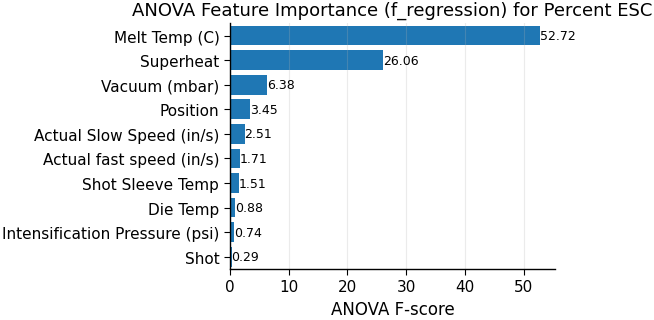

Saved outputs:
- Table: anova_feature_importance.csv
- Figure (PNG): anova_feature_importance_pub.png
- Figure (PDF): anova_feature_importance_pub.pdf
- Figure (SVG): anova_feature_importance_pub.svg


In [3]:


# -------------------- Target & Features --------------------
target_col = "Percent ESC"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Found: {list(df.columns)}")

# Build a robust exclusion set (case/space insensitive)
def canon(s: str) -> str:
    return " ".join(str(s).strip().lower().split())

# Base names to exclude (broad)
exclude_ci = {
    "ys", "elongation", "uts", canon(target_col),
    "melt temp",      # remove duplicate column (keep "Melt Temp (C)")
    "melt temp.",     # common variant
}

# Explicit variants you mentioned
explicit_variants = [
    "YS (Mpa)", "Elongation (%)", "UTS (MPA)",
]
exclude_ci.update(canon(x) for x in explicit_variants)

# Candidate features = everything except excluded names
feature_cols = [c for c in df.columns if canon(c) not in exclude_ci]

# Keep only numeric columns among those features
X_df = df[feature_cols].select_dtypes(include=[np.number]).copy()
y = df[target_col].values

# Report if any candidate features were dropped for being non-numeric
dropped_non_numeric = sorted(set(feature_cols) - set(X_df.columns))
if dropped_non_numeric:
    print("Dropped non-numeric columns from features:", dropped_non_numeric)

# -------------------- Impute (median) --------------------
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X_df)

# -------------------- ANOVA F-scores --------------------
F_scores, p_values = f_regression(X, y)

results = (
    pd.DataFrame({
        "feature": X_df.columns,
        "F_score": F_scores,
        "p_value": p_values
    })
    .sort_values("F_score", ascending=False)
    .reset_index(drop=True)
)

display(results)

# -------------------- Publication-style plot --------------------
# (Change the font if your journal prefers Times)
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "axes.linewidth": 1.0,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,
})

# Optionally show only top-k features for compactness
top_k = None  # e.g., 20
plot_df = results.copy().head(top_k) if top_k else results.copy()

fig_height = max(3.5, 0.35 * len(plot_df))
fig, ax = plt.subplots(figsize=(6.0, fig_height))

ypos = np.arange(len(plot_df))
vals = plot_df["F_score"].values
labs = plot_df["feature"].values

bars = ax.barh(ypos, vals)  # default color (journal-friendly)
ax.set_yticks(ypos, labs)
ax.set_xlabel("ANOVA F-score")
ax.set_title("ANOVA Feature Importance (f_regression) for Percent ESC")

# Clean look: remove top/right spines, add light x-grid
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.grid(axis="x", linestyle="-", alpha=0.25)

ax.invert_yaxis()  # highest on top

from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

# Value labels
for i, v in enumerate(vals):
    ax.text(v, i, f"{v:.2f}", va="center", ha="left", fontsize=9)

ax.set_xlim(left=0)
ax.margins(y=0.01)
fig.tight_layout()

# Save
fig.savefig(OUT_PNG, dpi=300)
fig.savefig(OUT_PDF)
fig.savefig(OUT_SVG)
plt.show()

# -------------------- Save Table --------------------
results.to_csv(OUT_CSV, index=False)
print("Saved outputs:")
print(f"- Table: {OUT_CSV}")
print(f"- Figure (PNG): {OUT_PNG}")
print(f"- Figure (PDF): {OUT_PDF}")
print(f"- Figure (SVG): {OUT_SVG}")


In [4]:
# -------------------- Target & Features --------------------
target_col = "Percent ESC"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Found: {list(df.columns)}")

# Build a robust exclusion set (case/space insensitive)
def canon(s: str) -> str:
    return " ".join(str(s).strip().lower().split())

# Base names to exclude (broad)
exclude_ci = {
    "ys", "elongation", "uts", canon(target_col),
    "melt temp",      # remove duplicate column (keep "Melt Temp (C)")
    "melt temp.",     # common variant
}

# Explicit variants you mentioned
explicit_variants = [
    "YS (Mpa)", "Elongation (%)", "UTS (MPA)",
]

# Add the new exclusions you found unimportant
more_exclusions = [
    "Die Temp",
    "Intensification Pressure (psi)",
    "Shot",
]

exclude_ci.update(canon(x) for x in explicit_variants)
exclude_ci.update(canon(x) for x in more_exclusions)

# Candidate features = everything except excluded names
feature_cols = [c for c in df.columns if canon(c) not in exclude_ci]

# Keep only numeric columns among those features
X_df = df[feature_cols].select_dtypes(include=[np.number]).copy()
y = df[target_col].values

# Report if any candidate features were dropped for being non-numeric
dropped_non_numeric = sorted(set(feature_cols) - set(X_df.columns))
if dropped_non_numeric:
    print("Dropped non-numeric columns from features:", dropped_non_numeric)

X_df

Superheat  Melt Temp (C)  Shot Sleeve Temp  Vacuum (mbar)  \
0          74            675               265             30   
1          74            675               275             33   
2          74            675               275             34   
3          70            671               270             40   
4          70            671               270             40   
..        ...            ...               ...            ...   
70        123            734               270             39   
71        126            739               270             37   
72        127            738               270             44   
73        128            739               270             36   
74        127            738               270             43   

    Actual Slow Speed (in/s)  Actual fast speed (in/s)  Position  
0                         12                        84         1  
1                         11                       112         1  
2                         11                       112         2  
3                         12                       107         2  
4                         12                       107         1  
..                       ...                       ...       ...  
70                        12                        52         1  
71                        12                        53         2  
72                        12                        51         2  
73                        11                        51         3  
74                        12                        50         3  

[75 rows x 7 columns]

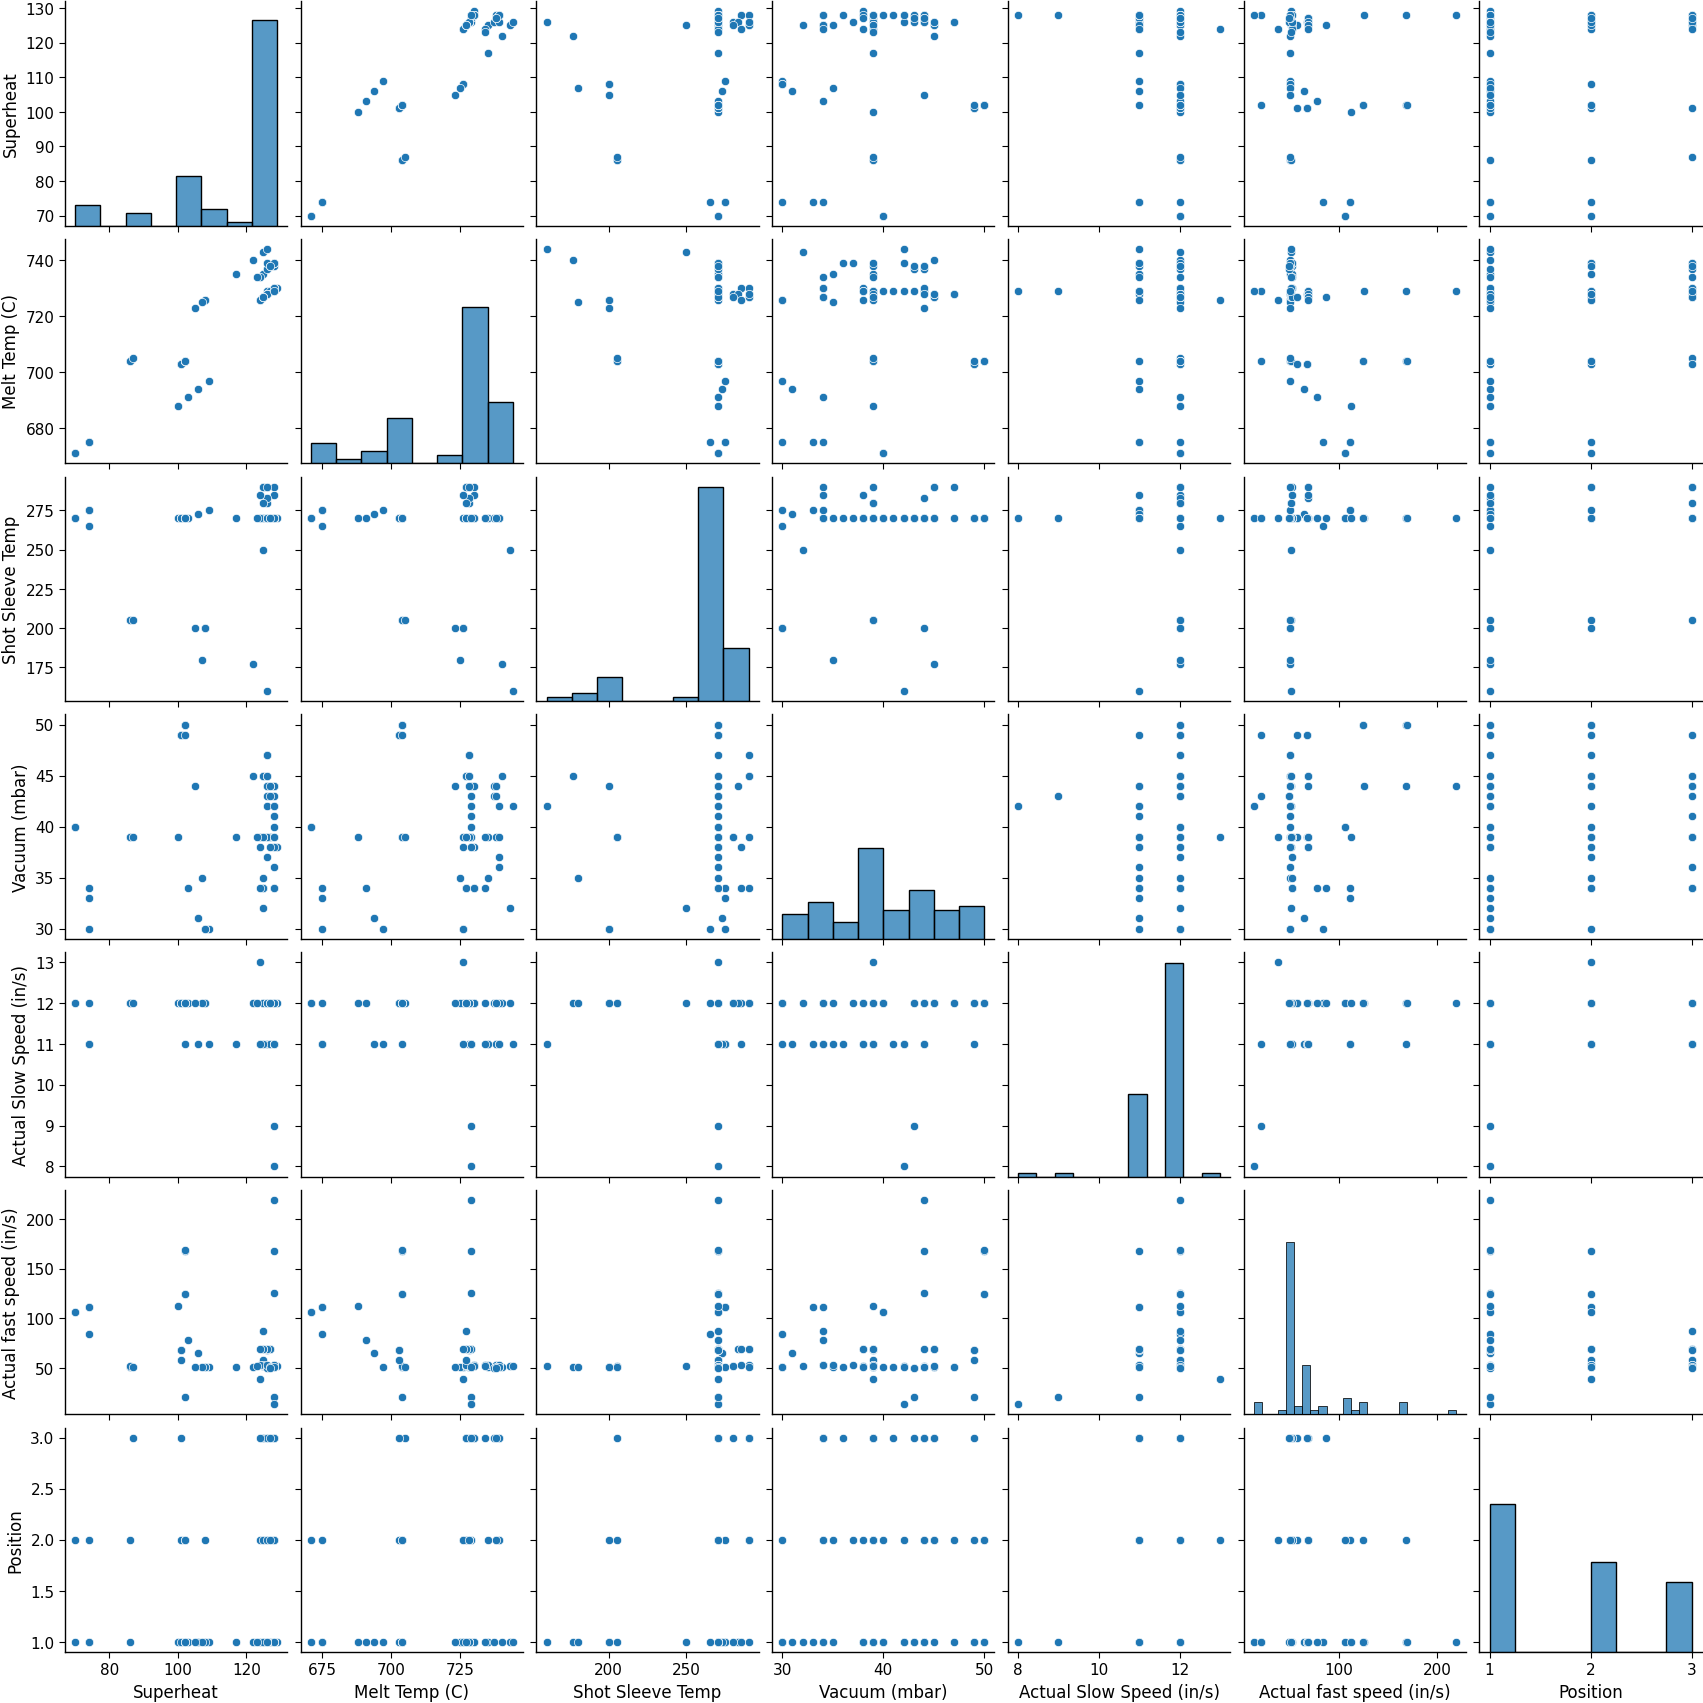

In [5]:
import seaborn as sns
sns.pairplot(X_df)
plt.show()

In [6]:
# -------------------- Convert y to binary labels --------------------
def convert_label(x):
    if x > 0.0:
        return 1
    else:
        return 0

# Wrap y into a Series for apply (keeps the format you showed)
y = pd.Series(y).apply(lambda x: convert_label(x)).values

y


array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0])

In [7]:
# -------------------- Combine X_df with y --------------------
# Make sure y is aligned (same row count)
if len(y) != len(X_df):
    raise ValueError(f"Length mismatch: y has {len(y)} rows, X_df has {len(X_df)} rows")

# Add y as a new column called '%esc'
full_df = X_df.copy()
full_df["Percent ESC"] = y

display(full_df.head())
print(full_df.shape)

Superheat  Melt Temp (C)  Shot Sleeve Temp  Vacuum (mbar)  \
0         74            675               265             30   
1         74            675               275             33   
2         74            675               275             34   
3         70            671               270             40   
4         70            671               270             40   

   Actual Slow Speed (in/s)  Actual fast speed (in/s)  Position  Percent ESC  
0                        12                        84         1            1  
1                        11                       112         1            1  
2                        11                       112         2            1  
3                        12                       107         2            1  
4                        12                       107         1            1

(75, 8)


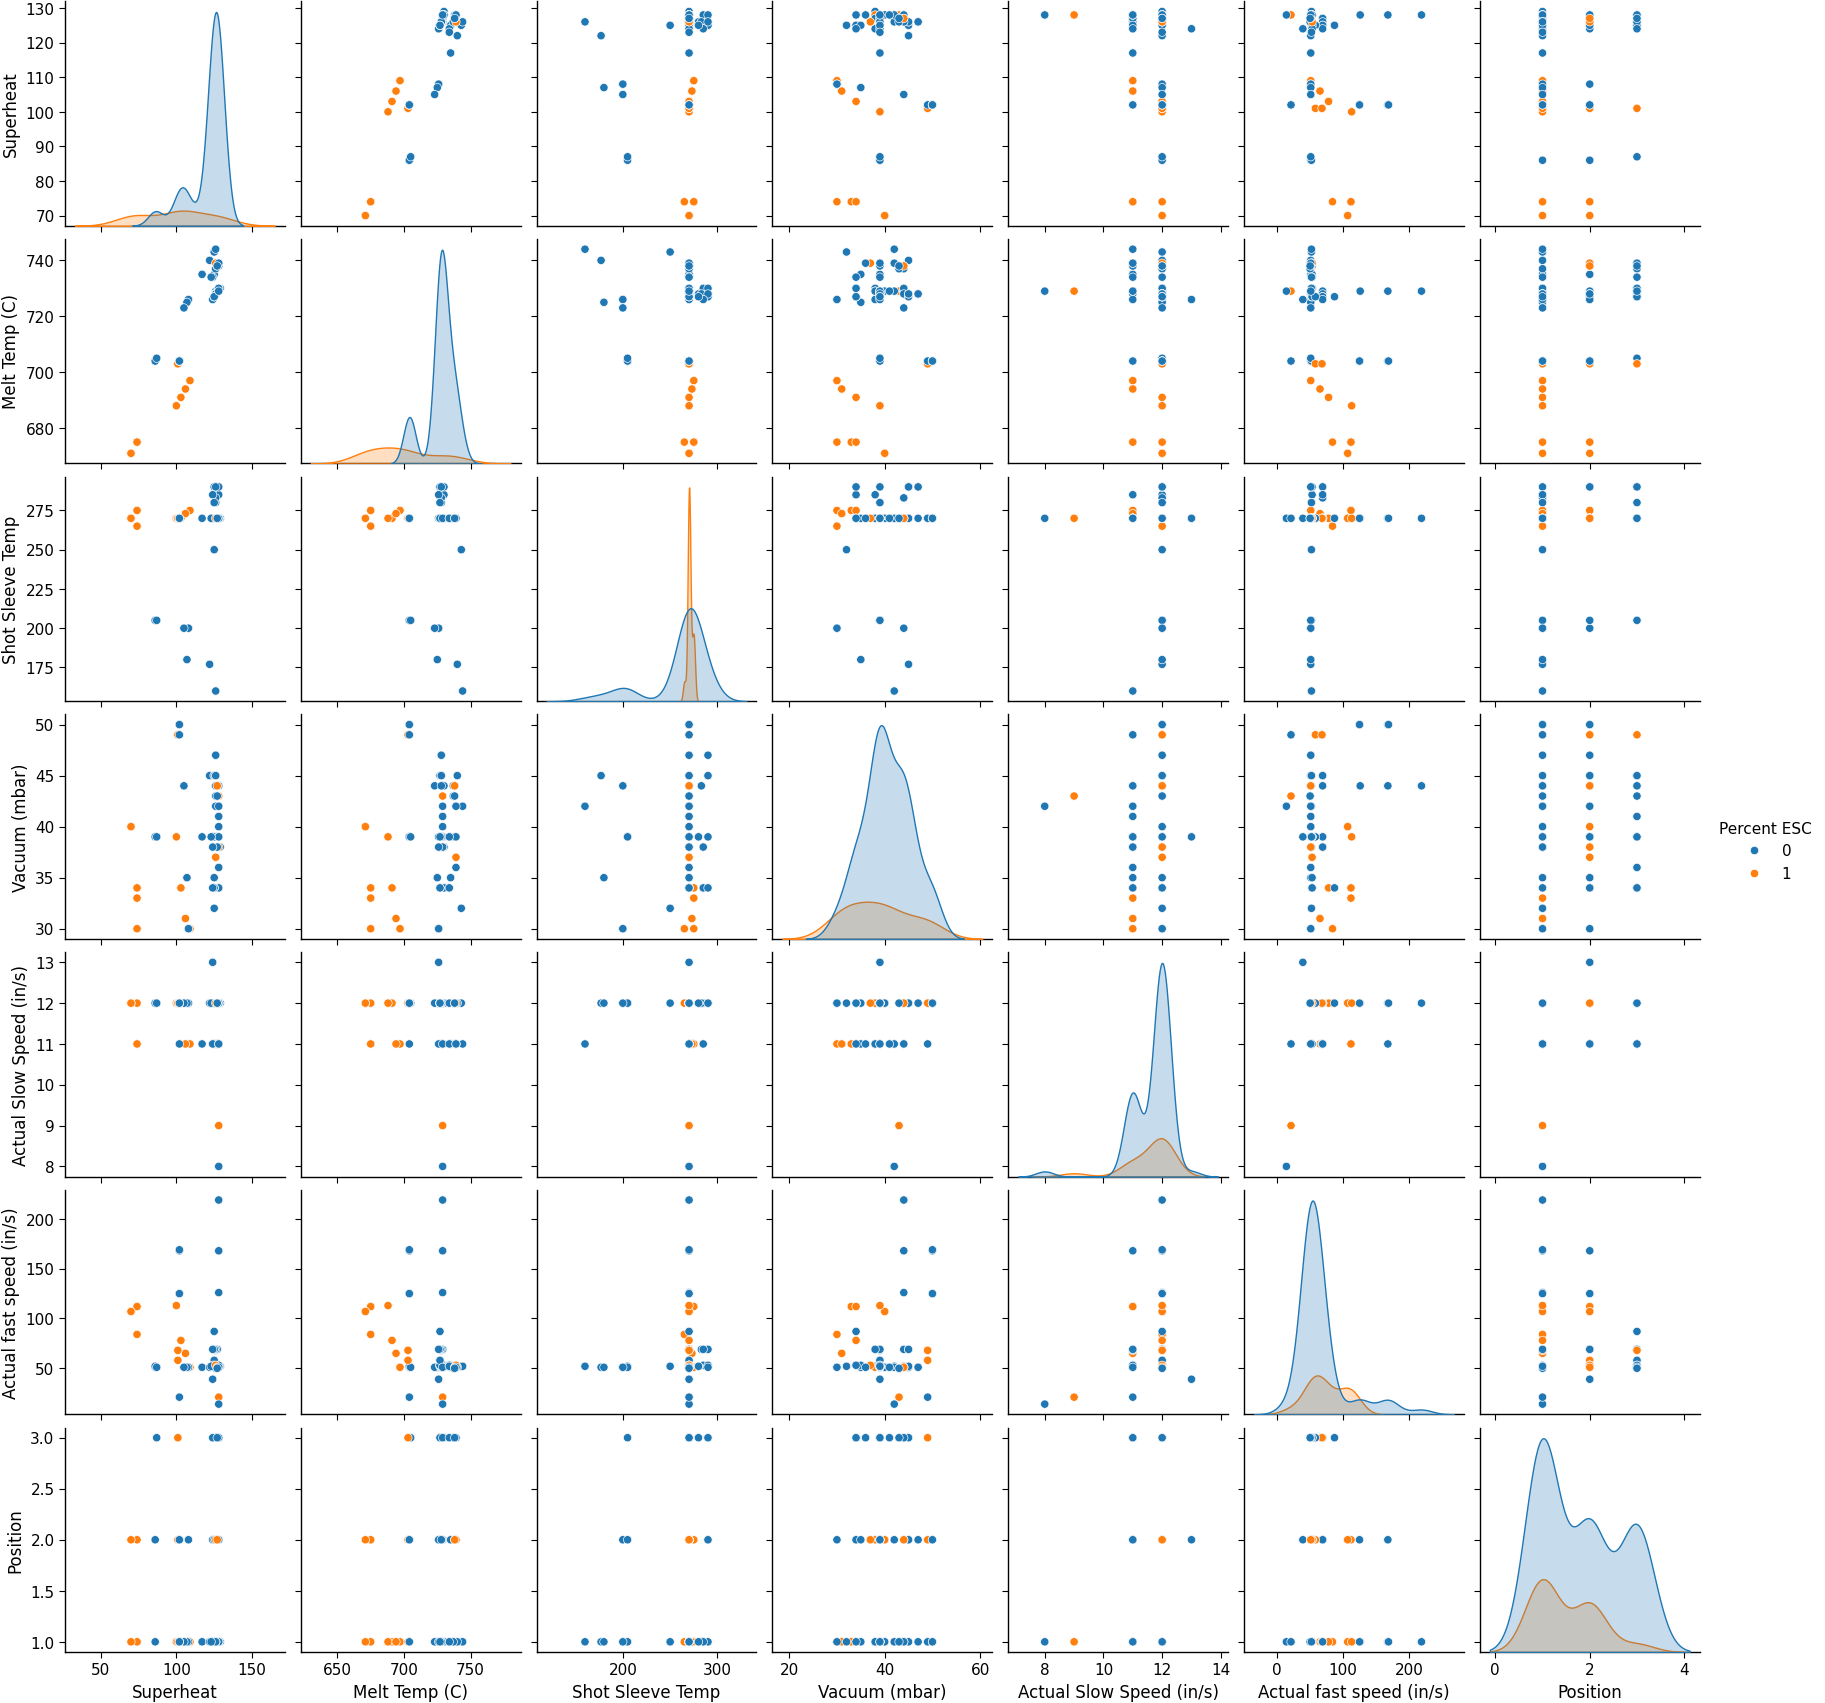

In [8]:
sns.pairplot(full_df,hue='Percent ESC')
plt.show()

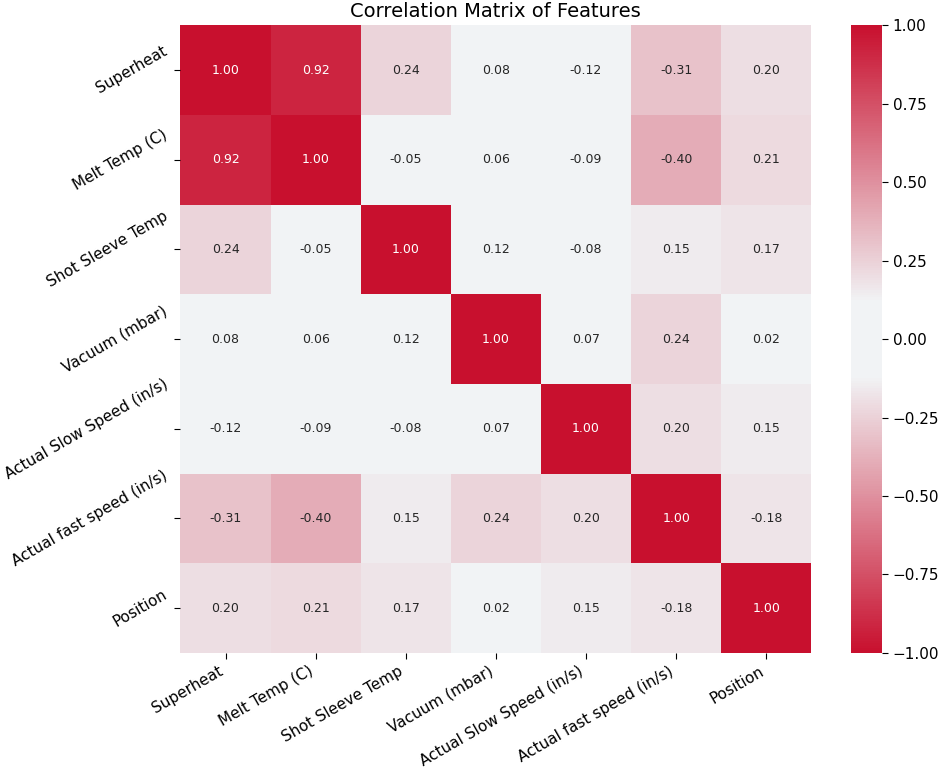

In [9]:
# -------------------- Correlation Matrix --------------------
import seaborn as sns
import matplotlib.colors as mcolors

# Compute correlation (numeric columns only)
corrmatrix = X_df.corr(numeric_only=True)

# Define custom colormap (dark red ends, white center)
colors = [
    (0,   "#C8102E"),  # dark red at the low end
    (0.44, "#F1F3F5"), # white in the middle
    (0.56, "#F1F3F5"), # white in the middle
    (1,   "#C8102E")   # dark red at the high end
]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_bwr", colors)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corrmatrix,
    annot=True,
    cmap=custom_cmap,
    vmin=-1,
    vmax=1,
    center=0,
    fmt=".2f",          # show correlations with 2 decimals
    annot_kws={"size": 9}
)

plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=30, ha='right')
plt.title("Correlation Matrix of Features", fontsize=14)

plt.tight_layout()
plt.show()


In [10]:
# ================== 5-Fold Stratified Split (for classification) ==================
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# If you're using the combined dataset we built earlier:
#   full_df = X_df (processed features) + column '%esc' (0/1 labels)
if "Percent ESC" not in full_df.columns:
    raise ValueError("Expected the label column 'Percent ESC' in full_df. Make sure you combined X_df with y earlier.")

# Features/labels
X = full_df.drop(columns=["Percent ESC"]).copy()
y = full_df["Percent ESC"].astype(int).copy()

# 5-fold stratified CV (shuffle for robustness)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

# Inspect fold sizes and class balance
print("Total samples:", len(y))
print("Class balance (overall):")
print(y.value_counts(normalize=True).rename("proportion").to_frame().assign(count=y.value_counts()))

for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    print(f"\nFold {fold_idx}:")
    print(f"  Train size: {len(tr_idx)} | Valid size: {len(va_idx)}")
    print("  Train class balance:", y_tr.value_counts(normalize=True).round(3).to_dict())
    print("  Valid class balance:", y_va.value_counts(normalize=True).round(3).to_dict())

# You can now use `cv` directly with cross_val_score / GridSearchCV / cross_validate, e.g.:
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
#
# pipe = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler(with_mean=True, with_std=True)),   # safe for most models; tree models ignore scale
#     ("clf", LogisticRegression(max_iter=500, n_jobs=None))
# ])
#
# scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")  # or "roc_auc", "accuracy", etc.
# print("CV F1:", scores, "Mean:", scores.mean())


Total samples: 75
Class balance (overall):
             proportion  count
Percent ESC                   
0              0.786667     59
1              0.213333     16

Fold 1:
  Train size: 60 | Valid size: 15
  Train class balance: {0: 0.8, 1: 0.2}
  Valid class balance: {0: 0.733, 1: 0.267}

Fold 2:
  Train size: 60 | Valid size: 15
  Train class balance: {0: 0.783, 1: 0.217}
  Valid class balance: {0: 0.8, 1: 0.2}

Fold 3:
  Train size: 60 | Valid size: 15
  Train class balance: {0: 0.783, 1: 0.217}
  Valid class balance: {0: 0.8, 1: 0.2}

Fold 4:
  Train size: 60 | Valid size: 15
  Train class balance: {0: 0.783, 1: 0.217}
  Valid class balance: {0: 0.8, 1: 0.2}

Fold 5:
  Train size: 60 | Valid size: 15
  Train class balance: {0: 0.783, 1: 0.217}
  Valid class balance: {0: 0.8, 1: 0.2}


# New Section

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Best 5-fold CV F1: 0.8514285714285714

Classification report (5-fold OOF):
              precision    recall  f1-score   support

           0      0.937     1.000     0.967        59
           1      1.000     0.750     0.857        16

    accuracy                          0.947        75
   macro avg      0.968     0.875     0.912        75
weighted avg      0.950     0.947     0.944        75



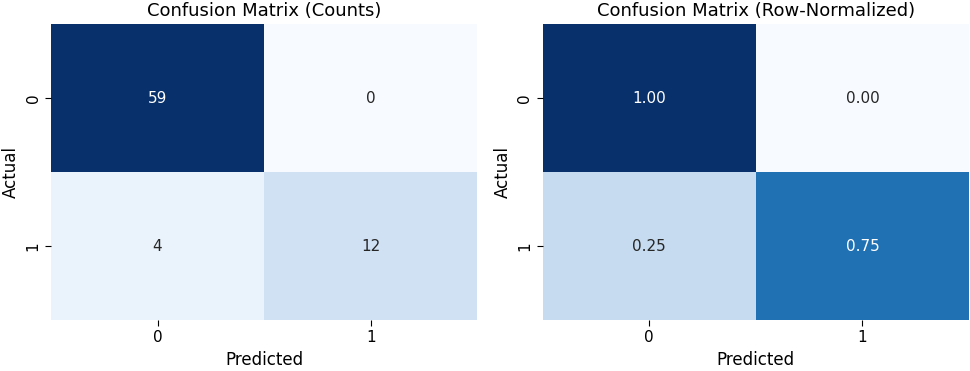

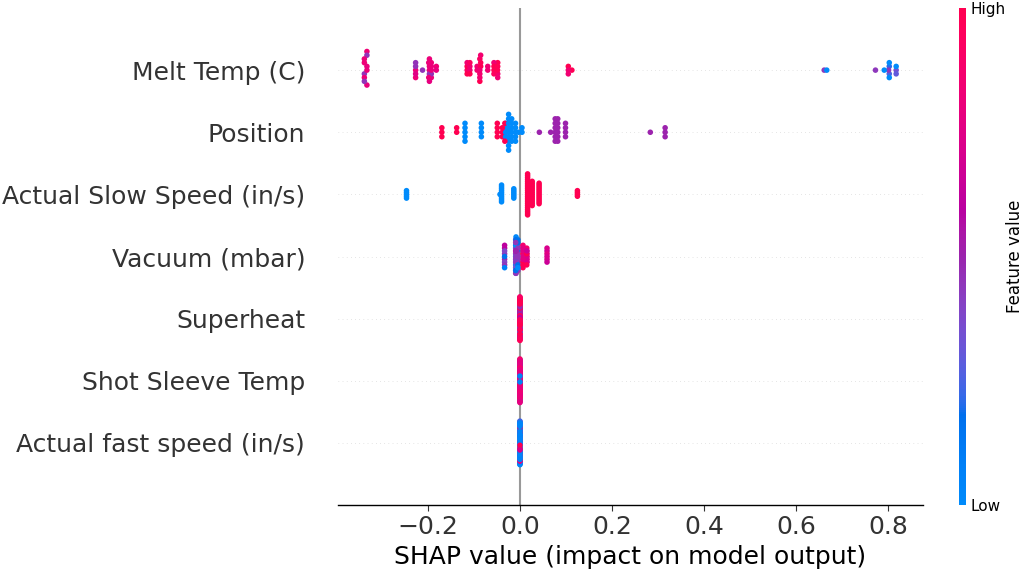

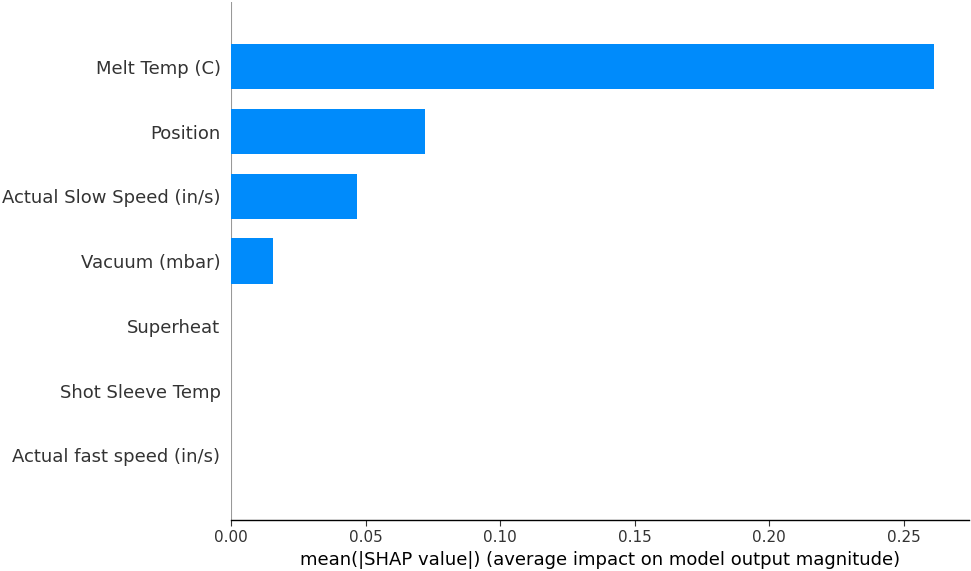

<Figure size 640x480 with 0 Axes>

In [11]:
# ================= Decision Tree (5-fold CV) + Confusion Matrix + SHAP =================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# -------- Prepare X, y (expects your combined dataset already built) --------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Make sure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(random_state=111))
])

param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 3, 4, 5, 6, 8, 12],
    "clf__min_samples_split": [2, 4, 8, 12],
    "clf__min_samples_leaf": [1, 2, 4, 6],
    # "clf__class_weight": [None, "balanced"],  # uncomment if classes are imbalanced
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",              # or "roc_auc", "balanced_accuracy", "f1_macro"
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs.fit(X, y)
best_pipe = gs.best_estimator_
print("Best params:", gs.best_params_)
print("Best 5-fold CV F1:", gs.best_score_)

# -------- Out-of-fold predictions for evaluation --------
oof_pred = cross_val_predict(best_pipe, X, y, cv=cv, method="predict")
print("\nClassification report (5-fold OOF):")
print(classification_report(y, oof_pred, digits=3))

# Confusion matrices (counts + normalized)
cm  = confusion_matrix(y, oof_pred)
cmn = confusion_matrix(y, oof_pred, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# -------- SHAP global importance (function-based explainer) --------
# Use the pipeline's predict_proba so preprocessing is included.
# This avoids the TreeExplainer restriction you hit.
background_raw = X.sample(min(200, len(X)), random_state=111)
explainer = shap.Explainer(best_pipe.predict_proba, background_raw)
sv = explainer(X)

# Positive class index (use 1 if it exists)
clf = best_pipe.named_steps["clf"]
class_idx = 1 if (hasattr(clf, "classes_") and 1 in clf.classes_) else 0

# Beeswarm (global importance for P(class=1))
shap.summary_plot(
    sv[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()

# Increase tick label sizes
ax.tick_params(axis='both', labelsize=18)

# Increase axis label size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout(); plt.show()

# Bar chart of mean |SHAP|
shap.summary_plot(
    sv[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout(); plt.show()


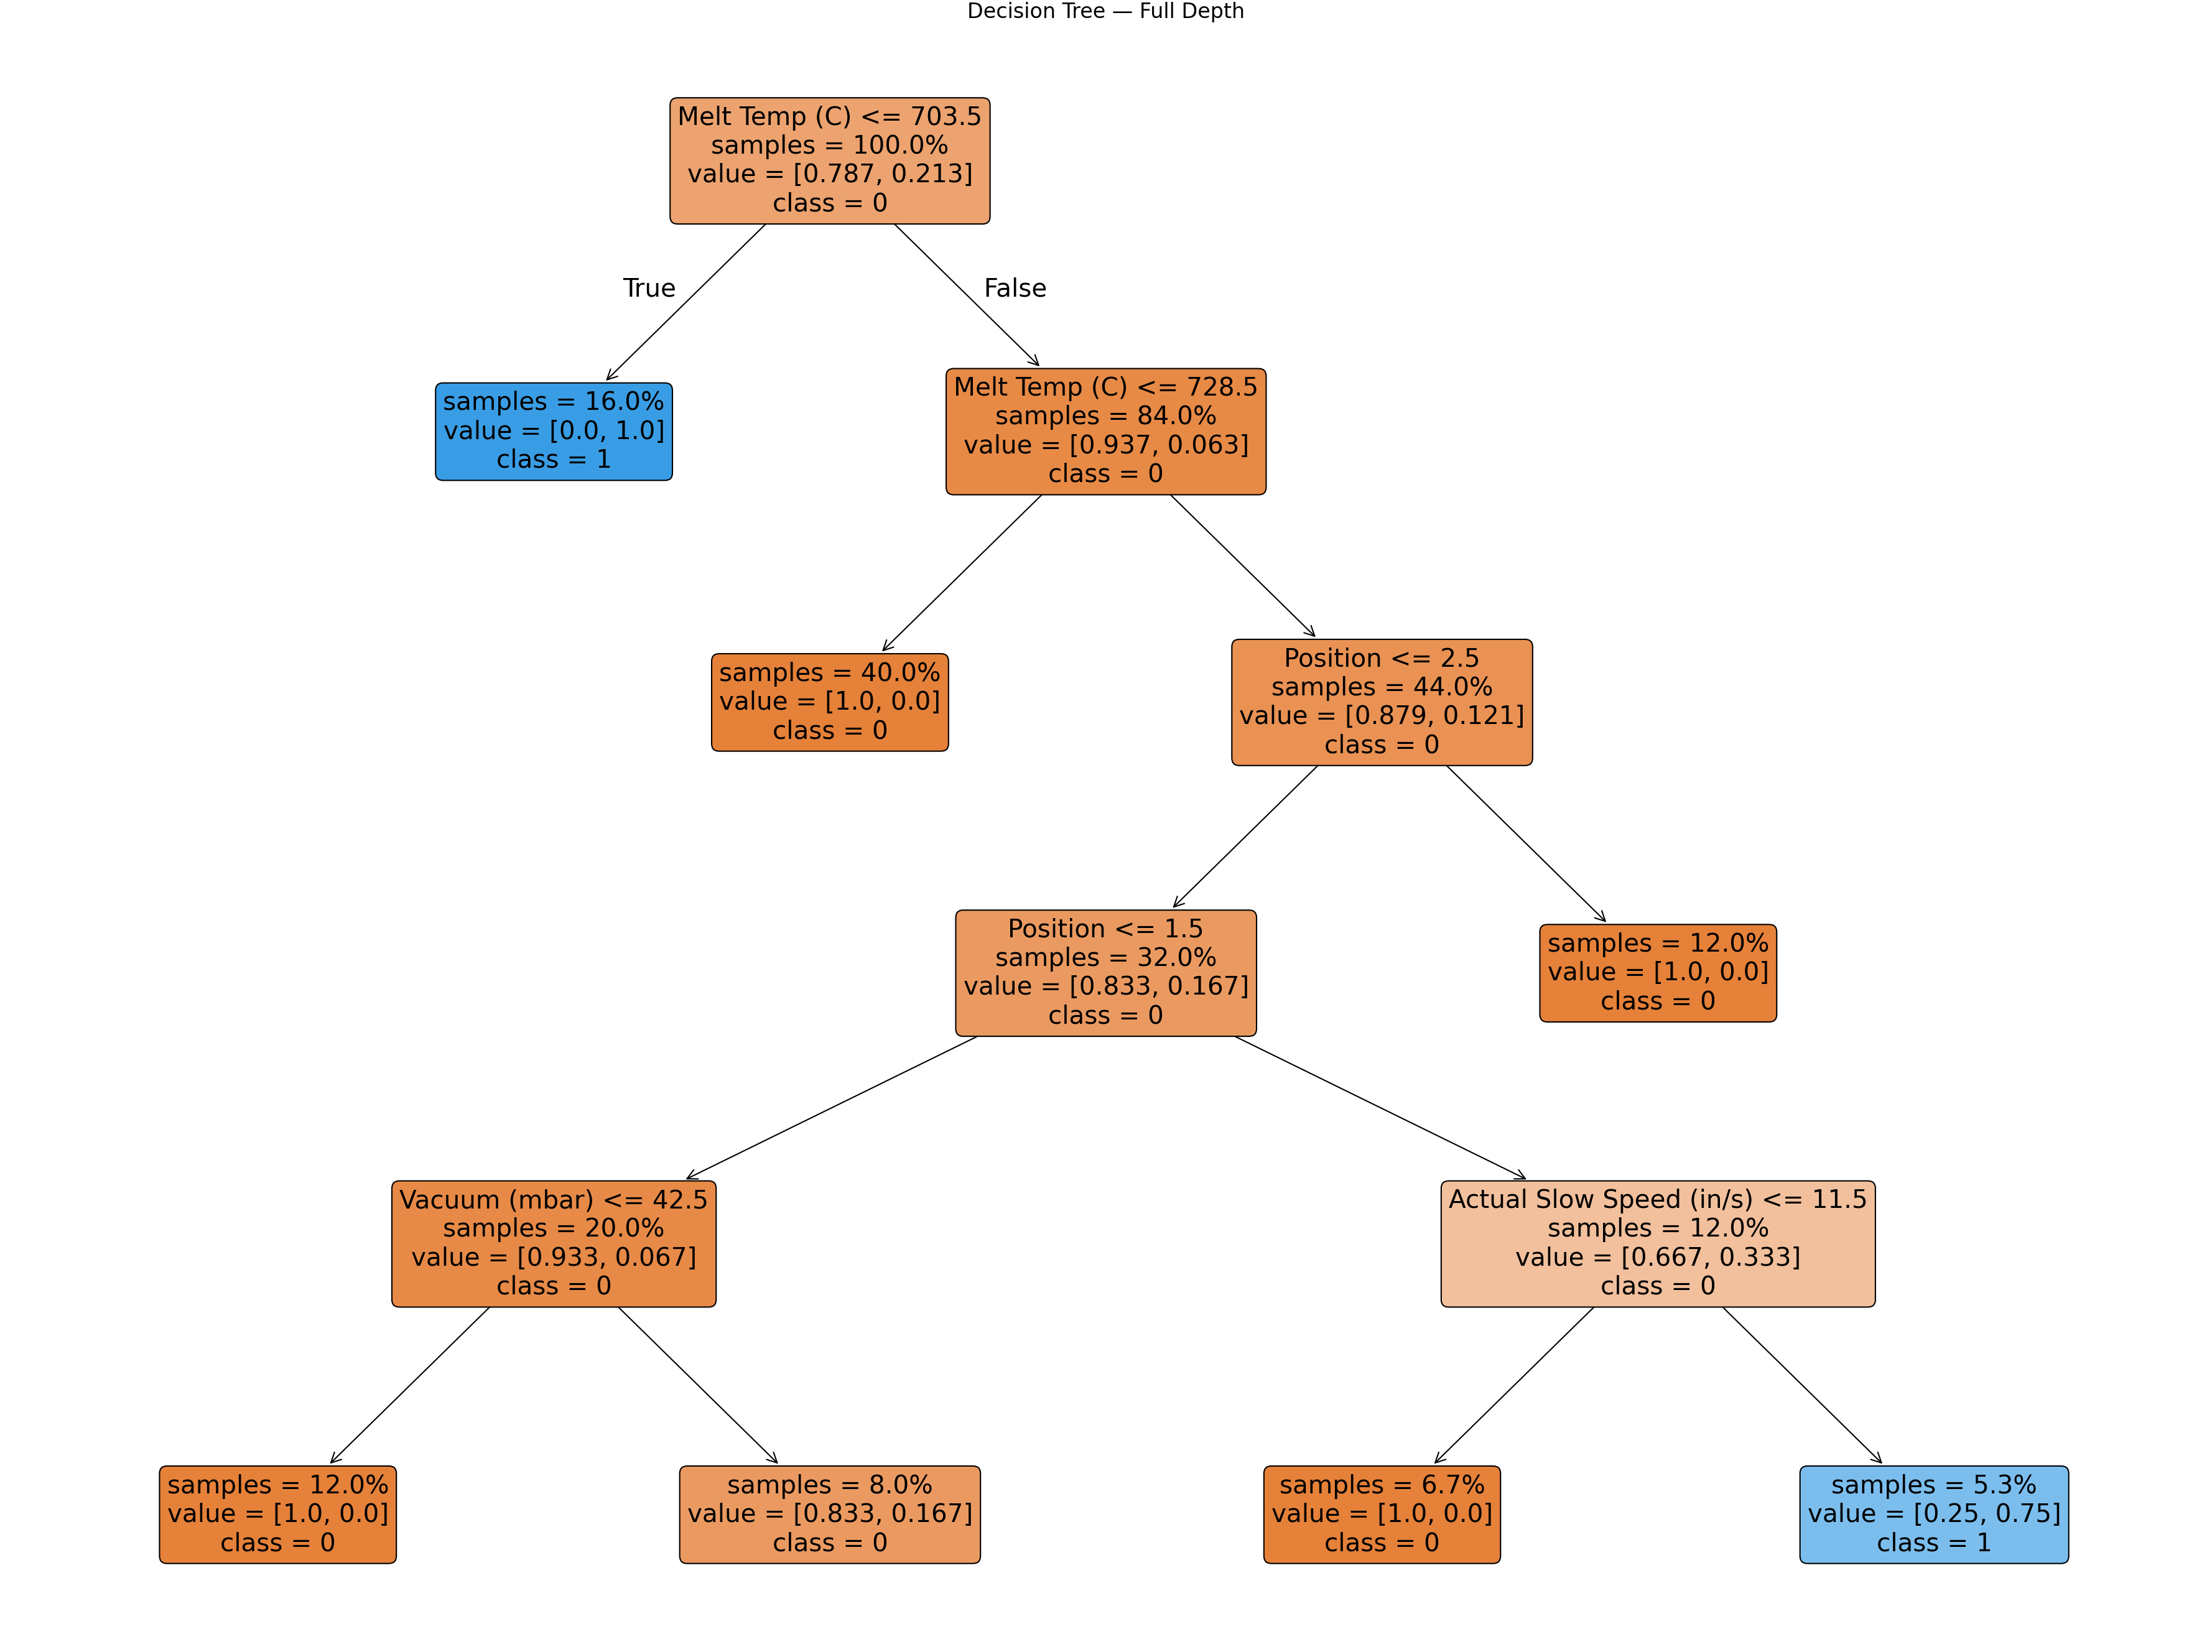

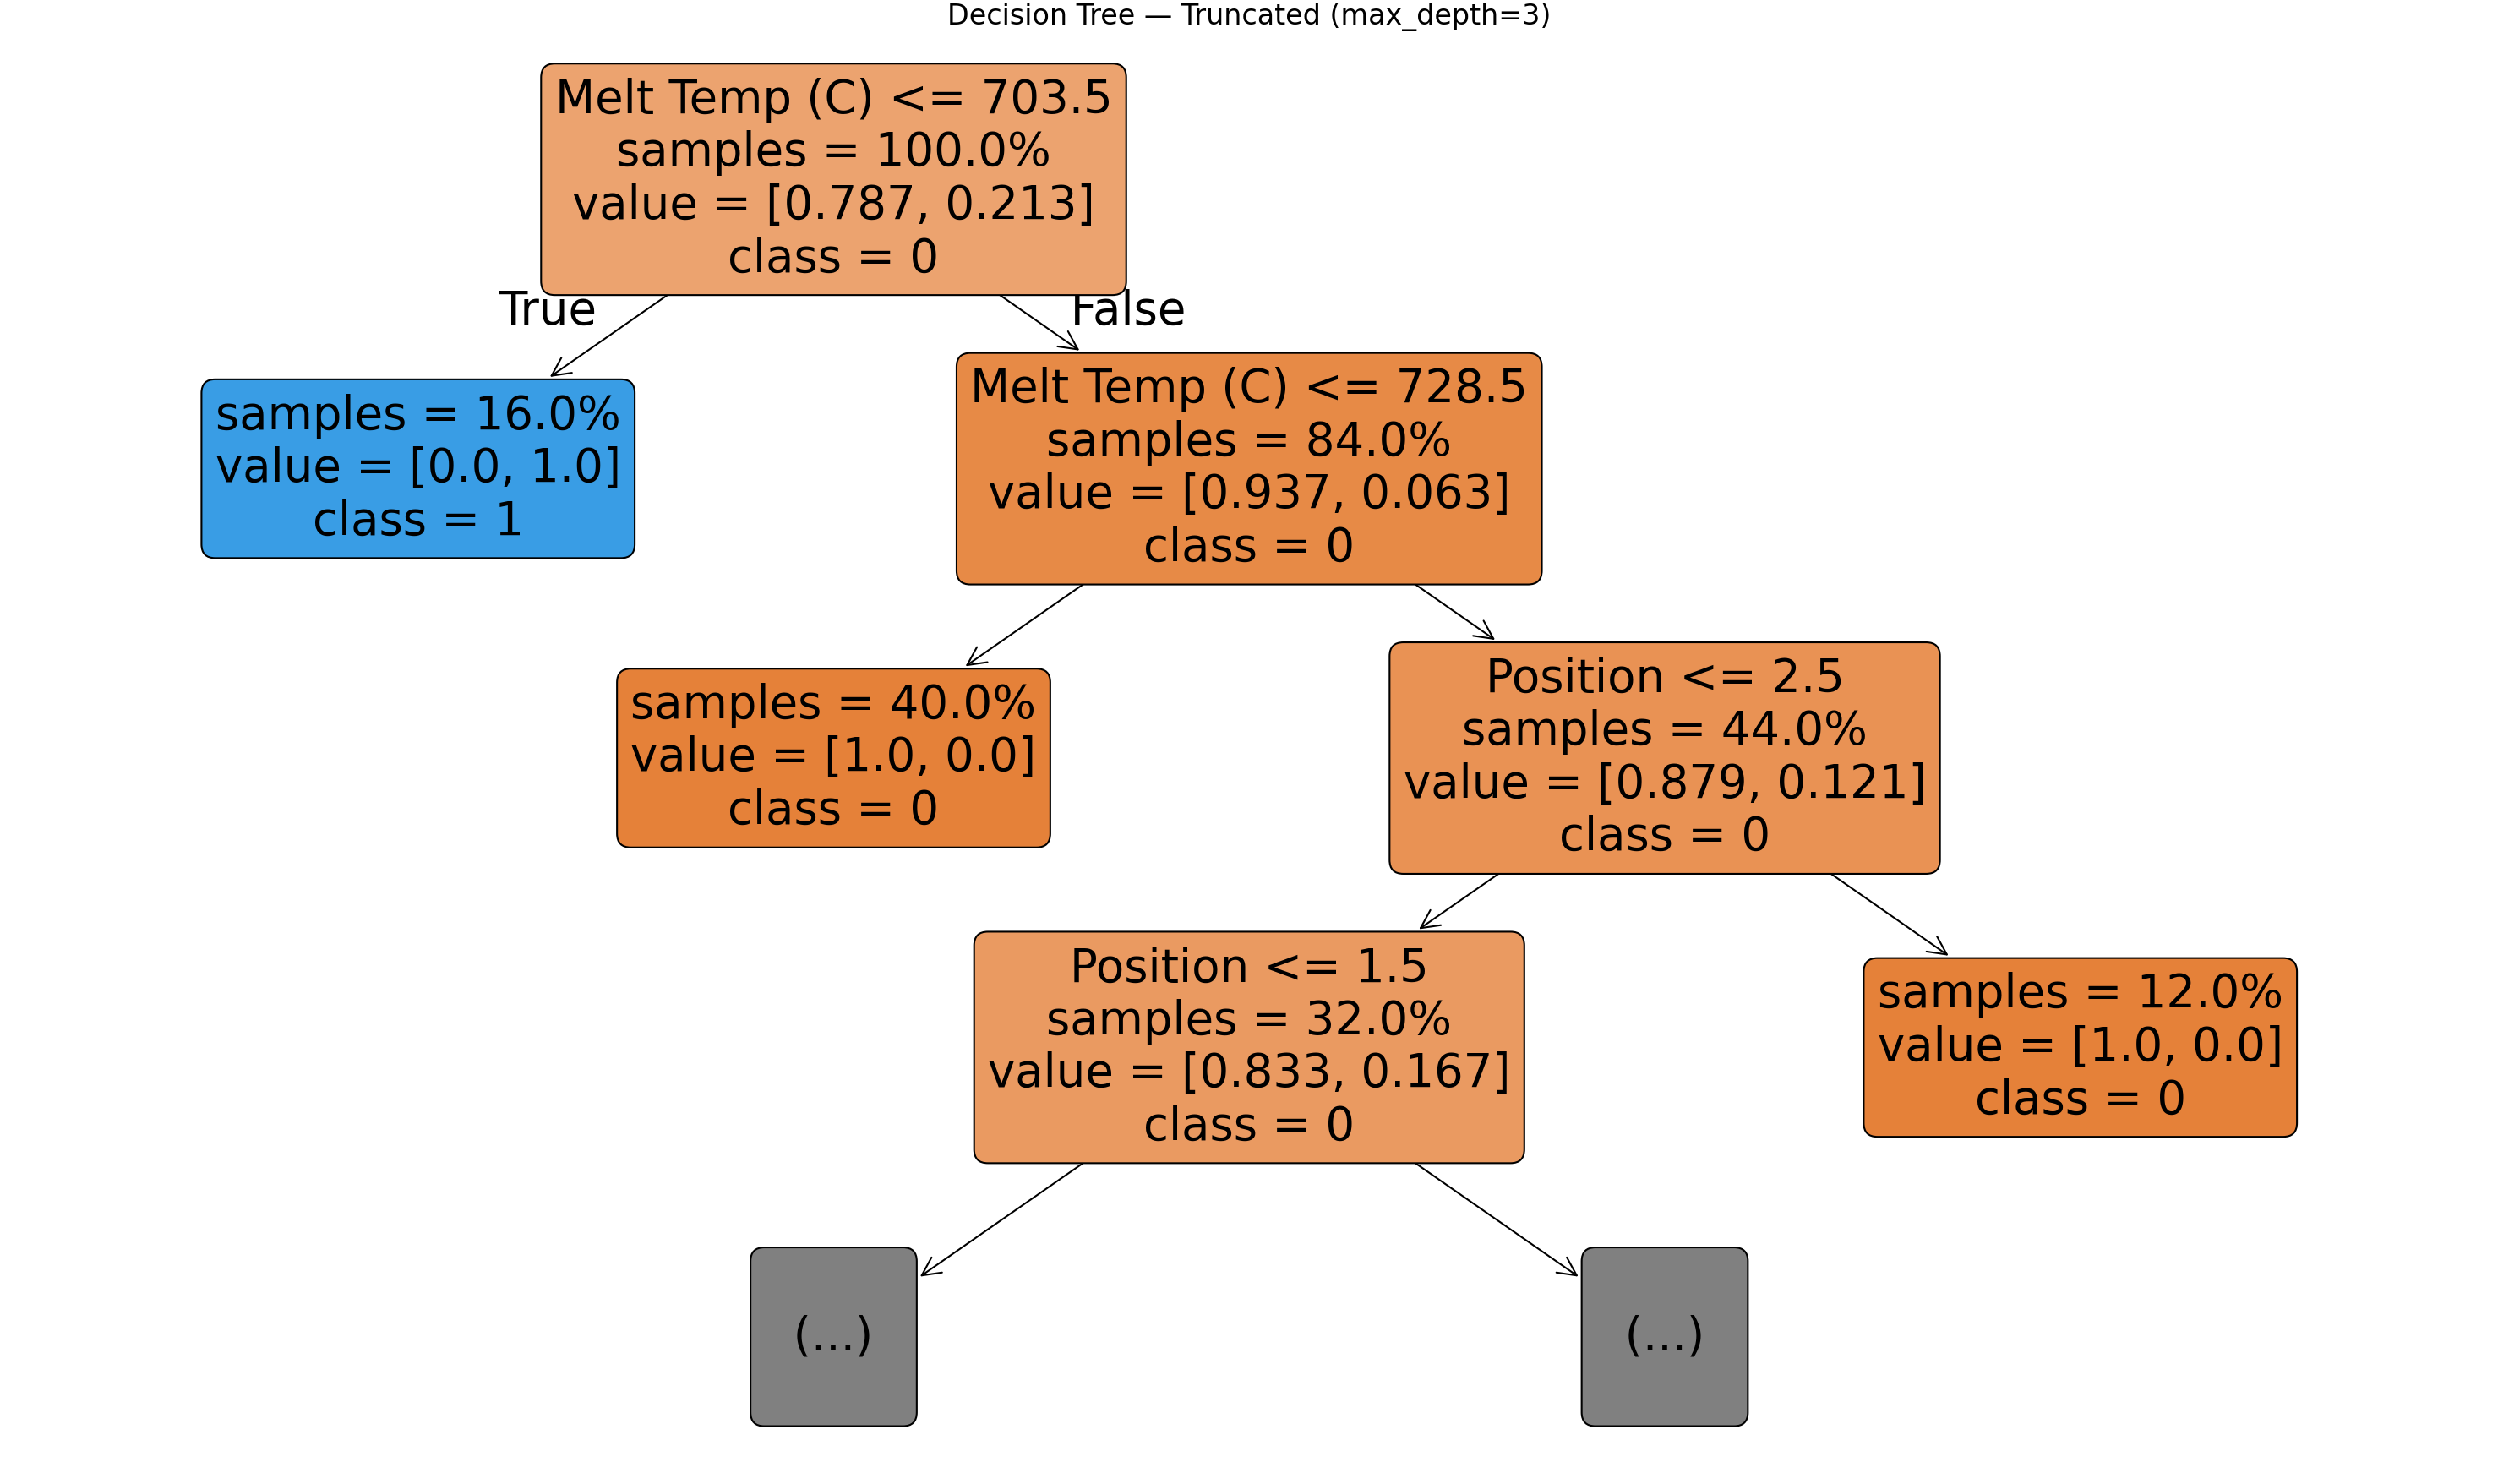

In [12]:
# =============== Decision Tree Diagram (from best_pipe) ===============
from sklearn import tree
import matplotlib.pyplot as plt

# Get the fitted DecisionTreeClassifier from the tuned pipeline
if 'best_pipe' in globals():
    tree_final = best_pipe.named_steps['clf']
elif 'gs' in globals():
    tree_final = gs.best_estimator_.named_steps['clf']
else:
    raise ValueError("No fitted model found. Run the GridSearchCV cell first to create best_pipe or gs.")

# Feature names = original columns used for training (imputer doesn't change names)
feature_names = X.columns.tolist()

# Class names from the fitted classifier (fallback to ['0','1'])
class_names = [str(c) for c in getattr(tree_final, "classes_", ['0','1'])]

# -------- Full tree (may be large) --------
fig, ax = plt.subplots(figsize=(24, 18), dpi=150)
tree.plot_tree(
    tree_final,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    proportion=True,   # node samples shown as proportion of all samples
    impurity=False,    # hide impurity to reduce clutter
    ax=ax
)
plt.title("Decision Tree — Full Depth", fontsize=16)
plt.tight_layout()
plt.show()

# Optional: save
# fig.savefig("decision_tree_full.png", dpi=300, bbox_inches="tight")

# -------- Truncated view (readable for slides/papers) --------
fig, ax = plt.subplots(figsize=(20, 12), dpi=150)
tree.plot_tree(
    tree_final,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    proportion=True,
    impurity=False,
    max_depth=3,       # <- adjust for desired depth
    ax=ax
)
plt.title("Decision Tree — Truncated (max_depth=3)", fontsize=16)
plt.tight_layout()
plt.show()

# Optional: save
# fig.savefig("decision_tree_truncated_depth3.png", dpi=300, bbox_inches="tight")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params (RF): {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best 5-fold CV F1 (RF): 0.8514285714285714

Classification report (5-fold OOF, RF):
              precision    recall  f1-score   support

           0      0.937     1.000     0.967        59
           1      1.000     0.750     0.857        16

    accuracy                          0.947        75
   macro avg      0.968     0.875     0.912        75
weighted avg      0.950     0.947     0.944        75



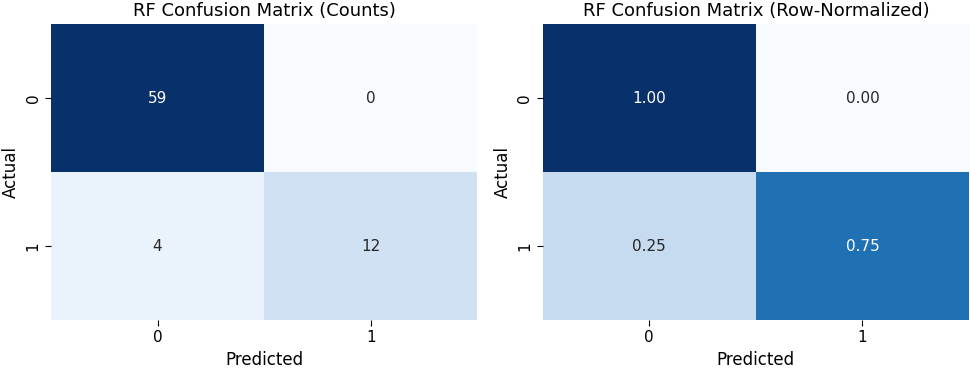

ExactExplainer explainer: 76it [00:12,  1.32it/s]


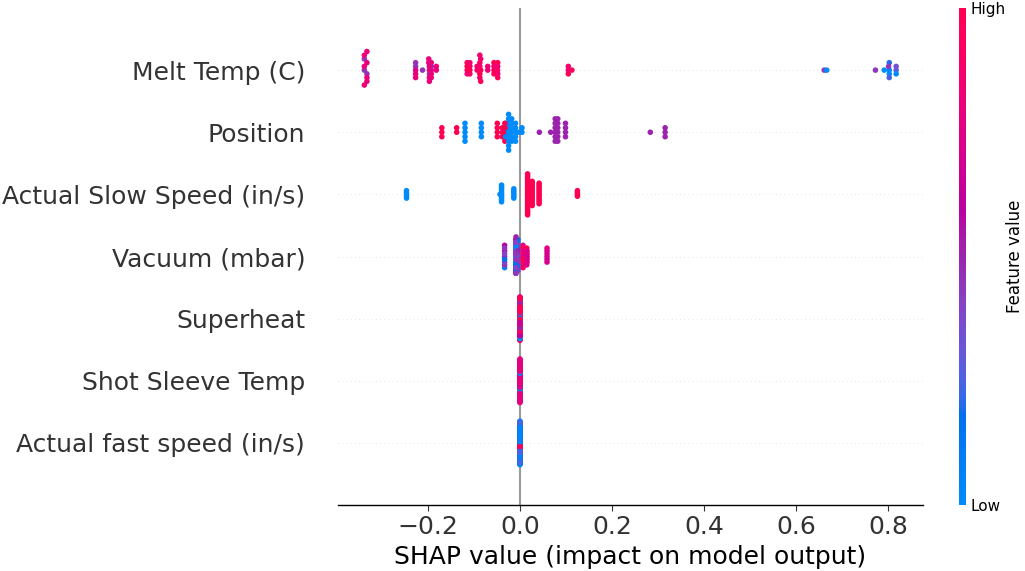

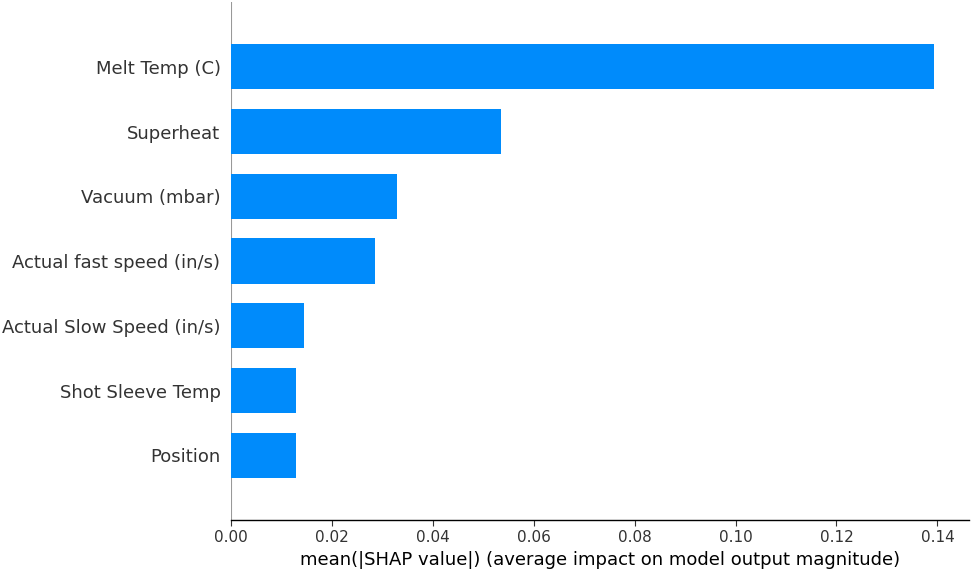

<Figure size 640x480 with 0 Axes>

In [13]:
# =============== Random Forest (5-fold CV) + Confusion Matrix + SHAP ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# -------- Prepare X, y (expects your combined dataset already built) --------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Make sure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=111, n_jobs=-1))
])

param_grid_rf = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 4, 6, 10],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", 0.5],
    # "clf__class_weight": [None, "balanced"],  # uncomment if classes are imbalanced
}

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring="f1",                  # alternatives: "f1_macro", "roc_auc", "balanced_accuracy"
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs_rf.fit(X, y)
best_pipe_rf = gs_rf.best_estimator_
print("Best params (RF):", gs_rf.best_params_)
print("Best 5-fold CV F1 (RF):", gs_rf.best_score_)

# -------- Out-of-fold predictions for evaluation --------
oof_pred_rf = cross_val_predict(best_pipe_rf, X, y, cv=cv, method="predict")
print("\nClassification report (5-fold OOF, RF):")
print(classification_report(y, oof_pred_rf, digits=3))

# Confusion matrices (counts + normalized)
cm_rf  = confusion_matrix(y, oof_pred_rf)
cmn_rf = confusion_matrix(y, oof_pred_rf, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_rf,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("RF Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn_rf, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("RF Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# -------- SHAP global importance (function-based explainer) --------
# Explains P(class=1); includes preprocessing inside the pipeline.
background_raw = X.sample(min(200, len(X)), random_state=111)
explainer_rf = shap.Explainer(best_pipe_rf.predict_proba, background_raw)
sv_rf = explainer_rf(X)

# Positive class index
clf_rf = best_pipe_rf.named_steps["clf"]
class_idx = 1 if (hasattr(clf_rf, "classes_") and 1 in clf_rf.classes_) else 0

# Beeswarm (global importance for P(class=1))
shap.summary_plot(
    sv[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()

# Increase tick label sizes
ax.tick_params(axis='both', labelsize=18)

# Increase axis label size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout(); plt.show()

# Bar chart of mean |SHAP|
shap.summary_plot(
    sv_rf[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout(); plt.show()


Prediction map features: y-axis = 'Melt Temp (C)', x-axis = 'Superheat'


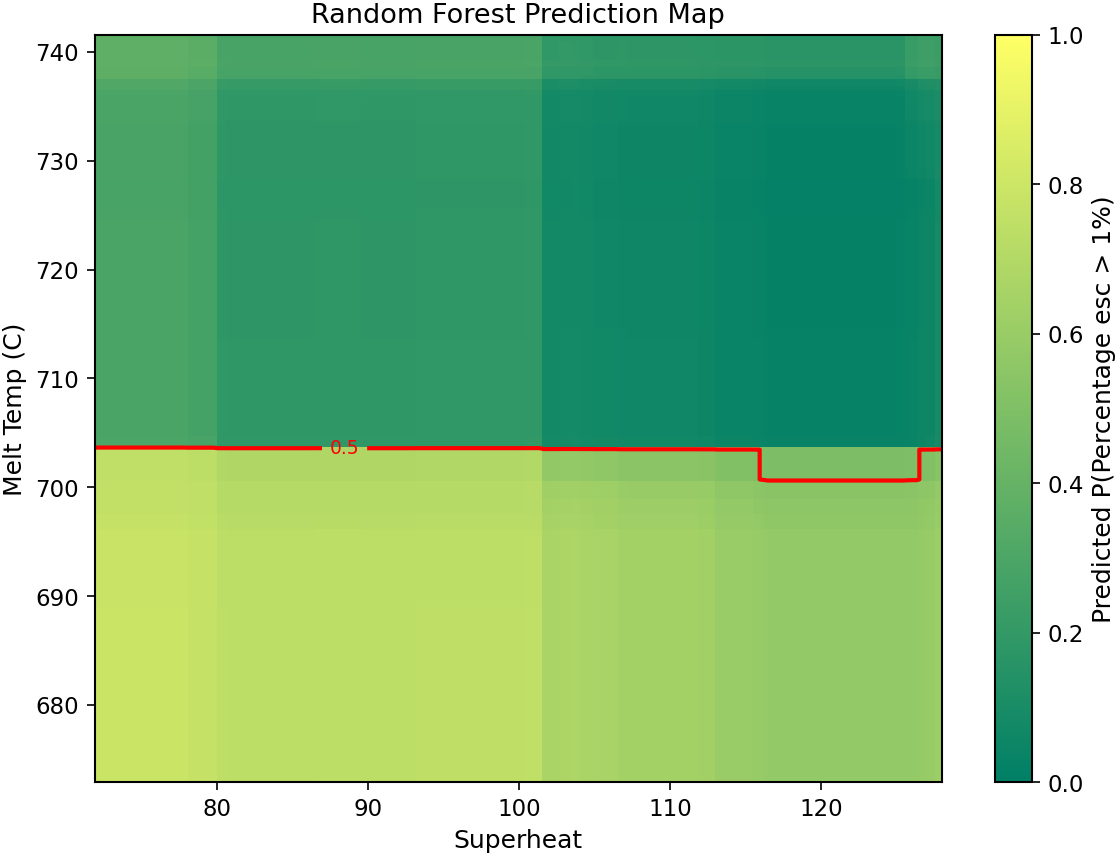

In [14]:
# =============== Random Forest Prediction Map (2-feature sweep) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy

# ---- Get the fitted RF pipeline and feature names ----
if 'best_pipe_rf' in globals():
    rf_pipe = best_pipe_rf
elif 'gs_rf' in globals():
    rf_pipe = gs_rf.best_estimator_
else:
    raise ValueError("No trained Random Forest found. Run the RF CV cell to create best_pipe_rf or gs_rf first.")

# X must be the same feature set used to train rf_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
rf = rf_pipe.named_steps["clf"]

# ---- Choose the two features to sweep ----
# Option A: let the code auto-pick the top-2 by feature_importances_
importances = getattr(rf, "feature_importances_", None)
if importances is None:
    raise ValueError("RandomForest has no feature_importances_ (unexpected).")
top2_idx = np.argsort(importances)[::-1][:2]
feat_i = feature_names[top2_idx[0]]   # y-axis in plot
feat_ii = feature_names[top2_idx[1]]  # x-axis in plot

# Option B (manual override): uncomment and set two feature names present in X
# feat_i  = "Superheat (C)"
# feat_ii = "Melt Temp (C)"

print(f"Prediction map features: y-axis = '{feat_i}', x-axis = '{feat_ii}'")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    lo, hi = np.percentile(col.dropna().values, [q_low, q_high])
    if lo == hi:
        # fallback small window if constant
        v = float(lo)
        eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

lo_i,  hi_i  = _range_for(X[feat_i])
lo_ii, hi_ii = _range_for(X[feat_ii])

# ---- Build a grid ----
n_points = 201  # resolution per axis
grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
II, I = np.meshgrid(grid_ii, grid_i)            # II: x-grid, I: y-grid

# ---- Create a DataFrame of all grid points with other features fixed to median ----
base = X.median(numeric_only=True)    # default values for non-swept features
grid_df = pd.DataFrame(
    np.tile(base.values, (n_points * n_points, 1)),
    columns=feature_names
)

# Set the two swept features
grid_df[feat_i]  = I.ravel()
grid_df[feat_ii] = II.ravel()

# ---- Predict probability of class 1 over the grid ----
class_idx = 1 if (hasattr(rf, "classes_") and 1 in rf.classes_) else 0
probs = rf_pipe.predict_proba(grid_df)[:, class_idx]  # shape (n_points^2,)
Z = probs.reshape(n_points, n_points)

# ---- Plot the prediction map ----
plt.figure(figsize=(8, 6), dpi=150)
im = plt.imshow(
    Z,
    extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
    origin='lower',
    aspect='auto',
    cmap='summer',  # similar to your example
    vmin=0.0,   # force lower limit
    vmax=1.0    # force upper limit
)
plt.colorbar(im, label="Predicted P(Percentage esc > 1%)")

# 0.5 decision contour
cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

plt.xlabel(feat_ii)
plt.ylabel(feat_i)
plt.title("Random Forest Prediction Map")
plt.tight_layout()
plt.show()

# ---- (Optional) Save the figure ----
# plt.savefig("rf_prediction_map.png", dpi=300, bbox_inches="tight")
# plt.savefig("rf_prediction_map.pdf", bbox_inches="tight")


Prediction map features (top 3):
  Feature 1: Melt Temp (C)
  Feature 2: Superheat
  Feature 3: Vacuum (mbar)

Plotting map: y = 'Melt Temp (C)', x = 'Superheat'


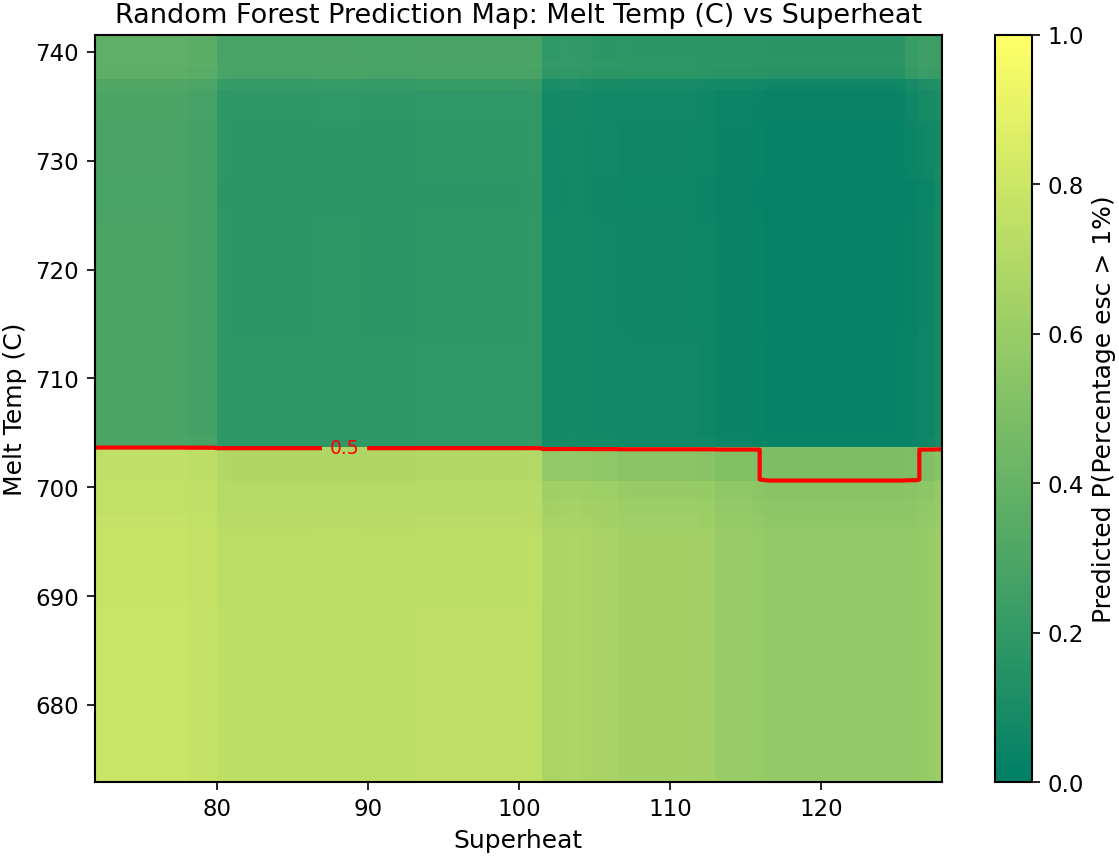


Plotting map: y = 'Superheat', x = 'Vacuum (mbar)'


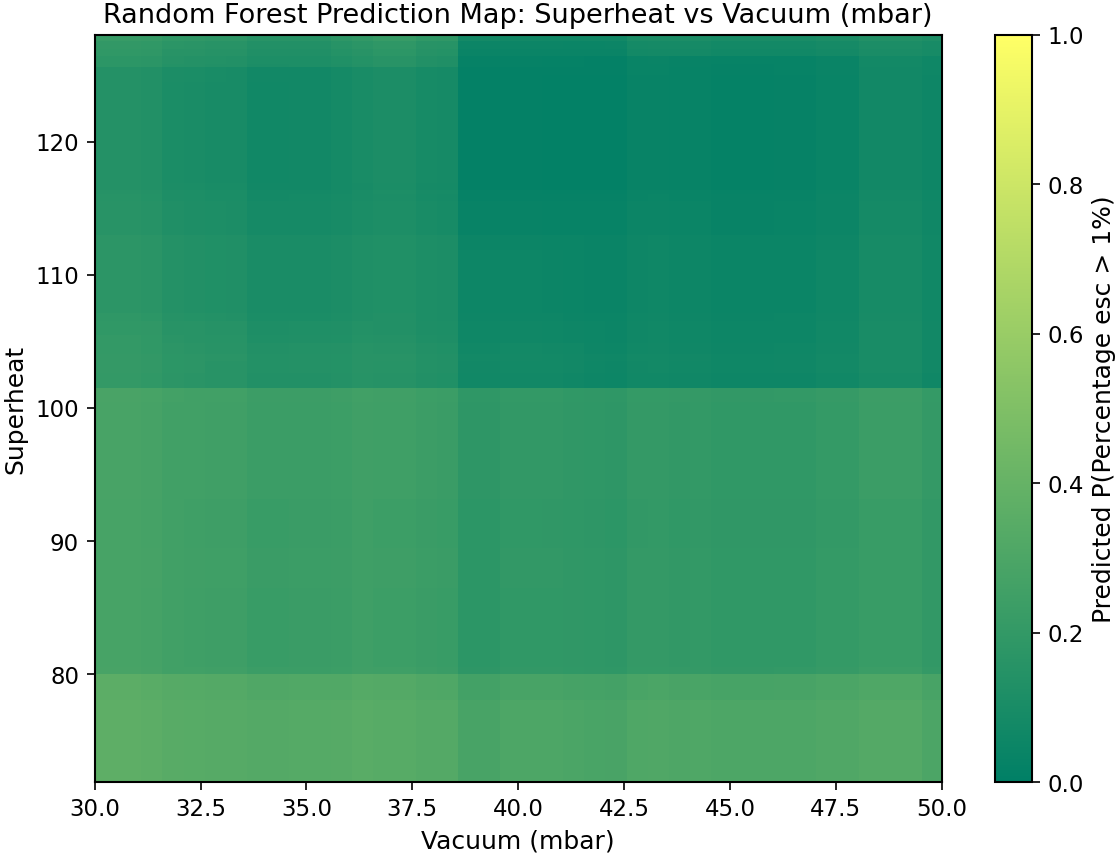


Plotting map: y = 'Melt Temp (C)', x = 'Vacuum (mbar)'


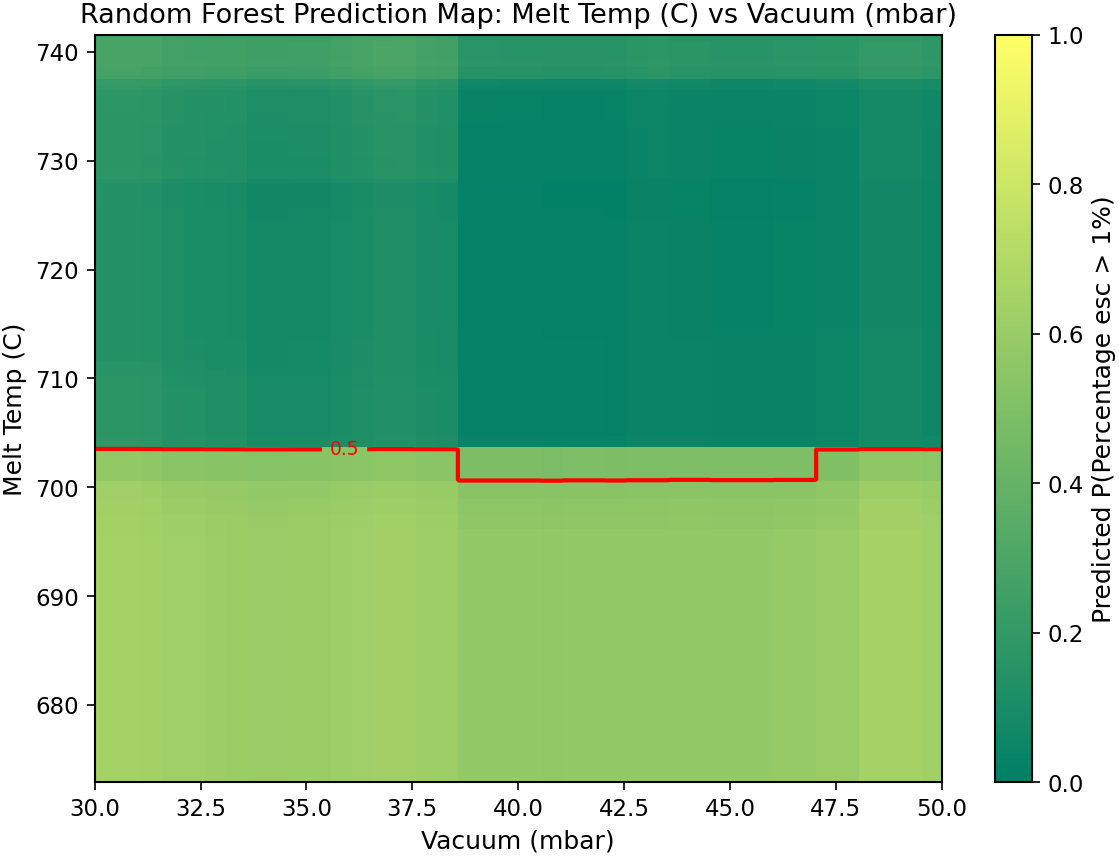

In [ ]:
# =============== Random Forest Prediction Maps (3-feature, 3 pairs) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# ---- Get the fitted RF pipeline and feature names ----
if 'best_pipe_rf' in globals():
    rf_pipe = best_pipe_rf
elif 'gs_rf' in globals():
    rf_pipe = gs_rf.best_estimator_
else:
    raise ValueError("No trained Random Forest found. Run the RF CV cell to create best_pipe_rf or gs_rf first.")

# X must be the same feature set used to train rf_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
rf = rf_pipe.named_steps["clf"]

# ---- Choose the three features to sweep ----
importances = getattr(rf, "feature_importances_", None)
if importances is None:
    raise ValueError("RandomForest has no feature_importances_ (unexpected).")

top3_idx = np.argsort(importances)[::-1][:3]
feat1 = feature_names[top3_idx[0]]
feat2 = feature_names[top3_idx[1]]
feat3 = feature_names[top3_idx[2]]

# # Option B (manual override): uncomment and set three feature names present in X
feat1 = "Melt Temp (C)"
feat2 = "Superheat"
feat3 = "Vacuum (mbar)"

print("Prediction map features (top 3):")
print(f"  Feature 1: {feat1}")
print(f"  Feature 2: {feat2}")
print(f"  Feature 3: {feat3}")

# ---- Helper: robust range for each feature ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    lo, hi = np.percentile(col.dropna().values, [q_low, q_high])
    if lo == hi:
        v = float(lo)
        eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

# Fixed settings
n_points = 201  # resolution per axis
base = X.median(numeric_only=True)    # default values for non-swept features
class_idx = 1 if (hasattr(rf, "classes_") and 1 in rf.classes_) else 0

pairs = [
    (feat1, feat2),
    (feat2, feat3),
    (feat1, feat3)
]

for (feat_i, feat_ii) in pairs:
    print(f"\nPlotting map: y = '{feat_i}', x = '{feat_ii}'")

    # ---- Define ranges for the two swept features ----
    lo_i,  hi_i  = _range_for(X[feat_i])
    lo_ii, hi_ii = _range_for(X[feat_ii])

    # ---- Build grid ----
    grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep
    grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep
    II, I   = np.meshgrid(grid_ii, grid_i)          # II: x-grid, I: y-grid

    # ---- Create DataFrame for all grid points ----
    grid_df = pd.DataFrame(
        np.tile(base.values, (n_points * n_points, 1)),
        columns=feature_names
    )

    # Set the two swept features
    grid_df[feat_i]  = I.ravel()
    grid_df[feat_ii] = II.ravel()

    # ---- Predict probability over the grid ----
    probs = rf_pipe.predict_proba(grid_df)[:, class_idx]
    Z = probs.reshape(n_points, n_points)

    # ---- Plot ----
    plt.figure(figsize=(8, 6), dpi=150)
    im = plt.imshow(
        Z,
        extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
        origin='lower',
        aspect='auto',
        cmap='summer',
        vmin=0.0,
        vmax=1.0
    )
    plt.colorbar(im, label="Predicted P(Percentage esc > 1%)")

    # 0.5 decision contour
    cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
    plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

    plt.xlabel(feat_ii)
    plt.ylabel(feat_i)
    plt.title(f"Random Forest Prediction Map: {feat_i} vs {feat_ii}")
    plt.tight_layout()
    plt.show()


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params (LogReg): {'clf__C': 1}
Best 5-fold CV F1 (LogReg): 0.7047619047619047

Classification report (5-fold OOF, LogReg):
              precision    recall  f1-score   support

           0      0.905     0.966     0.934        59
           1      0.833     0.625     0.714        16

    accuracy                          0.893        75
   macro avg      0.869     0.796     0.824        75
weighted avg      0.890     0.893     0.887        75



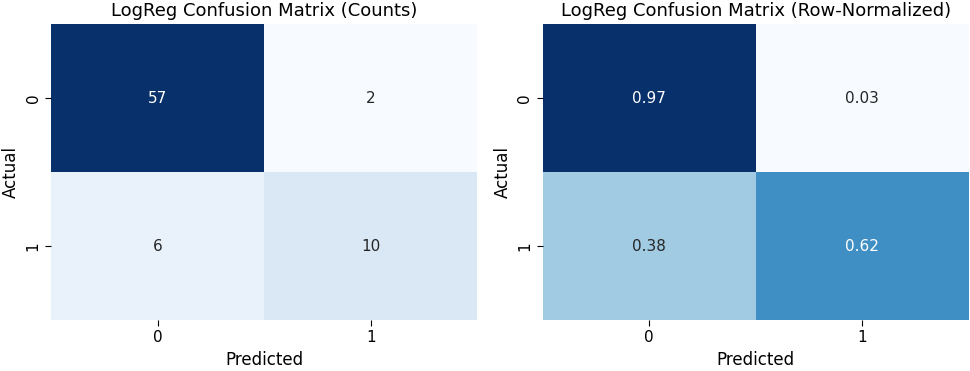

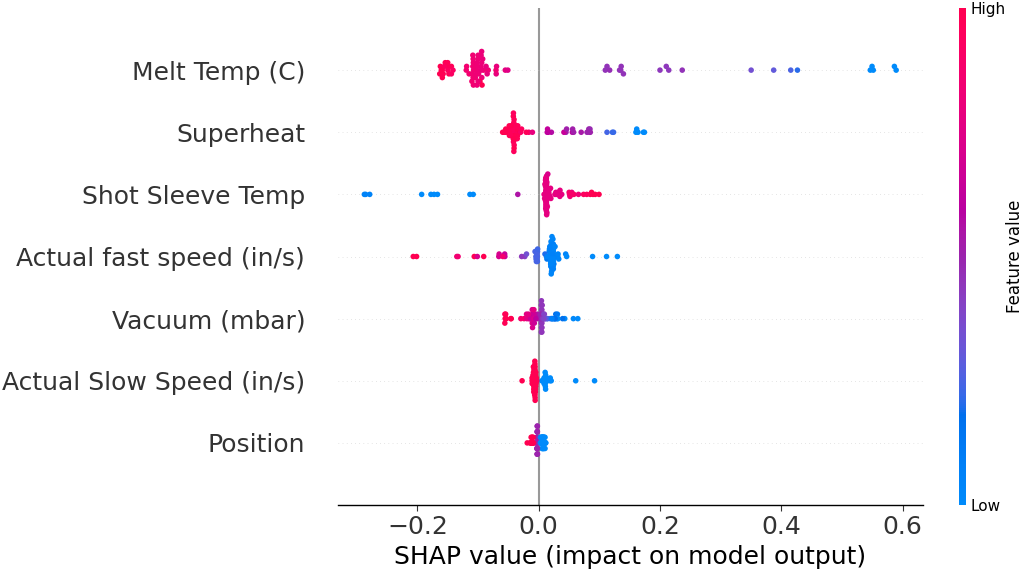

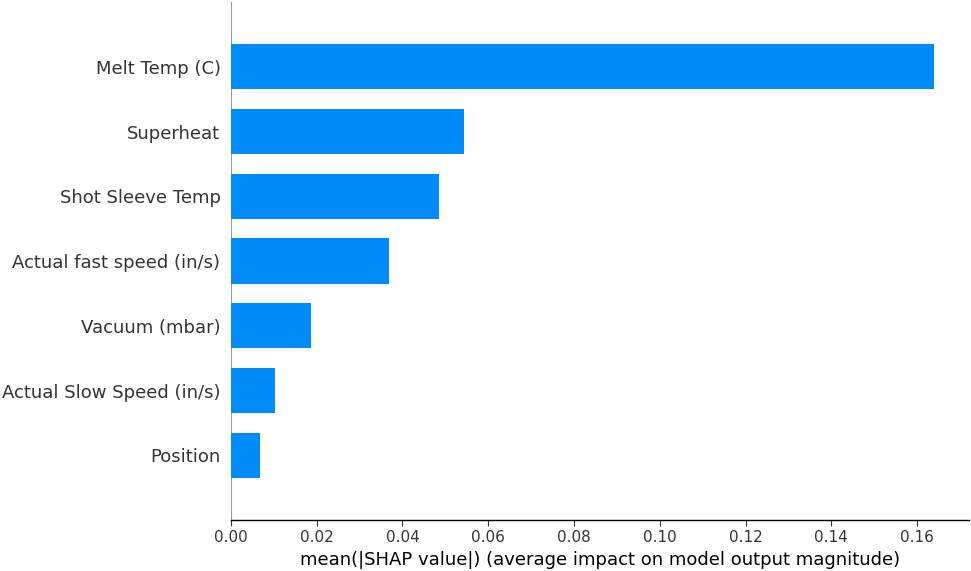

<Figure size 640x480 with 0 Axes>

In [16]:
# =============== Logistic Regression (scaled, 5-fold CV) + Confusion Matrix + SHAP ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# -------- Prepare X, y --------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Ensure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

pipe_log = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", random_state=111))
])

param_grid_log = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    # "clf__class_weight": [None, "balanced"],  # <- uncomment if classes are imbalanced
}

gs_log = GridSearchCV(
    estimator=pipe_log,
    param_grid=param_grid_log,
    scoring="f1",                  # alternatives: "f1_macro", "roc_auc", "balanced_accuracy"
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs_log.fit(X, y)
best_pipe_log = gs_log.best_estimator_
print("Best params (LogReg):", gs_log.best_params_)
print("Best 5-fold CV F1 (LogReg):", gs_log.best_score_)

# -------- Out-of-fold predictions for evaluation --------
oof_pred_log = cross_val_predict(best_pipe_log, X, y, cv=cv, method="predict")
print("\nClassification report (5-fold OOF, LogReg):")
print(classification_report(y, oof_pred_log, digits=3))

# Confusion matrices (counts + normalized)
cm_log  = confusion_matrix(y, oof_pred_log)
cmn_log = confusion_matrix(y, oof_pred_log, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_log,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("LogReg Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn_log, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("LogReg Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# -------- SHAP global importance (function-based explainer) --------
# Use pipeline's predict_proba so imputation+scaling are included (no leakage).
background_raw = X.sample(min(200, len(X)), random_state=111)
explainer_log = shap.Explainer(best_pipe_log.predict_proba, background_raw)
sv_log = explainer_log(X)

# Positive class index
clf_log = best_pipe_log.named_steps["clf"]
class_idx = 1 if (hasattr(clf_log, "classes_") and 1 in clf_log.classes_) else 0

# Beeswarm (global importance for P(class=1))
shap.summary_plot(
    sv_log[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()

# Increase tick label sizes
ax.tick_params(axis='both', labelsize=18)

# Increase axis label size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout(); plt.show()

# Bar chart of mean |SHAP|
shap.summary_plot(
    sv_log[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout(); plt.show()


Prediction map features (LogReg): y-axis = 'Actual fast speed (in/s)', x-axis = 'Melt Temp (C)'


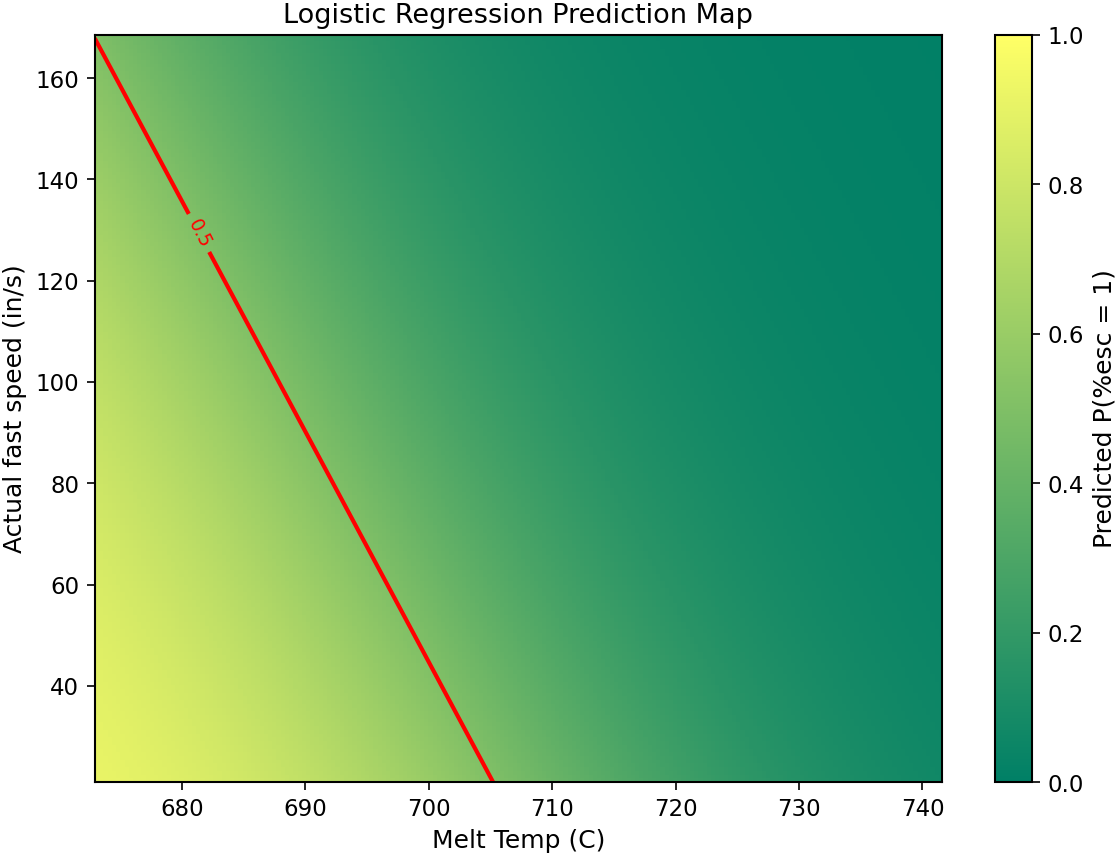

In [17]:
# =============== Logistic Regression Prediction Map (2-feature sweep) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Get the fitted LogReg pipeline and feature names ----
if 'best_pipe_log' in globals():
    log_pipe = best_pipe_log
elif 'gs_log' in globals():
    log_pipe = gs_log.best_estimator_
else:
    raise ValueError("No trained Logistic Regression found. Run the LogReg CV cell to create best_pipe_log or gs_log.")

# X must be the same feature set used to train log_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
log_clf = log_pipe.named_steps["clf"]

# ---- Choose the two features to sweep ----
# Option A: auto-pick top-2 by absolute coefficient magnitude (on scaled features)
coefs = np.ravel(log_clf.coef_)  # shape (n_features,)
top2_idx = np.argsort(np.abs(coefs))[::-1][:2]
feat_i  = feature_names[top2_idx[0]]   # y-axis in plot
feat_ii = feature_names[top2_idx[1]]   # x-axis in plot

# Option B (manual override): uncomment and set two feature names present in X
feat_i  = "Actual fast speed (in/s)"
feat_ii = "Melt Temp (C)"

print(f"Prediction map features (LogReg): y-axis = '{feat_i}', x-axis = '{feat_ii}'")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo)
        eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

lo_i,  hi_i  = _range_for(X[feat_i])
lo_ii, hi_ii = _range_for(X[feat_ii])

# ---- Build a grid ----
n_points = 201  # resolution per axis
grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
II, I = np.meshgrid(grid_ii, grid_i)            # II: x-grid, I: y-grid

# ---- Create a DataFrame of all grid points with other features fixed to median ----
base = X.median(numeric_only=True)    # default values for non-swept features
grid_df = pd.DataFrame(
    np.tile(base.values, (n_points * n_points, 1)),
    columns=feature_names
)
grid_df[feat_i]  = I.ravel()
grid_df[feat_ii] = II.ravel()

# ---- Predict probability of class 1 over the grid ----
class_idx = 1 if (hasattr(log_clf, "classes_") and 1 in log_clf.classes_) else 0
probs = log_pipe.predict_proba(grid_df)[:, class_idx]  # shape (n_points^2,)
Z = probs.reshape(n_points, n_points)

# ---- Plot the prediction map ----
plt.figure(figsize=(8, 6), dpi=150)
im = plt.imshow(
    Z,
    extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
    origin='lower',
    aspect='auto',
    cmap='summer',  # similar to your example
    vmin=0.0,   # force lower limit
    vmax=1.0    # force upper limit
)
plt.colorbar(im, label="Predicted P(%esc = 1)")

# 0.5 decision contour
cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

plt.xlabel(feat_ii)
plt.ylabel(feat_i)
plt.title("Logistic Regression Prediction Map")
plt.tight_layout()
plt.show()

# ---- (Optional) Save the figure ----
# plt.savefig("logreg_prediction_map.png", dpi=300, bbox_inches="tight")
# plt.savefig("logreg_prediction_map.pdf", bbox_inches="tight")



Prediction map features (top 3):
  Feature 1: Melt Temp (C)
  Feature 2: Superheat
  Feature 3: Shot Sleeve Temp

Plotting LogReg map: y = 'Melt Temp (C)', x = 'Superheat'


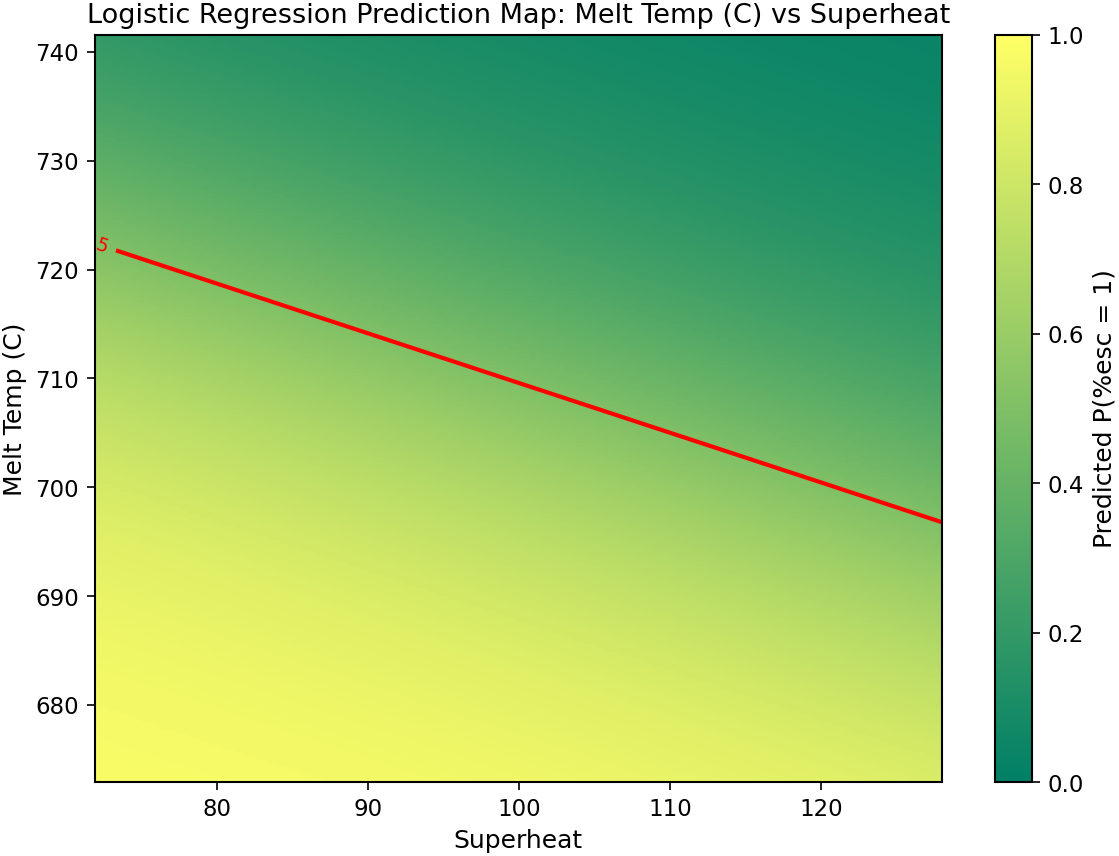


Plotting LogReg map: y = 'Superheat', x = 'Shot Sleeve Temp'


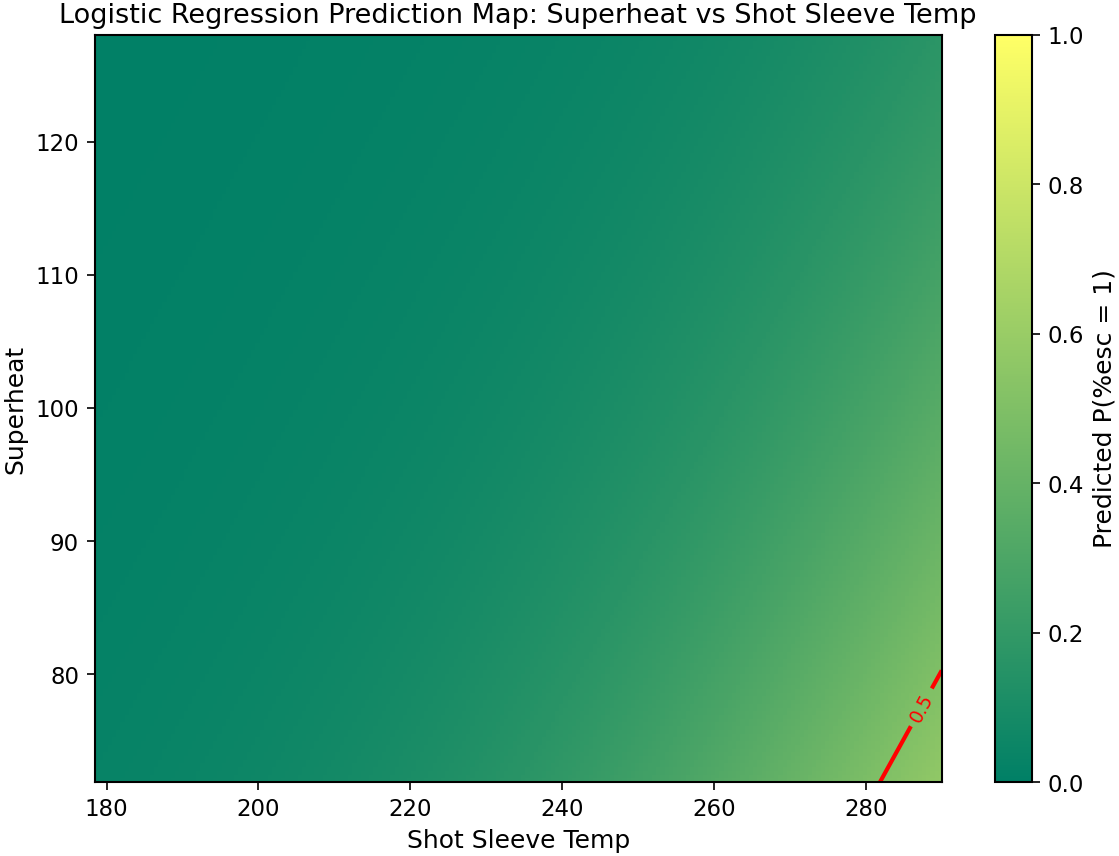


Plotting LogReg map: y = 'Melt Temp (C)', x = 'Shot Sleeve Temp'


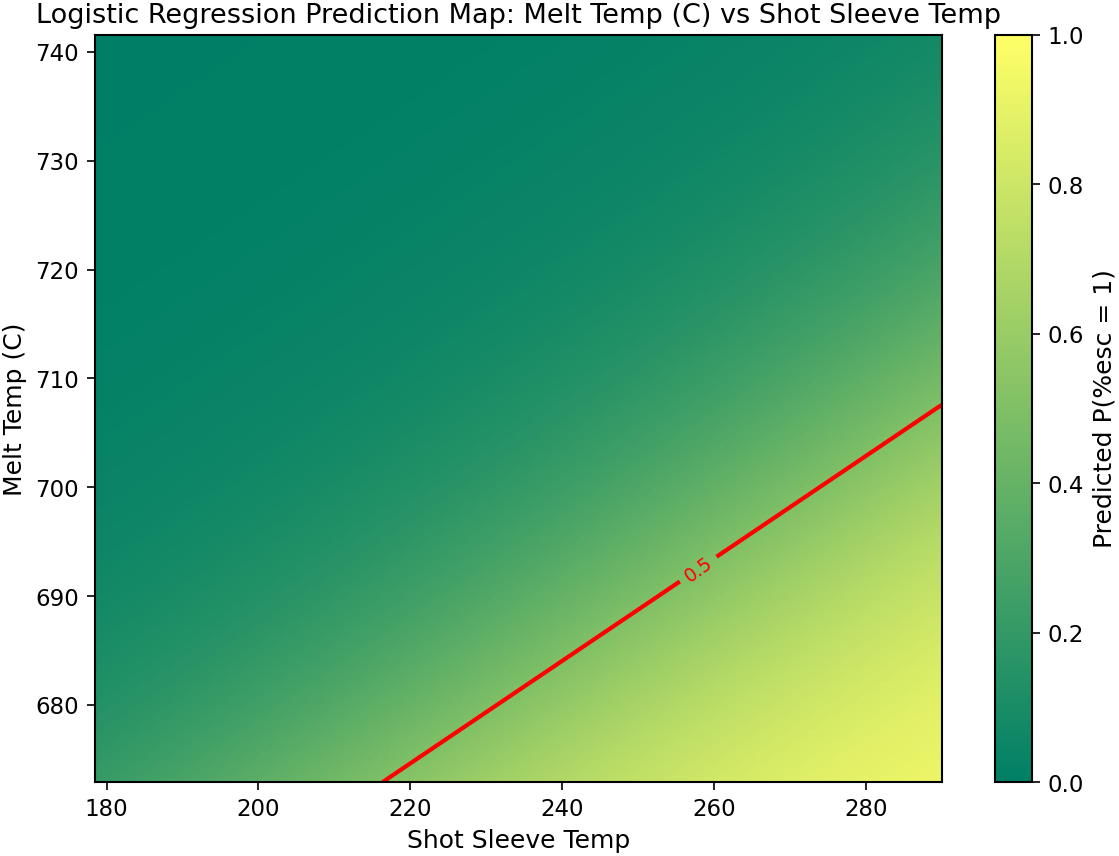

In [18]:
# =============== Logistic Regression Prediction Maps (3-feature, 3 pairs) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Get the fitted LogReg pipeline and feature names ----
if 'best_pipe_log' in globals():
    log_pipe = best_pipe_log
elif 'gs_log' in globals():
    log_pipe = gs_log.best_estimator_
else:
    raise ValueError("No trained Logistic Regression found. Run the LogReg CV cell to create best_pipe_log or gs_log.")

# X must be the same feature set used to train log_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
log_clf = log_pipe.named_steps["clf"]

# ---- Choose the three features to sweep ----
# Option A: auto-pick top-3 by absolute coefficient magnitude (on scaled features)
coefs = np.ravel(log_clf.coef_)  # shape (n_features,)
top3_idx = np.argsort(np.abs(coefs))[::-1][:3]
feat1 = feature_names[top3_idx[0]]
feat2 = feature_names[top3_idx[1]]
feat3 = feature_names[top3_idx[2]]

# # Option B (manual override): uncomment and set three feature names present in X
feat1 = "Melt Temp (C)"
feat2 = "Superheat"
feat3 = "Shot Sleeve Temp"

print("Prediction map features (top 3):")
print(f"  Feature 1: {feat1}")
print(f"  Feature 2: {feat2}")
print(f"  Feature 3: {feat3}")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo)
        eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

# Fixed settings
n_points = 201  # resolution per axis
base = X.median(numeric_only=True)    # default values for non-swept features
class_idx = 1 if (hasattr(log_clf, "classes_") and 1 in log_clf.classes_) else 0

pairs = [
    (feat1, feat2),
    (feat2, feat3),
    (feat1, feat3)
]

for (feat_i, feat_ii) in pairs:
    print(f"\nPlotting LogReg map: y = '{feat_i}', x = '{feat_ii}'")

    # ---- Define ranges for the two swept features ----
    lo_i,  hi_i  = _range_for(X[feat_i])
    lo_ii, hi_ii = _range_for(X[feat_ii])

    # ---- Build a grid ----
    grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
    grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
    II, I   = np.meshgrid(grid_ii, grid_i)          # II: x-grid, I: y-grid

    # ---- Create a DataFrame of all grid points with other features fixed to median ----
    grid_df = pd.DataFrame(
        np.tile(base.values, (n_points * n_points, 1)),
        columns=feature_names
    )
    grid_df[feat_i]  = I.ravel()
    grid_df[feat_ii] = II.ravel()

    # ---- Predict probability of class 1 over the grid ----
    probs = log_pipe.predict_proba(grid_df)[:, class_idx]  # shape (n_points^2,)
    Z = probs.reshape(n_points, n_points)

    # ---- Plot the prediction map ----
    plt.figure(figsize=(8, 6), dpi=150)
    im = plt.imshow(
        Z,
        extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
        origin='lower',
        aspect='auto',
        cmap='summer',
        vmin=0.0,
        vmax=1.0
    )
    plt.colorbar(im, label="Predicted P(%esc = 1)")

    # 0.5 decision contour
    cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
    plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

    plt.xlabel(feat_ii)
    plt.ylabel(feat_i)
    plt.title(f"Logistic Regression Prediction Map: {feat_i} vs {feat_ii}")
    plt.tight_layout()
    plt.show()

    # # (Optional) Save each figure, if you want:
    # plt.savefig(f"logreg_prediction_map_{feat_i}_vs_{feat_ii}.png", dpi=300, bbox_inches="tight")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params (MLP): {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (32,), 'clf__learning_rate_init': 0.001, 'clf__solver': 'adam'}
Best 5-fold CV score (f1): 0.6914

Classification report (5-fold OOF, best MLP):
              precision    recall  f1-score   support

           0      0.903     0.949     0.926        59
           1      0.769     0.625     0.690        16

    accuracy                          0.880        75
   macro avg      0.836     0.787     0.808        75
weighted avg      0.875     0.880     0.875        75



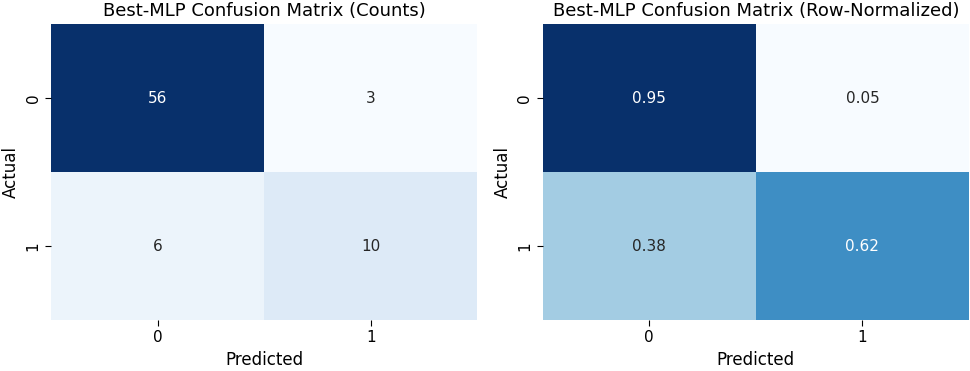

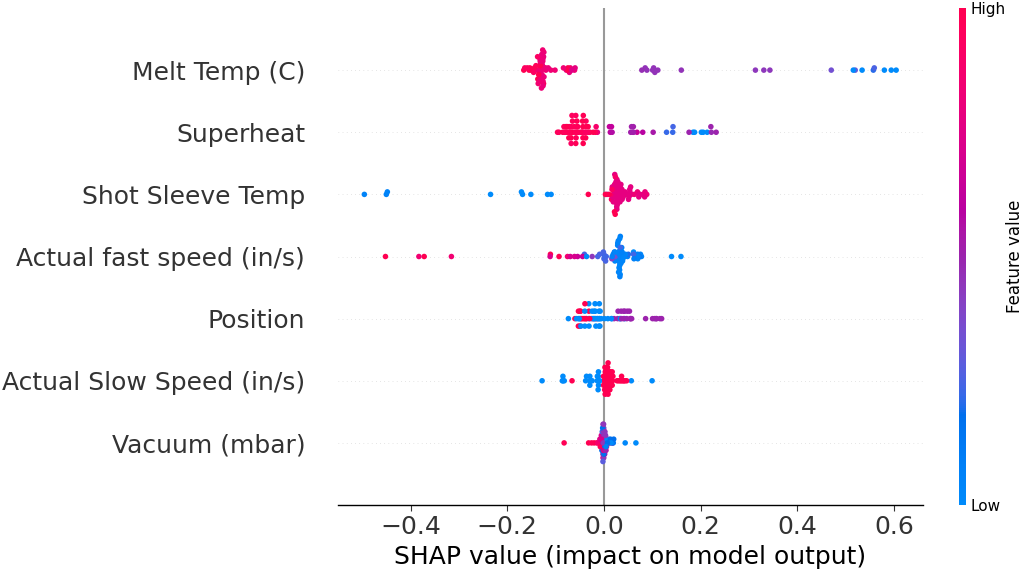

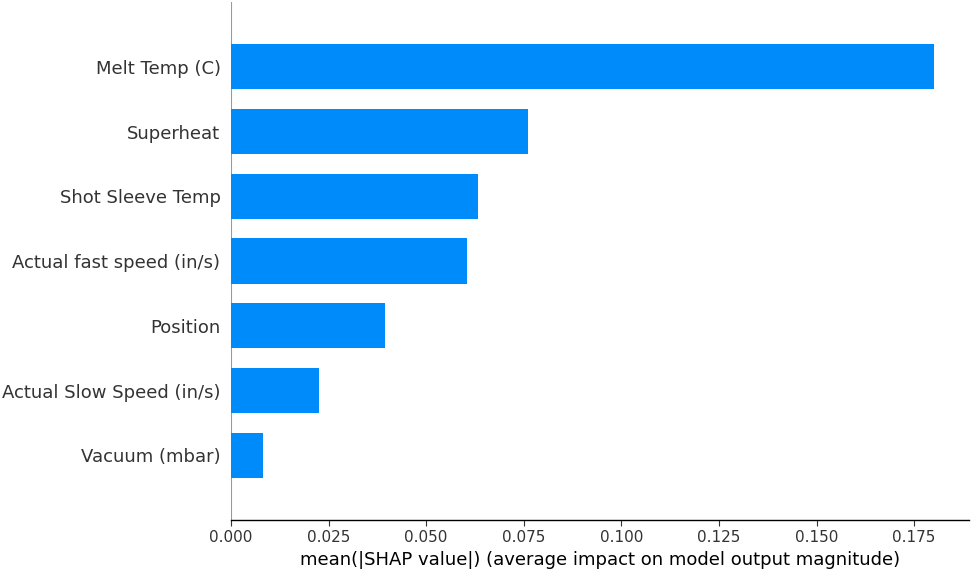

<Figure size 640x480 with 0 Axes>

rank_test_score  mean_test_score  std_test_score  \
3                 1         0.691429        0.189675   
15                1         0.691429        0.189675   
27                1         0.691429        0.189675   
9                 4         0.681905        0.207750   
21                4         0.681905        0.207750   
33                4         0.681905        0.207750   
12                7         0.664762        0.181743   
24                7         0.664762        0.181743   
0                 7         0.664762        0.181743   
30               10         0.655238        0.199264   
25               10         0.655238        0.199264   
18               10         0.655238        0.199264   
16               10         0.655238        0.199264   
6                10         0.655238        0.199264   
4                10         0.655238        0.199264   
28               10         0.655238        0.199264   
17               17         0.601905        0.223304   
23               17         0.601905        0.223304   
22               17         0.601905        0.223304   
19               17         0.601905        0.223304   

   param_clf__hidden_layer_sizes  param_clf__alpha  \
3                          (32,)            0.0001   
15                         (32,)            0.0010   
27                         (32,)            0.0100   
9                       (64, 32)            0.0001   
21                      (64, 32)            0.0010   
33                      (64, 32)            0.0100   
12                         (16,)            0.0010   
24                         (16,)            0.0100   
0                          (16,)            0.0001   
30                      (32, 16)            0.0100   
25                         (16,)            0.0100   
18                      (32, 16)            0.0010   
16                         (32,)            0.0010   
6                       (32, 16)            0.0001   
4                          (32,)            0.0001   
28                         (32,)            0.0100   
17                         (32,)            0.0010   
23                      (64, 32)            0.0010   
22                      (64, 32)            0.0010   
19                      (32, 16)            0.0010   

    param_clf__learning_rate_init  
3                           0.001  
15                          0.001  
27                          0.001  
9                           0.001  
21                          0.001  
33                          0.001  
12                          0.001  
24                          0.001  
0                           0.001  
30                          0.001  
25                          0.003  
18                          0.001  
16                          0.003  
6                           0.001  
4                           0.003  
28                          0.003  
17                          0.010  
23                          0.010  
22                          0.003  
19                          0.003

In [26]:
# =============== Best-MLP (GridSearchCV) -> OOF Eval (CM) -> SHAP (best model) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# -------------------- Prepare X, y --------------------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Ensure you have full_df with a '%esc' column or define X, y earlier.")

# (Optional but recommended) ensure numeric columns only
# X = X.select_dtypes(include=[np.number]).copy()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

# -------------------- Pipeline --------------------
pipe_mlp = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(max_iter=2000, random_state=111))
])

# -------------------- Hyperparameter search grid --------------------
param_grid = {
    "clf__hidden_layer_sizes": [(16,), (32,), (32,16), (64,32)],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
    "clf__learning_rate_init": [1e-3, 3e-3, 1e-2],
    "clf__activation": ["relu"],
    "clf__solver": ["adam"],
}

# -------------------- GridSearchCV: find best hyperparameters --------------------
gs = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid,
    scoring="f1",        # change to "accuracy" if you want to match cell 2's metric
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)
gs.fit(X, y)

best_pipe = gs.best_estimator_
print("Best params (MLP):", gs.best_params_)
print(f"Best 5-fold CV score ({gs.scoring}): {gs.best_score_:.4f}")

# -------------------- OOF predictions (evaluation) using best hyperparams --------------------
oof_pred = cross_val_predict(best_pipe, X, y, cv=cv, method="predict")
print("\nClassification report (5-fold OOF, best MLP):")
print(classification_report(y, oof_pred, digits=3))

cm  = confusion_matrix(y, oof_pred)
cmn = confusion_matrix(y, oof_pred, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Best-MLP Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("Best-MLP Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# -------------------- SHAP (best model) --------------------
# Fit best model once on full data for SHAP explanations (common practice for global explanation)
best_pipe.fit(X, y)

# Use pipeline's predict_proba so impute+scale are included
background_raw = X.sample(min(200, len(X)), random_state=111)
explainer = shap.Explainer(best_pipe.predict_proba, background_raw)
sv = explainer(X)

# Positive class index
clf = best_pipe.named_steps["clf"]
class_idx = 1 if (hasattr(clf, "classes_") and 1 in clf.classes_) else 0

# Beeswarm (global importance for P(class=1))
shap.summary_plot(
    sv[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout()
plt.show()

# Bar chart of mean |SHAP|
shap.summary_plot(
    sv[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout()
plt.show()

# -------------------- (Optional) export full CV results table --------------------
results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
keep_cols = [
    "rank_test_score", "mean_test_score", "std_test_score",
    "param_clf__hidden_layer_sizes", "param_clf__alpha",
]
if "param_clf__learning_rate_init" in results.columns:
    keep_cols.append("param_clf__learning_rate_init")
display(results[keep_cols].head(20))


Prediction map features (MLP): y-axis = 'Superheat', x-axis = 'Melt Temp (C)'


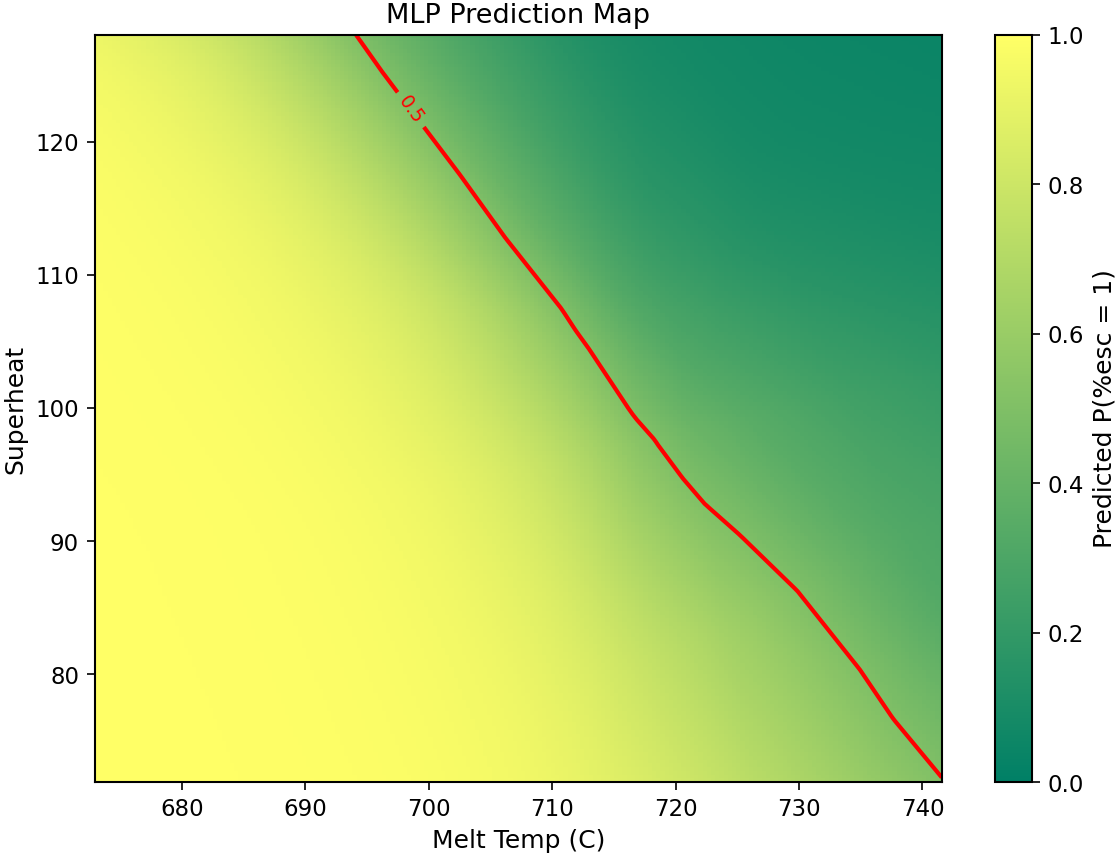

In [27]:
# =============== MLP (Neural Net) Prediction Map (2-feature sweep) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Get the fitted MLP pipeline and feature names ----
if 'best_pipe_mlp' in globals():
    mlp_pipe = best_pipe_mlp
elif 'best_pipe' in globals():                 # <-- added (my combined-cell variable)
    mlp_pipe = best_pipe
elif 'gs_mlp' in globals():
    mlp_pipe = gs_mlp.best_estimator_
elif 'gs' in globals():                        # <-- added (if you used my GridSearch variable name)
    mlp_pipe = gs.best_estimator_
else:
    raise ValueError(
        "No trained MLP found. Run the MLP tuning/training cell first so best_pipe (or best_pipe_mlp / gs / gs_mlp) exists."
    )


# X must be the same feature set used to train mlp_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
mlp_clf = mlp_pipe.named_steps["clf"]

# ---- Choose the two features to sweep ----
# Use the L1 norm of input-layer weights as a feature-importance proxy.
def pick_top2_by_input_weights(clf, X, feature_names):
    if hasattr(clf, "coefs_") and len(clf.coefs_) >= 1:
        W = clf.coefs_[0]  # shape: (n_features, n_hidden)
        imps = np.sum(np.abs(W), axis=1)  # importance per input feature
        top2_idx = np.argsort(imps)[::-1][:2]
        return feature_names[top2_idx[0]], feature_names[top2_idx[1]]
    # Fallback: top-variance features
    var = X.var().values
    top2_idx = np.argsort(var)[::-1][:2]
    return feature_names[top2_idx[0]], feature_names[top2_idx[1]]

#feat_i, feat_ii = pick_top2_by_input_weights(mlp_clf, X, feature_names)  # y-axis, x-axis
# (Optional manual override)
feat_i  = "Superheat"
feat_ii = "Melt Temp (C)"

print(f"Prediction map features (MLP): y-axis = '{feat_i}', x-axis = '{feat_ii}'")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo); eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

lo_i,  hi_i  = _range_for(X[feat_i])
lo_ii, hi_ii = _range_for(X[feat_ii])

# ---- Build a grid ----
n_points = 201
grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
II, I = np.meshgrid(grid_ii, grid_i)

# ---- Create a DataFrame of all grid points with other features fixed to median ----
#base = X.median(numeric_only=True)
# Most frequent value (mode) per feature
base = X.mode(numeric_only=True).iloc[0]
grid_df = pd.DataFrame(
    np.tile(base.values, (n_points * n_points, 1)),
    columns=feature_names
)
grid_df[feat_i]  = I.ravel()
grid_df[feat_ii] = II.ravel()

# ---- Predict probability of class 1 over the grid ----
class_idx = 1 if (hasattr(mlp_clf, "classes_") and 1 in mlp_clf.classes_) else 0
probs = mlp_pipe.predict_proba(grid_df)[:, class_idx]
Z = probs.reshape(n_points, n_points)

# ---- Plot the prediction map ----
plt.figure(figsize=(8, 6), dpi=150)
im = plt.imshow(
    Z,
    extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
    origin='lower',
    aspect='auto',
    cmap='summer',  # similar to your example
    vmin=0.0,   # force lower limit
    vmax=1.0    # force upper limit
)
plt.colorbar(im, label="Predicted P(%esc = 1)")

# 0.5 decision contour
cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

plt.xlabel(feat_ii)
plt.ylabel(feat_i)
plt.title("MLP Prediction Map")
plt.tight_layout()
plt.show()

# ---- (Optional) Save ----
# plt.savefig("mlp_prediction_map.png", dpi=300, bbox_inches="tight")
# plt.savefig("mlp_prediction_map.pdf", bbox_inches="tight")


Prediction map features (MLP, top 3):
  Feature 1: Melt Temp (C)
  Feature 2: Superheat
  Feature 3: Shot Sleeve Temp

Plotting MLP map: y = 'Melt Temp (C)', x = 'Superheat'


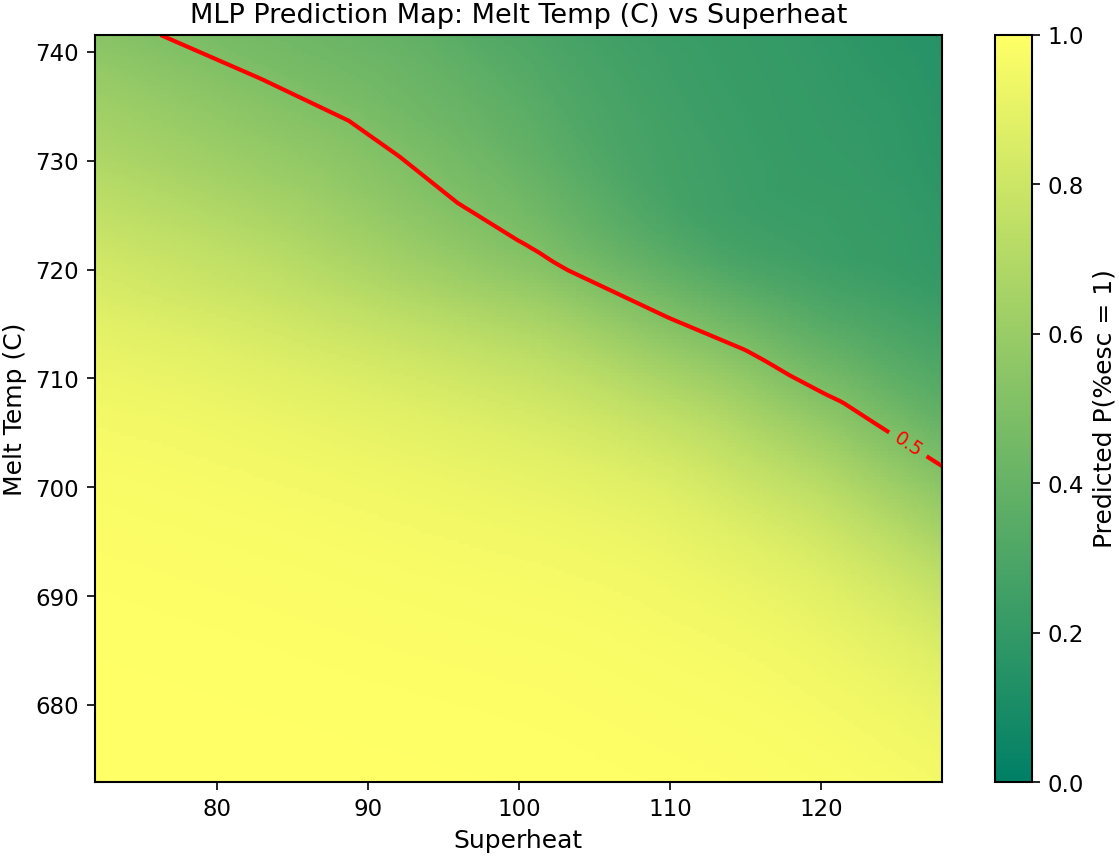


Plotting MLP map: y = 'Superheat', x = 'Shot Sleeve Temp'


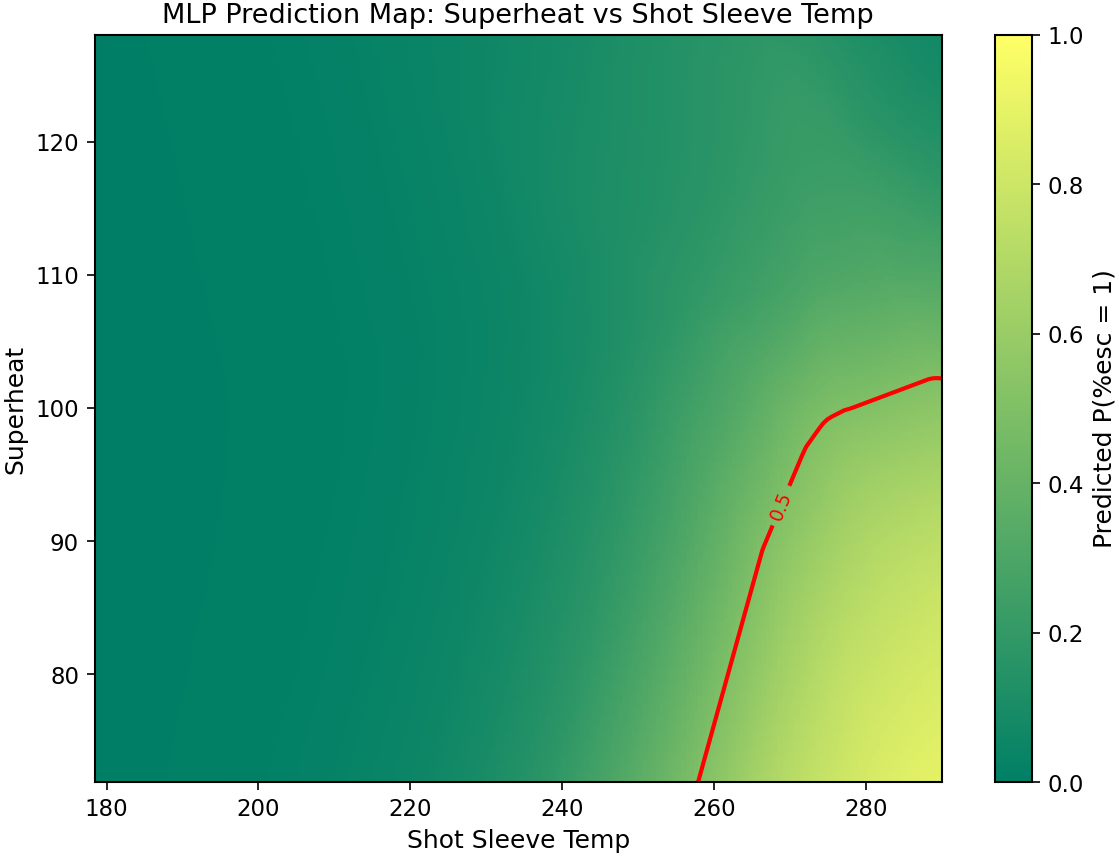


Plotting MLP map: y = 'Melt Temp (C)', x = 'Shot Sleeve Temp'


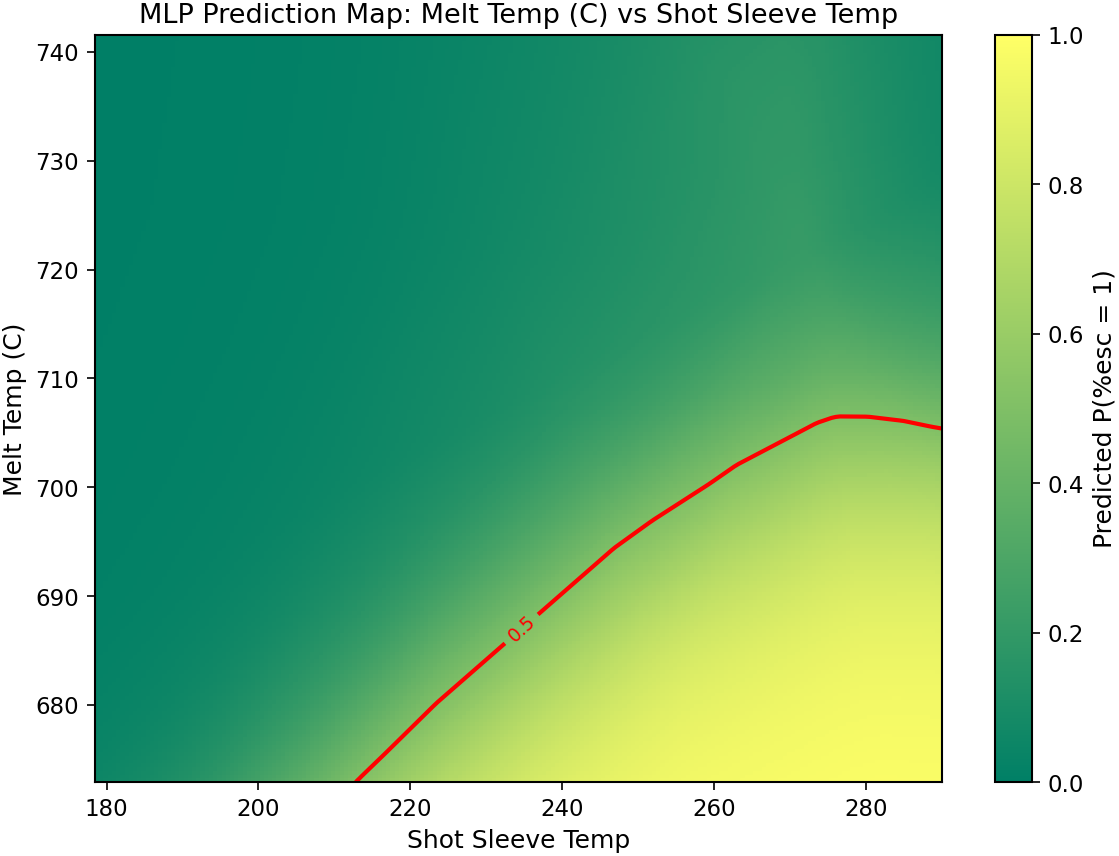

In [28]:
# =============== MLP (Neural Net) Prediction Maps (3-feature, 3 pairs) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Get the fitted MLP pipeline and feature names ----
if 'best_pipe_mlp' in globals():
    mlp_pipe = best_pipe_mlp
elif 'best_pipe' in globals():                 # <-- added (my combined-cell variable)
    mlp_pipe = best_pipe
elif 'gs_mlp' in globals():
    mlp_pipe = gs_mlp.best_estimator_
elif 'gs' in globals():                        # <-- added (if you used my GridSearch variable name)
    mlp_pipe = gs.best_estimator_
else:
    raise ValueError(
        "No trained MLP found. Run the MLP tuning/training cell first so best_pipe (or best_pipe_mlp / gs / gs_mlp) exists."
    )


# X must be the same feature set used to train mlp_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
mlp_clf = mlp_pipe.named_steps["clf"]

# ---- Choose the three features to sweep ----
# Use the L1 norm of input-layer weights as a feature-importance proxy.
def pick_top3_by_input_weights(clf, X, feature_names):
    if hasattr(clf, "coefs_") and len(clf.coefs_) >= 1:
        W = clf.coefs_[0]  # shape: (n_features, n_hidden)
        imps = np.sum(np.abs(W), axis=1)  # importance per input feature
        top3_idx = np.argsort(imps)[::-1][:3]
        return [feature_names[i] for i in top3_idx]
    # Fallback: top-variance features
    var = X.var().values
    top3_idx = np.argsort(var)[::-1][:3]
    return [feature_names[i] for i in top3_idx]

feat1, feat2, feat3 = pick_top3_by_input_weights(mlp_clf, X, feature_names)

# # (Optional manual override)
feat1 = "Melt Temp (C)"
feat2 = "Superheat"
feat3 = "Shot Sleeve Temp"

print("Prediction map features (MLP, top 3):")
print(f"  Feature 1: {feat1}")
print(f"  Feature 2: {feat2}")
print(f"  Feature 3: {feat3}")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo); eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

# Fixed settings
n_points = 201
base = X.median(numeric_only=True)
class_idx = 1 if (hasattr(mlp_clf, "classes_") and 1 in mlp_clf.classes_) else 0

pairs = [
    (feat1, feat2),
    (feat2, feat3),
    (feat1, feat3)
]

for (feat_i, feat_ii) in pairs:
    print(f"\nPlotting MLP map: y = '{feat_i}', x = '{feat_ii}'")

    # ---- Ranges ----
    lo_i,  hi_i  = _range_for(X[feat_i])
    lo_ii, hi_ii = _range_for(X[feat_ii])

    # ---- Build grid ----
    grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
    grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
    II, I   = np.meshgrid(grid_ii, grid_i)

    # ---- Create grid DataFrame with other features fixed to median ----
    grid_df = pd.DataFrame(
        np.tile(base.values, (n_points * n_points, 1)),
        columns=feature_names
    )
    grid_df[feat_i]  = I.ravel()
    grid_df[feat_ii] = II.ravel()

    # ---- Predict probability of class 1 ----
    probs = mlp_pipe.predict_proba(grid_df)[:, class_idx]
    Z = probs.reshape(n_points, n_points)

    # ---- Plot ----
    plt.figure(figsize=(8, 6), dpi=150)
    im = plt.imshow(
        Z,
        extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
        origin='lower',
        aspect='auto',
        cmap='summer',
        vmin=0.0,
        vmax=1.0
    )
    plt.colorbar(im, label="Predicted P(%esc = 1)")

    # 0.5 decision contour
    cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
    plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

    plt.xlabel(feat_ii)
    plt.ylabel(feat_i)
    plt.title(f"MLP Prediction Map: {feat_i} vs {feat_ii}")
    plt.tight_layout()
    plt.show()

    # # (Optional) Save each figure
    # plt.savefig(f"mlp_prediction_map_{feat_i}_vs_{feat_ii}.png", dpi=300, bbox_inches="tight")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params (SVM): {'clf__C': 10, 'clf__gamma': 'scale'}
Best 5-fold CV F1 (SVM): 0.7580952380952379

Classification report (5-fold OOF, SVM):
              precision    recall  f1-score   support

           0      0.919     0.966     0.942        59
           1      0.846     0.688     0.759        16

    accuracy                          0.907        75
   macro avg      0.883     0.827     0.850        75
weighted avg      0.904     0.907     0.903        75



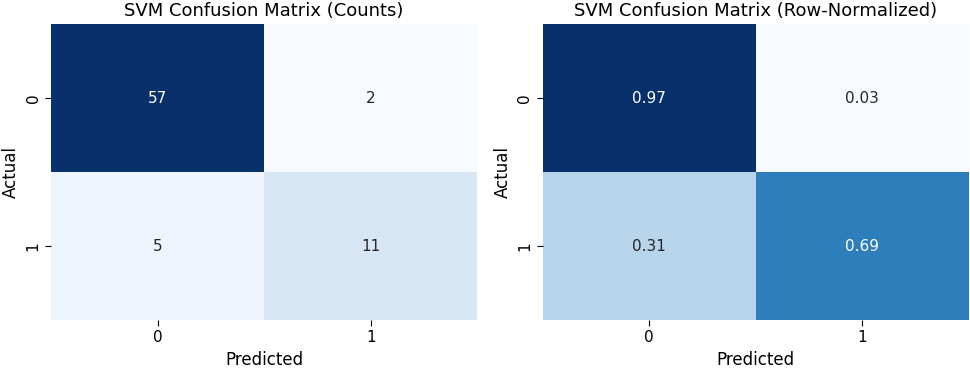

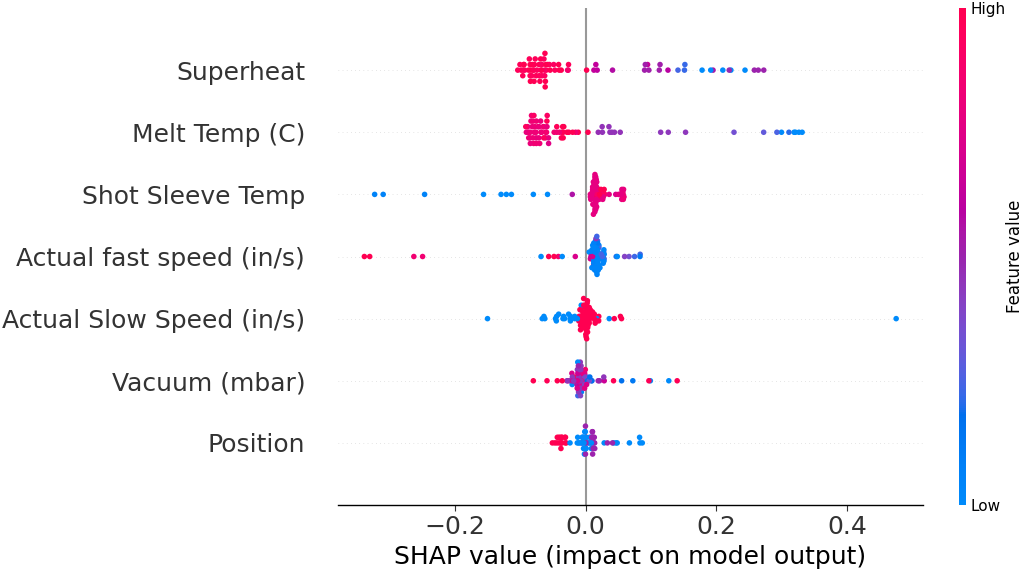

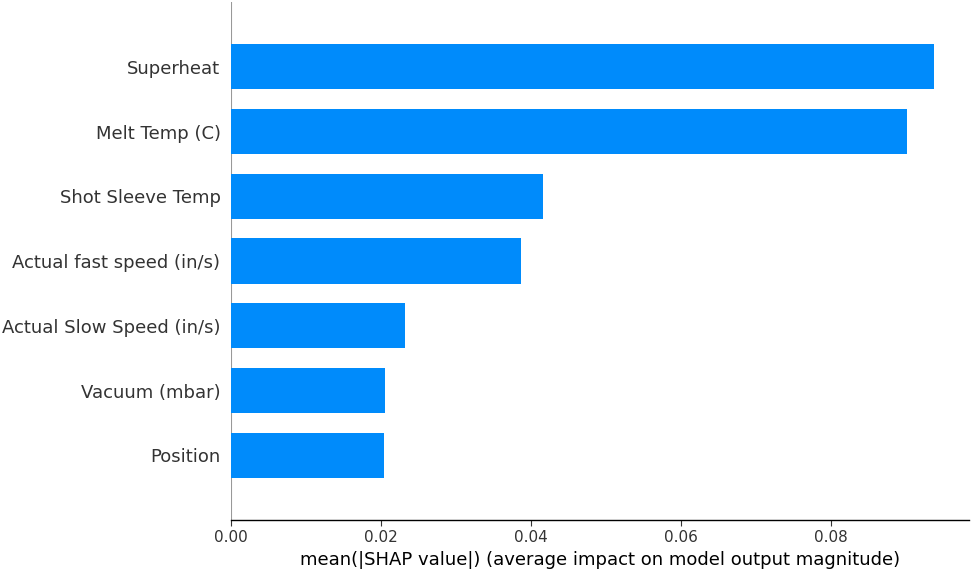

<Figure size 640x480 with 0 Axes>

In [ ]:
# =============== SVM (RBF, scaled, 5-fold CV) + Confusion Matrix + SHAP ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# -------- Prepare X, y --------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Ensure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=111))
])

param_grid_svm = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto", 0.1, 0.01],
    # "clf__class_weight": [None, "balanced"],  # <- uncomment if classes are imbalanced
}

gs_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid_svm,
    scoring="f1",                 # alternatives: "f1_macro", "roc_auc", "balanced_accuracy"
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs_svm.fit(X, y)
best_pipe_svm = gs_svm.best_estimator_
print("Best params (SVM):", gs_svm.best_params_)
print("Best 5-fold CV F1 (SVM):", gs_svm.best_score_)

# -------- Out-of-fold predictions for evaluation --------
oof_pred_svm = cross_val_predict(best_pipe_svm, X, y, cv=cv, method="predict")
print("\nClassification report (5-fold OOF, SVM):")
print(classification_report(y, oof_pred_svm, digits=3))

# Confusion matrices (counts + normalized)
cm_svm  = confusion_matrix(y, oof_pred_svm)
cmn_svm = confusion_matrix(y, oof_pred_svm, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_svm,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("SVM Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn_svm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("SVM Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# -------- SHAP global importance (function-based explainer) --------
# Use pipeline's predict_proba so impute+scale are included.
background_raw = X.sample(min(200, len(X)), random_state=111)
explainer_svm = shap.Explainer(best_pipe_svm.predict_proba, background_raw)
sv_svm = explainer_svm(X)

# Positive class index
clf_svm = best_pipe_svm.named_steps["clf"]
class_idx = 1 if (hasattr(clf_svm, "classes_") and 1 in clf_svm.classes_) else 0

# Beeswarm (global importance for P(class=1))
shap.summary_plot(
    sv_svm[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()

# Increase tick label sizes
ax.tick_params(axis='both', labelsize=18)

# Increase axis label size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout(); plt.show()

# Bar chart of mean |SHAP|
shap.summary_plot(
    sv_svm[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout(); plt.show()


In [ ]:
# =============== SVM (RBF) Hyperparameter Sweep (5-fold CV) with Accuracy Table ===============
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import clone

# -------- Prepare X, y (expects your combined dataset already built) --------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Make sure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

base_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=111))
])

# ---- Hyperparameters to sweep ----
# If you already ran a GridSearch (gs_svm), we center the sweep around its best C/gamma.
if 'gs_svm' in globals():
    best = gs_svm.best_params_
    base_C = float(best.get("clf__C", 1.0))
    best_gamma = best.get("clf__gamma", "scale")
else:
    base_C = 1.0
    best_gamma = "scale"

# Build ranges
C_list = sorted({max(base_C/10, 0.01), base_C, base_C*10, 100.0})
if isinstance(best_gamma, (int, float)):
    g_list = sorted({max(best_gamma/10, 1e-4), best_gamma, best_gamma*10})
else:
    # start broad if best was 'scale'/'auto'
    g_list = ["scale", "auto", 0.1, 0.01]

rows = []
run_no = 1

for C in C_list:
    for gamma in g_list:
        pipe = clone(base_pipe)
        pipe.set_params(clf__C=C, clf__gamma=gamma)

        # Cross-validate; also return fitted estimators so we can read support vectors
        scores = cross_validate(
            pipe, X, y, cv=cv,
            scoring="accuracy",           # use accuracy to match your example table
            n_jobs=-1,
            return_estimator=True,
            return_train_score=False
        )

        acc_mean = scores["test_score"].mean()
        acc_std  = scores["test_score"].std(ddof=1)
        fit_time_total = float(np.sum(scores["fit_time"]))

        # Avg total number of support vectors across folds
        n_sv_avg = float(np.mean([est.named_steps["clf"].n_support_.sum()
                                  for est in scores["estimator"]]))

        rows.append({
            "No.": run_no,
            "Predictor": "SVM (RBF)",
            "Kernel": "rbf",
            "C": C,
            "gamma": gamma,
            "Support Vectors (avg)": int(round(n_sv_avg)),
            "Accuracy (%)": f"{acc_mean*100:.2f}%",
            "Training Time (s)": round(fit_time_total, 1),
            # keep the raw numbers too if you want to sort later
            "_acc_raw": acc_mean,
            "_acc_std": acc_std,
        })
        run_no += 1

# ---- Make a publication-friendly table ----
tbl = pd.DataFrame(rows)
# Sort by accuracy descending, then C
tbl = tbl.sort_values(by=["_acc_raw","C"], ascending=[False, True]).reset_index(drop=True)
tbl_display = tbl[["No.", "Predictor", "Kernel", "C", "gamma",
                   "Support Vectors (avg)", "Accuracy (%)", "Training Time (s)"]]

print("SVM (RBF) 5-fold CV accuracy across hyperparameters:")
display(tbl_display)

# Optional: save results
# tbl_display.to_csv("svm_hyperparam_sweep_results.csv", index=False)


SVM (RBF) 5-fold CV accuracy across hyperparameters:


No.  Predictor Kernel      C  gamma  Support Vectors (avg) Accuracy (%)  \
0     5  SVM (RBF)    rbf   10.0  scale                     27       90.67%   
1     6  SVM (RBF)    rbf   10.0   auto                     27       90.67%   
2     7  SVM (RBF)    rbf   10.0    0.1                     25       90.67%   
3     1  SVM (RBF)    rbf    1.0  scale                     34       89.33%   
4     2  SVM (RBF)    rbf    1.0   auto                     34       89.33%   
5     3  SVM (RBF)    rbf    1.0    0.1                     29       89.33%   
6     8  SVM (RBF)    rbf   10.0   0.01                     22       89.33%   
7    12  SVM (RBF)    rbf  100.0   0.01                     19       89.33%   
8     9  SVM (RBF)    rbf  100.0  scale                     24       88.00%   
9    10  SVM (RBF)    rbf  100.0   auto                     24       88.00%   
10   11  SVM (RBF)    rbf  100.0    0.1                     21       86.67%   
11    4  SVM (RBF)    rbf    1.0   0.01                     27       85.33%   

    Training Time (s)  
0                 0.2  
1                 0.2  
2                 0.2  
3                 0.2  
4                 0.1  
5                 0.3  
6                 0.2  
7                 0.1  
8                 0.2  
9                 0.1  
10                0.1  
11                0.2

Prediction map features (SVM): y-axis = 'Superheat', x-axis = 'Melt Temp (C)'


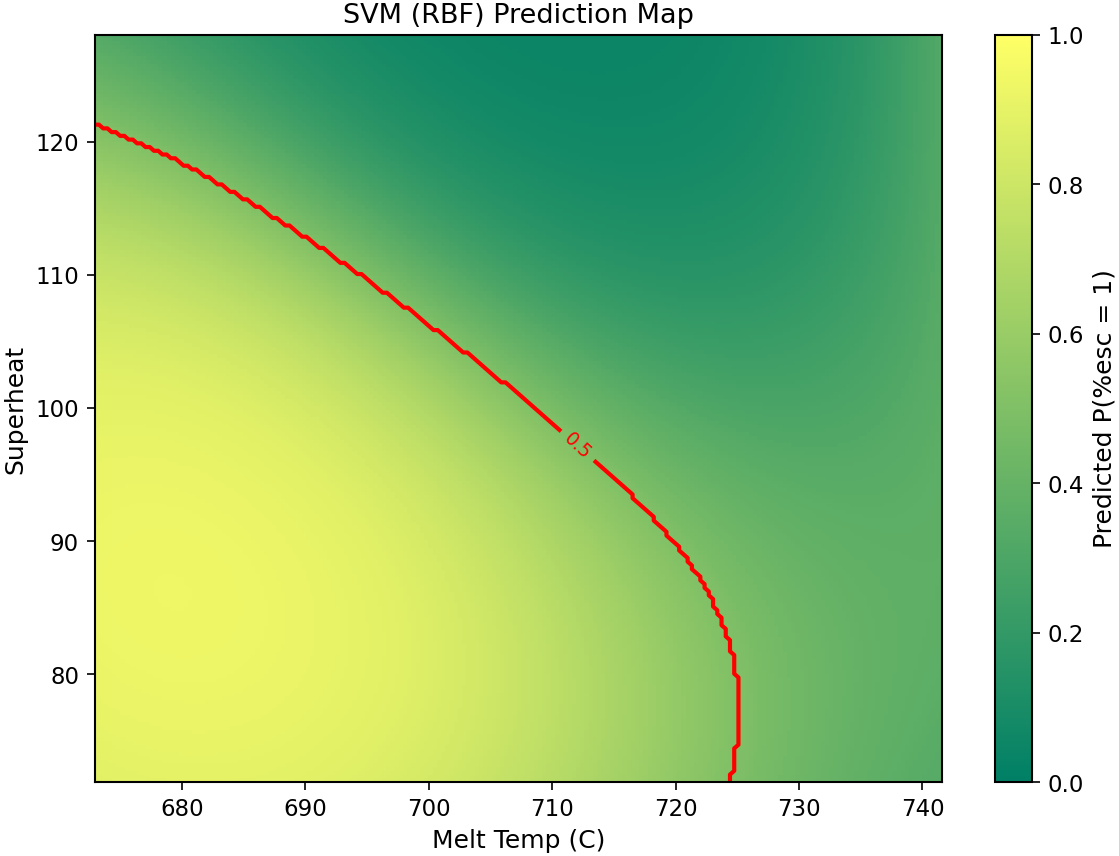

In [ ]:
# =============== SVM (RBF) Prediction Map (2-feature sweep) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ---- Get the fitted SVM pipeline and feature names ----
if 'best_pipe_svm' in globals():
    svm_pipe = best_pipe_svm
elif 'gs_svm' in globals():
    svm_pipe = gs_svm.best_estimator_
else:
    raise ValueError("No trained SVM found. Run the SVM CV cell to create best_pipe_svm or gs_svm first.")

# X must match the feature set used to train svm_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
svm_clf = svm_pipe.named_steps["clf"]
class_idx = 1 if (hasattr(svm_clf, "classes_") and 1 in svm_clf.classes_) else 0

# ---- Pick two features by SHAP (model-agnostic) ----
background = X.sample(min(200, len(X)), random_state=111)
explainer = shap.Explainer(svm_pipe.predict_proba, background)
sv = explainer(X)  # shape: (n_samples, n_features, n_classes)

mean_abs_shap = np.abs(sv.values[:, :, class_idx]).mean(axis=0)  # (n_features,)
top2_idx = np.argsort(mean_abs_shap)[::-1][:2]
feat_i, feat_ii = feature_names[top2_idx[0]], feature_names[top2_idx[1]]  # y-axis, x-axis

# (Optional manual override)
feat_i  = "Superheat"
feat_ii = "Melt Temp (C)"

print(f"Prediction map features (SVM): y-axis = '{feat_i}', x-axis = '{feat_ii}'")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo); eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

lo_i,  hi_i  = _range_for(X[feat_i])
lo_ii, hi_ii = _range_for(X[feat_ii])

# ---- Build the grid ----
n_points = 201
grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
II, I = np.meshgrid(grid_ii, grid_i)

# ---- Create grid DataFrame; hold other features at median ----
base = X.median(numeric_only=True)
grid_df = pd.DataFrame(
    np.tile(base.values, (n_points * n_points, 1)),
    columns=feature_names
)
grid_df[feat_i]  = I.ravel()
grid_df[feat_ii] = II.ravel()

# ---- Predict P(class=1) on the grid via the pipeline (impute+scale+SVM) ----
probs = svm_pipe.predict_proba(grid_df)[:, class_idx]
Z = probs.reshape(n_points, n_points)

# ---- Plot the prediction map ----
plt.figure(figsize=(8, 6), dpi=150)
im = plt.imshow(
    Z,
    extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
    origin='lower',
    aspect='auto',
    cmap='summer',  # similar to your example
    vmin=0.0,   # force lower limit
    vmax=1.0    # force upper limit
)
plt.colorbar(im, label="Predicted P(%esc = 1)")

# Decision boundary at 0.5
cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

plt.xlabel(feat_ii)
plt.ylabel(feat_i)
plt.title("SVM (RBF) Prediction Map")
plt.tight_layout()
plt.show()

# ---- (Optional) Save ----
# plt.savefig("svm_prediction_map.png", dpi=300, bbox_inches="tight")
# plt.savefig("svm_prediction_map.pdf", bbox_inches="tight")


SVM (RBF) 5-fold CV accuracy across hyperparameters:


No.  Predictor Kernel      C  gamma  Support Vectors (avg) Accuracy (%)  \
0     9  SVM (RBF)    rbf   10.0  scale                     27       90.67%   
1    10  SVM (RBF)    rbf   10.0   auto                     27       90.67%   
2    11  SVM (RBF)    rbf   10.0    0.1                     25       90.67%   
3     5  SVM (RBF)    rbf    1.0  scale                     34       89.33%   
4     6  SVM (RBF)    rbf    1.0   auto                     34       89.33%   
5     7  SVM (RBF)    rbf    1.0    0.1                     29       89.33%   
6    12  SVM (RBF)    rbf   10.0   0.01                     22       89.33%   
7    16  SVM (RBF)    rbf  100.0   0.01                     19       89.33%   
8    13  SVM (RBF)    rbf  100.0  scale                     24       88.00%   
9    14  SVM (RBF)    rbf  100.0   auto                     24       88.00%   
10   15  SVM (RBF)    rbf  100.0    0.1                     21       86.67%   
11    8  SVM (RBF)    rbf    1.0   0.01                     27       85.33%   
12    1  SVM (RBF)    rbf    0.1  scale                     36       78.67%   
13    2  SVM (RBF)    rbf    0.1   auto                     36       78.67%   
14    3  SVM (RBF)    rbf    0.1    0.1                     33       78.67%   
15    4  SVM (RBF)    rbf    0.1   0.01                     28       78.67%   

    Training Time (s)  
0                 0.2  
1                 0.2  
2                 0.2  
3                 0.2  
4                 0.2  
5                 0.2  
6                 0.3  
7                 0.2  
8                 0.2  
9                 0.2  
10                0.2  
11                0.2  
12                0.2  
13                0.2  
14                0.3  
15                0.2


Selected BEST (by accuracy): C=10.0, gamma=0.1
CV Accuracy (mean) = 0.9067  |  CV std = 0.0365

Classification report (5-fold OOF, best SVM-by-accuracy):
              precision    recall  f1-score   support

           0      0.919     0.966     0.942        59
           1      0.846     0.688     0.759        16

    accuracy                          0.907        75
   macro avg      0.883     0.827     0.850        75
weighted avg      0.904     0.907     0.903        75



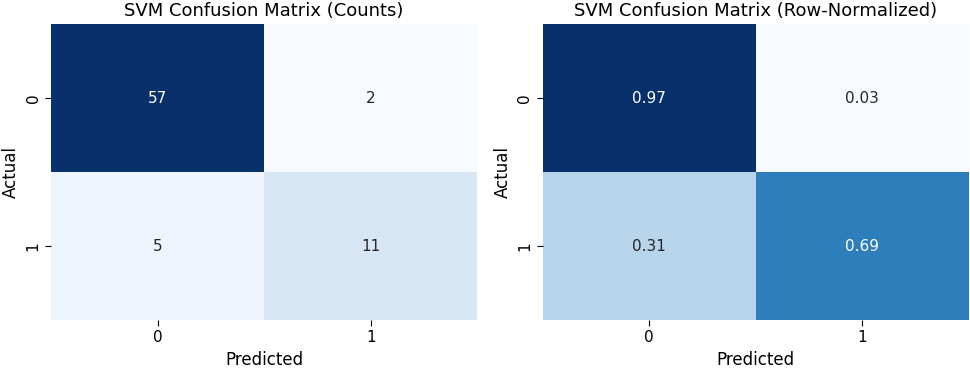

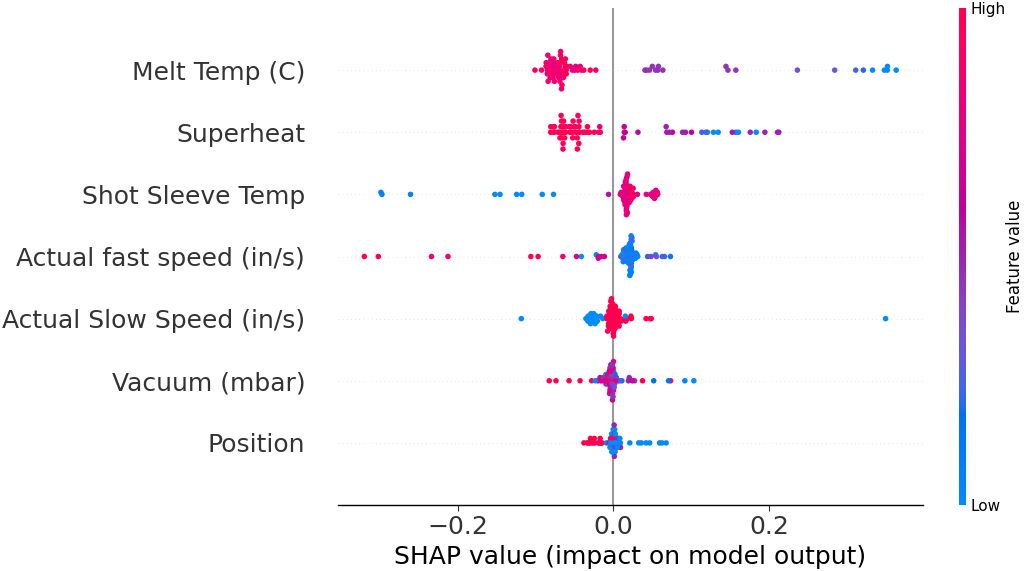

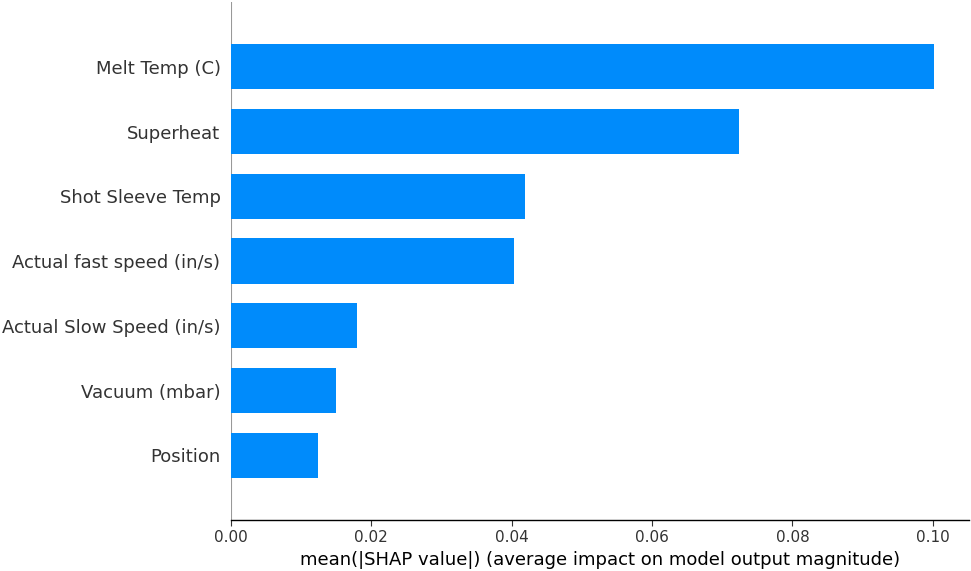

<Figure size 640x480 with 0 Axes>

In [29]:
# =============== SVM (RBF) Sweep Table (Accuracy) -> pick best -> OOF CM + SHAP ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import clone

# -------------------- Prepare X, y --------------------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Make sure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

# -------------------- Base pipeline --------------------
base_pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, random_state=111))
])

# -------------------- Hyperparameter grid (edit if you want) --------------------
C_list = [0.1, 1, 10, 100]
g_list = ["scale", "auto", 0.1, 0.01]

rows = []
run_no = 1

for C in C_list:
    for gamma in g_list:
        pipe = clone(base_pipe_svm)
        pipe.set_params(clf__C=C, clf__gamma=gamma)

        scores = cross_validate(
            pipe, X, y,
            cv=cv,
            scoring="accuracy",
            n_jobs=-1,
            return_estimator=True,
            return_train_score=False
        )

        acc_mean = float(scores["test_score"].mean())
        acc_std  = float(scores["test_score"].std(ddof=1))
        fit_time_total = float(np.sum(scores["fit_time"]))

        n_sv_avg = float(np.mean([est.named_steps["clf"].n_support_.sum()
                                  for est in scores["estimator"]]))

        rows.append({
            "No.": run_no,
            "Predictor": "SVM (RBF)",
            "Kernel": "rbf",
            "C": C,
            "gamma": gamma,
            "Support Vectors (avg)": int(round(n_sv_avg)),
            "Accuracy_CV": acc_mean,                 # numeric for selecting best
            "Accuracy_STD": acc_std,
            "Training Time (s)": round(fit_time_total, 1),
        })
        run_no += 1

tbl = pd.DataFrame(rows)

# ---- Sort like a "best-first" table (optional) ----
tbl = tbl.sort_values(by=["Accuracy_CV", "C"], ascending=[False, True]).reset_index(drop=True)
tbl["Accuracy (%)"] = (tbl["Accuracy_CV"] * 100).map(lambda v: f"{v:.2f}%")

tbl_display = tbl[["No.", "Predictor", "Kernel", "C", "gamma",
                   "Support Vectors (avg)", "Accuracy (%)", "Training Time (s)"]]

print("SVM (RBF) 5-fold CV accuracy across hyperparameters:")
display(tbl_display)

# -------------------- Pick best hyperparameters (by Accuracy_CV) --------------------
# Tie-break: (1) higher accuracy, (2) fewer support vectors, (3) smaller C
best_row = (
    tbl.sort_values(["Accuracy_CV", "Support Vectors (avg)", "C"],
                    ascending=[False, True, True])
       .iloc[0]
)

best_C = float(best_row["C"])
best_gamma = best_row["gamma"]

print(f"\nSelected BEST (by accuracy): C={best_C}, gamma={best_gamma}")
print(f"CV Accuracy (mean) = {best_row['Accuracy_CV']:.4f}  |  CV std = {best_row['Accuracy_STD']:.4f}")

best_pipe_svm = clone(base_pipe_svm).set_params(
    clf__C=best_C,
    clf__gamma=best_gamma
)

# -------------------- OOF predictions + confusion matrix --------------------
oof_pred_svm = cross_val_predict(best_pipe_svm, X, y, cv=cv, method="predict", n_jobs=-1)

print("\nClassification report (5-fold OOF, best SVM-by-accuracy):")
print(classification_report(y, oof_pred_svm, digits=3))

cm_svm  = confusion_matrix(y, oof_pred_svm)
cmn_svm = confusion_matrix(y, oof_pred_svm, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_svm,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("SVM Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn_svm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("SVM Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# -------------------- Fit best model on full data for SHAP --------------------
best_pipe_svm.fit(X, y)

background_raw = X.sample(min(200, len(X)), random_state=111)
explainer_svm = shap.Explainer(best_pipe_svm.predict_proba, background_raw)
sv_svm = explainer_svm(X)

clf_svm = best_pipe_svm.named_steps["clf"]
class_idx = 1 if (hasattr(clf_svm, "classes_") and 1 in clf_svm.classes_) else 0

# Beeswarm
shap.summary_plot(sv_svm[:, :, class_idx], X, plot_size=(11, 6), show=False)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout()
plt.show()

# Bar chart
shap.summary_plot(sv_svm[:, :, class_idx], X, plot_type="bar", plot_size=(10, 6))
plt.tight_layout()
plt.show()


Prediction map features (SVM, top 3 by SHAP):
  Feature 1: Melt Temp (C)
  Feature 2: Superheat
  Feature 3: Shot Sleeve Temp

Plotting SVM map: y = 'Melt Temp (C)', x = 'Superheat'


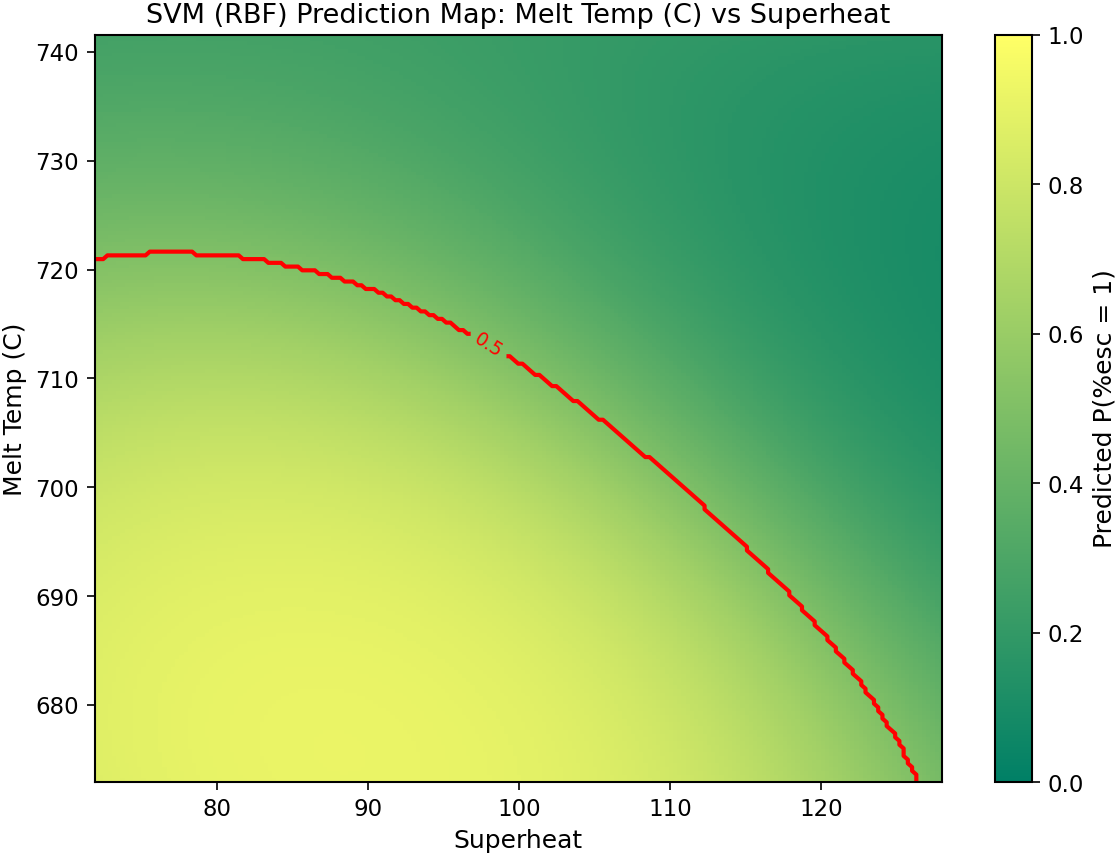


Plotting SVM map: y = 'Superheat', x = 'Shot Sleeve Temp'


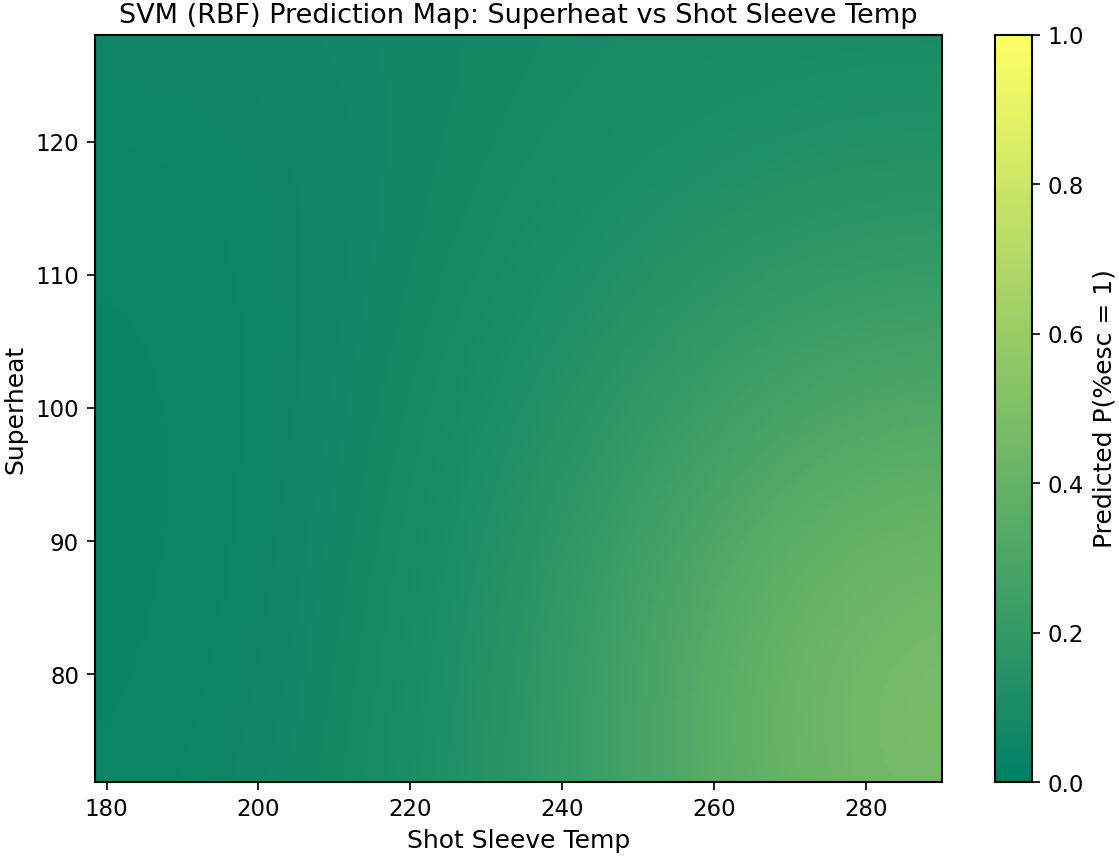


Plotting SVM map: y = 'Melt Temp (C)', x = 'Shot Sleeve Temp'


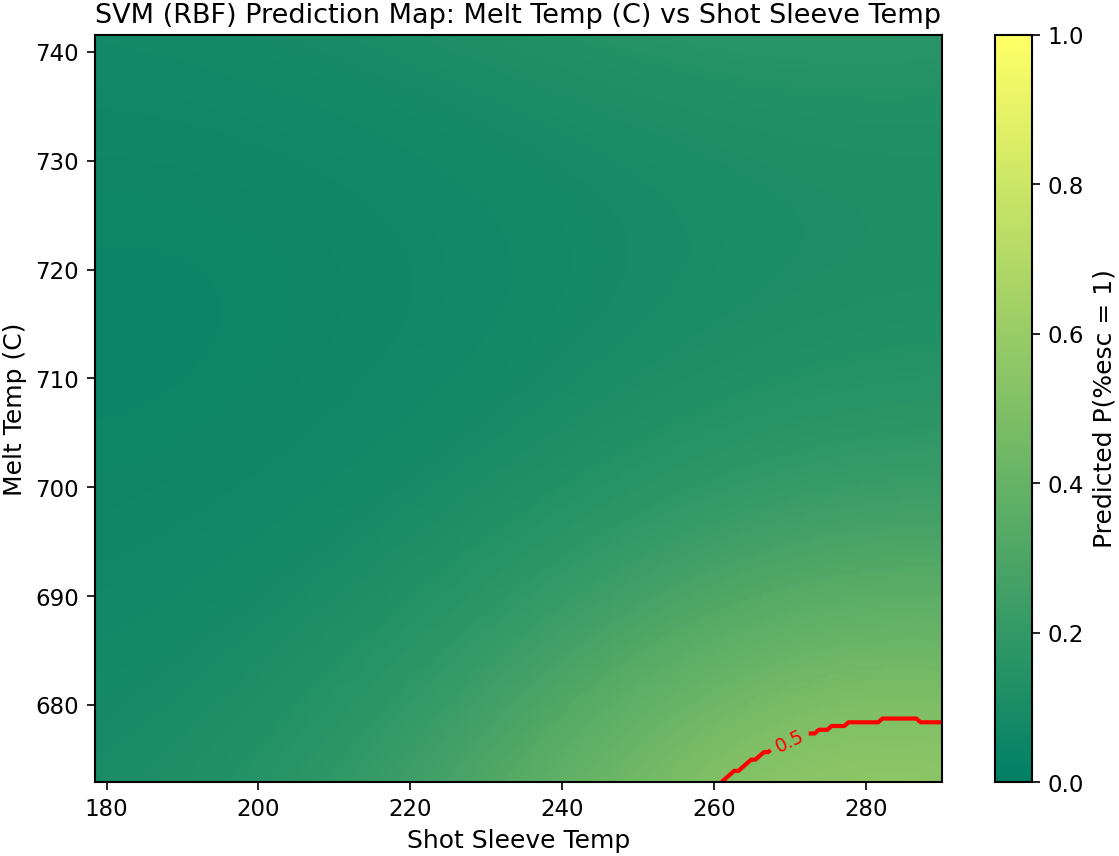

In [30]:
# =============== SVM (RBF) Prediction Maps (3-feature, 3 pairs) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ---- Get the fitted SVM pipeline and feature names ----
if 'best_pipe_svm' in globals():
    svm_pipe = best_pipe_svm
elif 'gs_svm' in globals():
    svm_pipe = gs_svm.best_estimator_
else:
    raise ValueError("No trained SVM found. Run the SVM CV cell to create best_pipe_svm or gs_svm first.")

# X must match the feature set used to train svm_pipe
if 'X' not in globals():
    raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
svm_clf = svm_pipe.named_steps["clf"]
class_idx = 1 if (hasattr(svm_clf, "classes_") and 1 in svm_clf.classes_) else 0

# ---- Pick three features by SHAP (model-agnostic) ----
background = X.sample(min(200, len(X)), random_state=111)
explainer = shap.Explainer(svm_pipe.predict_proba, background)
sv = explainer(X)  # shape: (n_samples, n_features, n_classes)

mean_abs_shap = np.abs(sv.values[:, :, class_idx]).mean(axis=0)  # (n_features,)
top3_idx = np.argsort(mean_abs_shap)[::-1][:3]
feat1, feat2, feat3 = [feature_names[i] for i in top3_idx]

# # (Optional manual override – uncomment and set your own three features)
feat1 = "Melt Temp (C)"
feat2 = "Superheat"
feat3 = "Shot Sleeve Temp"

print("Prediction map features (SVM, top 3 by SHAP):")
print(f"  Feature 1: {feat1}")
print(f"  Feature 2: {feat2}")
print(f"  Feature 3: {feat3}")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo); eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

# Fixed settings
n_points = 201
base = X.median(numeric_only=True)

pairs = [
    (feat1, feat2),
    (feat2, feat3),
    (feat1, feat3)
]

for (feat_i, feat_ii) in pairs:
    print(f"\nPlotting SVM map: y = '{feat_i}', x = '{feat_ii}'")

    # ---- Build ranges for the two swept features ----
    lo_i,  hi_i  = _range_for(X[feat_i])
    lo_ii, hi_ii = _range_for(X[feat_ii])

    # ---- Build the grid ----
    grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
    grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
    II, I   = np.meshgrid(grid_ii, grid_i)

    # ---- Create grid DataFrame; hold other features at median ----
    grid_df = pd.DataFrame(
        np.tile(base.values, (n_points * n_points, 1)),
        columns=feature_names
    )
    grid_df[feat_i]  = I.ravel()
    grid_df[feat_ii] = II.ravel()

    # ---- Predict P(class=1) on the grid via the pipeline (impute+scale+SVM) ----
    probs = svm_pipe.predict_proba(grid_df)[:, class_idx]
    Z = probs.reshape(n_points, n_points)

    # ---- Plot the prediction map ----
    plt.figure(figsize=(8, 6), dpi=150)
    im = plt.imshow(
        Z,
        extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
        origin='lower',
        aspect='auto',
        cmap='summer',
        vmin=0.0,
        vmax=1.0
    )
    plt.colorbar(im, label="Predicted P(%esc = 1)")

    # Decision boundary at 0.5
    cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
    plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

    plt.xlabel(feat_ii)
    plt.ylabel(feat_i)
    plt.title(f"SVM (RBF) Prediction Map: {feat_i} vs {feat_ii}")
    plt.tight_layout()
    plt.show()

    # # (Optional) Save each figure
    # plt.savefig(f"svm_prediction_map_{feat_i}_vs_{feat_ii}.png", dpi=300, bbox_inches="tight")


GaussianNB 5-fold CV accuracy across hyperparameters:


No.   Predictor  var_smoothing     Priors Accuracy (%)  Training Time (s)
0     1  GaussianNB   1.000000e-12  empirical       84.00%               0.12
1     3  GaussianNB   1.000000e-11  empirical       84.00%               0.12
2     5  GaussianNB   1.000000e-10  empirical       84.00%               0.09
3     7  GaussianNB   3.333333e-10  empirical       84.00%               0.16
4     9  GaussianNB   1.000000e-09  empirical       84.00%               0.12
5    11  GaussianNB   3.000000e-09  empirical       84.00%               0.14
6    13  GaussianNB   1.000000e-08  empirical       84.00%               0.14
7     2  GaussianNB   1.000000e-12    uniform       77.33%               0.11
8     4  GaussianNB   1.000000e-11    uniform       77.33%               0.11
9     6  GaussianNB   1.000000e-10    uniform       77.33%               0.12
10    8  GaussianNB   3.333333e-10    uniform       77.33%               0.10
11   10  GaussianNB   1.000000e-09    uniform       77.33%               0.15
12   12  GaussianNB   3.000000e-09    uniform       77.33%               0.14
13   14  GaussianNB   1.000000e-08    uniform       77.33%               0.18


Selected BEST (by accuracy): var_smoothing=1e-12, priors=empirical
CV Accuracy (mean) = 0.8400 | CV std = 0.0596

Classification report (5-fold OOF, best GaussianNB-by-accuracy):
              precision    recall  f1-score   support

           0      0.912     0.881     0.897        59
           1      0.611     0.688     0.647        16

    accuracy                          0.840        75
   macro avg      0.762     0.784     0.772        75
weighted avg      0.848     0.840     0.843        75



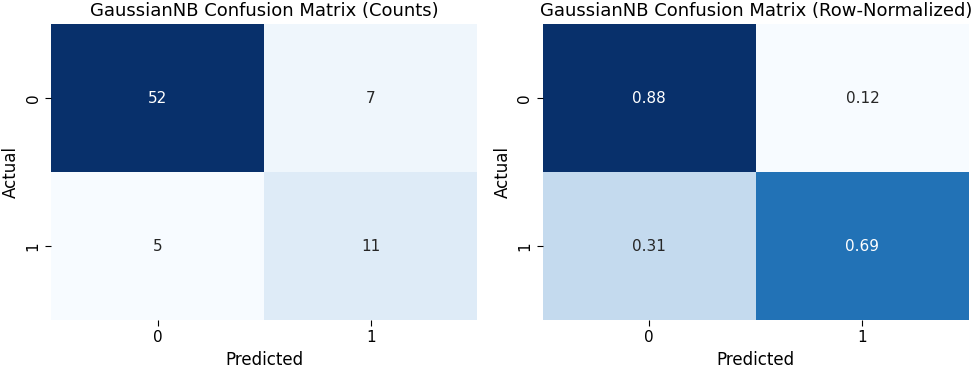


Top features ranked by mean(|SHAP|) using the BEST hyperparameters:


Feature  Mean(|SHAP|)
0             Melt Temp (C)      0.153084
1          Shot Sleeve Temp      0.149852
2                 Superheat      0.096541
3                  Position      0.038234
4  Actual Slow Speed (in/s)      0.022790
5  Actual fast speed (in/s)      0.019620
6             Vacuum (mbar)      0.016851

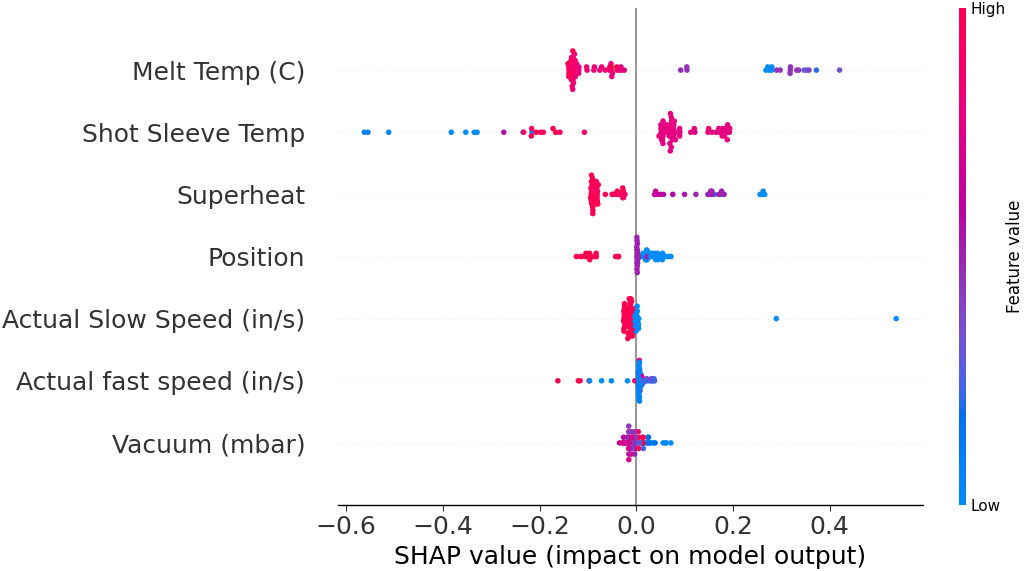

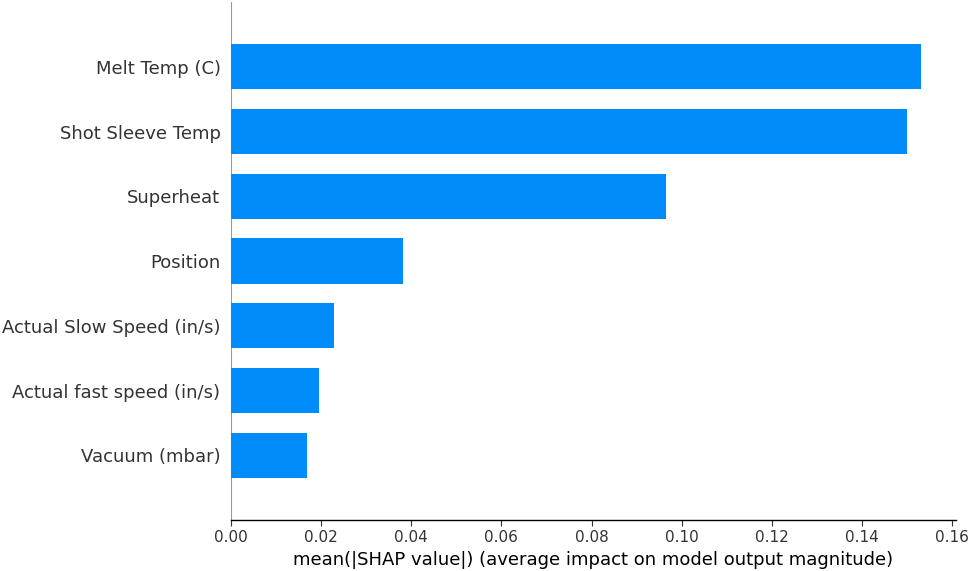

<Figure size 640x480 with 0 Axes>

In [31]:
# =============== GaussianNB: Sweep -> Best Hyperparams -> OOF Eval -> SHAP Feature Ranking ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import clone

# -------------------- Prepare X, y --------------------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Make sure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

# -------------------- Base pipeline --------------------
base_pipe_nb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GaussianNB())
])

# -------------------- Build sweep ranges (same spirit as your 2nd cell) --------------------
# If a previous gs_nb exists, center around it; otherwise use default 1e-9.
if 'gs_nb' in globals():
    base_vs = float(gs_nb.best_params_.get("clf__var_smoothing", 1e-9))
else:
    base_vs = 1e-9

cand_vs = np.unique(np.clip(
    np.array([base_vs/10, base_vs/3, base_vs, base_vs*3, base_vs*10,
              1e-12, 1e-11, 1e-10, 1e-9, 1e-8]),
    1e-12, 1e-6
))
cand_vs = np.sort(cand_vs)

classes_sorted = np.sort(pd.Series(y).unique())
uniform_priors = np.ones(len(classes_sorted)) / len(classes_sorted)
priors_grid = [None, uniform_priors]  # empirical vs uniform

# -------------------- Sweep + CV table (Accuracy) --------------------
rows = []
run_no = 1

for vs in cand_vs:
    for pri in priors_grid:
        pipe = clone(base_pipe_nb).set_params(clf__var_smoothing=float(vs), clf__priors=pri)

        scores = cross_validate(
            pipe, X, y, cv=cv,
            scoring="accuracy",
            n_jobs=-1,
            return_train_score=False
        )

        acc_mean = float(scores["test_score"].mean())
        acc_std  = float(scores["test_score"].std(ddof=1))
        fit_time_total = float(np.sum(scores["fit_time"]))

        rows.append({
            "No.": run_no,
            "Predictor": "GaussianNB",
            "var_smoothing": float(vs),
            "Priors": "uniform" if pri is not None else "empirical",
            "Accuracy_CV": acc_mean,
            "Accuracy_STD": acc_std,
            "Training Time (s)": round(fit_time_total, 2),
        })
        run_no += 1

tbl = pd.DataFrame(rows)

# Sort best-first for readability
tbl = tbl.sort_values(by=["Accuracy_CV", "var_smoothing"], ascending=[False, True]).reset_index(drop=True)
tbl["Accuracy (%)"] = (tbl["Accuracy_CV"] * 100).map(lambda v: f"{v:.2f}%")

tbl_display = tbl[["No.", "Predictor", "var_smoothing", "Priors", "Accuracy (%)", "Training Time (s)"]]
print("GaussianNB 5-fold CV accuracy across hyperparameters:")
display(tbl_display)

# -------------------- Pick best hyperparameters --------------------
# Tie-break: (1) higher accuracy, (2) lower std, (3) smaller var_smoothing
best_row = (
    tbl.sort_values(["Accuracy_CV", "Accuracy_STD", "var_smoothing"],
                    ascending=[False, True, True])
       .iloc[0]
)

best_vs = float(best_row["var_smoothing"])
best_priors_label = best_row["Priors"]
best_priors = uniform_priors if best_priors_label == "uniform" else None

print(f"\nSelected BEST (by accuracy): var_smoothing={best_vs:g}, priors={best_priors_label}")
print(f"CV Accuracy (mean) = {best_row['Accuracy_CV']:.4f} | CV std = {best_row['Accuracy_STD']:.4f}")

best_pipe_nb = clone(base_pipe_nb).set_params(clf__var_smoothing=best_vs, clf__priors=best_priors)

# -------------------- OOF evaluation (clean, non-leaky) --------------------
oof_pred_nb = cross_val_predict(best_pipe_nb, X, y, cv=cv, method="predict", n_jobs=-1)

print("\nClassification report (5-fold OOF, best GaussianNB-by-accuracy):")
print(classification_report(y, oof_pred_nb, digits=3))

cm_nb  = confusion_matrix(y, oof_pred_nb)
cmn_nb = confusion_matrix(y, oof_pred_nb, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_nb,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("GaussianNB Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn_nb, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("GaussianNB Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# -------------------- Fit best model on full data (for SHAP + ranking) --------------------
best_pipe_nb.fit(X, y)

background_raw = X.sample(min(200, len(X)), random_state=111)
explainer_nb = shap.Explainer(best_pipe_nb.predict_proba, background_raw)
sv_nb = explainer_nb(X)

clf_nb = best_pipe_nb.named_steps["clf"]
class_idx = 1 if (hasattr(clf_nb, "classes_") and 1 in clf_nb.classes_) else 0

# -------------------- Rank most important features (mean |SHAP| for class 1) --------------------
mean_abs_shap = np.abs(sv_nb.values[:, :, class_idx]).mean(axis=0)  # (n_features,)
feat_rank = pd.DataFrame({
    "Feature": X.columns,
    "Mean(|SHAP|)": mean_abs_shap
}).sort_values("Mean(|SHAP|)", ascending=False).reset_index(drop=True)

print("\nTop features ranked by mean(|SHAP|) using the BEST hyperparameters:")
display(feat_rank.head(25))

# -------------------- SHAP plots --------------------
shap.summary_plot(
    sv_nb[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout(); plt.show()

shap.summary_plot(
    sv_nb[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout(); plt.show()


Prediction map features (Naive Bayes): y-axis = 'Superheat', x-axis = 'Melt Temp (C)'


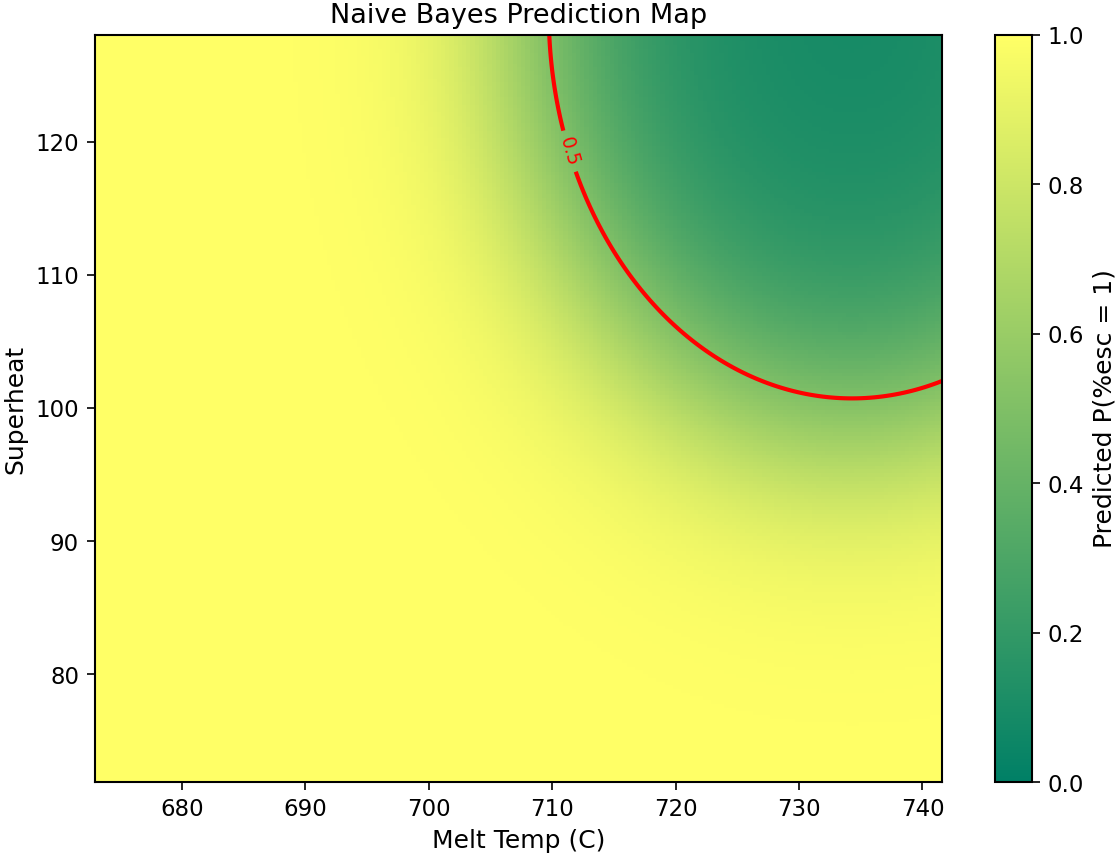

In [33]:
# =============== Naive Bayes (GaussianNB) Prediction Map (2-feature sweep) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ---- Get the fitted NB pipeline and feature names ----
if 'best_pipe_nb' in globals():
    nb_pipe = best_pipe_nb
elif 'gs_nb' in globals():
    nb_pipe = gs_nb.best_estimator_
else:
    raise ValueError("No trained Naive Bayes found. Run the NB CV cell to create best_pipe_nb or gs_nb first.")

# X must be the same feature set used to train nb_pipe
if 'X' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
    else:
        raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
nb_clf = nb_pipe.named_steps["clf"]
class_idx = 1 if (hasattr(nb_clf, "classes_") and 1 in nb_clf.classes_) else 0

# ---- Pick two features by SHAP (model-agnostic) ----
background = X.sample(min(200, len(X)), random_state=111)
explainer = shap.Explainer(nb_pipe.predict_proba, background)
sv = explainer(X)  # (n_samples, n_features, n_classes)

mean_abs_shap = np.abs(sv.values[:, :, class_idx]).mean(axis=0)  # (n_features,)
top2_idx = np.argsort(mean_abs_shap)[::-1][:2]
feat_i, feat_ii = feature_names[top2_idx[0]], feature_names[top2_idx[1]]  # y-axis, x-axis

# (Optional manual override)
feat_i  = "Superheat"
feat_ii = "Melt Temp (C)"

print(f"Prediction map features (Naive Bayes): y-axis = '{feat_i}', x-axis = '{feat_ii}'")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo); eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

lo_i,  hi_i  = _range_for(X[feat_i])
lo_ii, hi_ii = _range_for(X[feat_ii])

# ---- Build grid ----
n_points = 201
grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
II, I = np.meshgrid(grid_ii, grid_i)

# ---- Create grid DataFrame; hold other features at median ----
base = X.median(numeric_only=True)
grid_df = pd.DataFrame(
    np.tile(base.values, (n_points * n_points, 1)),
    columns=feature_names
)
grid_df[feat_i]  = I.ravel()
grid_df[feat_ii] = II.ravel()

# ---- Predict P(class=1) on the grid via the pipeline (impute + NB) ----
probs = nb_pipe.predict_proba(grid_df)[:, class_idx]
Z = probs.reshape(n_points, n_points)

# ---- Plot ----
plt.figure(figsize=(8, 6), dpi=150)
im = plt.imshow(
    Z,
    extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
    origin='lower',
    aspect='auto',
    cmap='summer',  # similar to your example
    vmin=0.0,   # force lower limit
    vmax=1.0    # force upper limit
)
plt.colorbar(im, label="Predicted P(%esc = 1)")

# 0.5 decision contour
cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

plt.xlabel(feat_ii)
plt.ylabel(feat_i)
plt.title("Naive Bayes Prediction Map")
plt.tight_layout()
plt.show()

# ---- (Optional) Save ----
# plt.savefig("naive_bayes_prediction_map.png", dpi=300, bbox_inches="tight")
# plt.savefig("naive_bayes_prediction_map.pdf", bbox_inches="tight")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params (KNN): {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'}
Best 5-fold CV F1 (KNN): 0.6914285714285715

Classification report (5-fold OOF, KNN):
              precision    recall  f1-score   support

           0      0.894     1.000     0.944        59
           1      1.000     0.562     0.720        16

    accuracy                          0.907        75
   macro avg      0.947     0.781     0.832        75
weighted avg      0.917     0.907     0.896        75



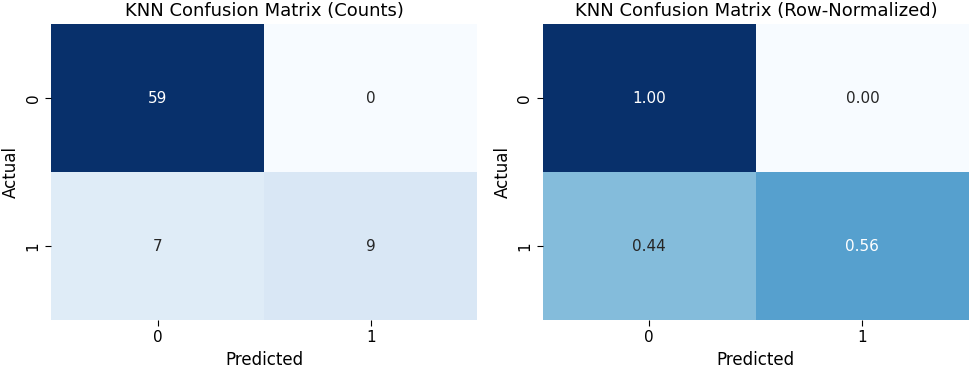

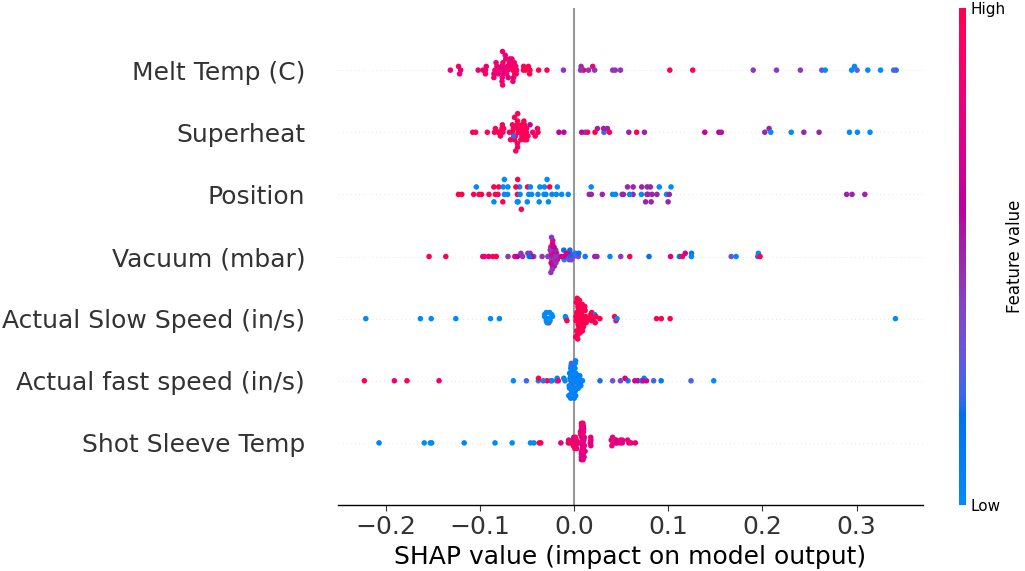

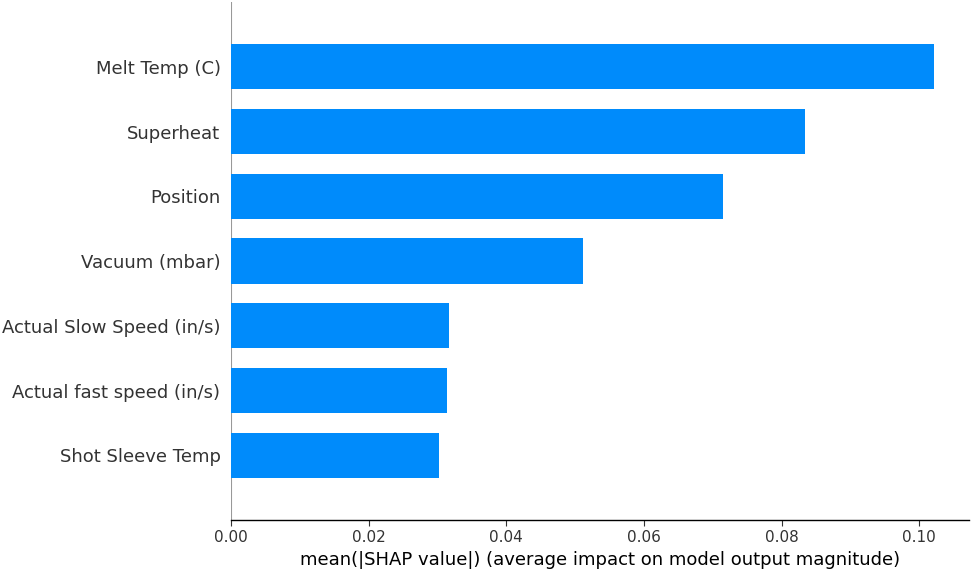

<Figure size 640x480 with 0 Axes>

In [ ]:
# =============== KNN (scaled, 5-fold CV) + Confusion Matrix + SHAP ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler   # KNN works well with 0–1 scaling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# -------- Prepare X, y --------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Ensure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

pipe_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()),                   # avoid leakage by scaling inside CV
    ("clf", KNeighborsClassifier())
])

param_grid_knn = {
    "clf__n_neighbors": [3, 5, 7, 9, 11],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],                             # 1=Manhattan, 2=Euclidean
    # "clf__metric": ["minkowski"],               # default; keep if you want to be explicit
}

gs_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring="f1",                                 # alt: "f1_macro", "roc_auc", "balanced_accuracy", "accuracy"
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs_knn.fit(X, y)
best_pipe_knn = gs_knn.best_estimator_
print("Best params (KNN):", gs_knn.best_params_)
print("Best 5-fold CV F1 (KNN):", gs_knn.best_score_)

# -------- Out-of-fold predictions for evaluation --------
oof_pred_knn = cross_val_predict(best_pipe_knn, X, y, cv=cv, method="predict")
print("\nClassification report (5-fold OOF, KNN):")
print(classification_report(y, oof_pred_knn, digits=3))

# Confusion matrices (counts + normalized)
cm_knn  = confusion_matrix(y, oof_pred_knn)
cmn_knn = confusion_matrix(y, oof_pred_knn, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_knn,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("KNN Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn_knn, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("KNN Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# -------- SHAP global importance (function-based explainer) --------
# Explains P(class=1); includes impute+scale inside the pipeline.
background_raw = X.sample(min(200, len(X)), random_state=111)
explainer_knn = shap.Explainer(best_pipe_knn.predict_proba, background_raw)
sv_knn = explainer_knn(X)

# Positive class index
clf_knn = best_pipe_knn.named_steps["clf"]
class_idx = 1 if (hasattr(clf_knn, "classes_") and 1 in clf_knn.classes_) else 0

shap.summary_plot(
    sv_knn[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()

# Increase tick label sizes
ax.tick_params(axis='both', labelsize=18)

# Increase axis label size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout(); plt.show()

# Bar chart of mean |SHAP|
shap.summary_plot(
    sv_knn[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout(); plt.show()


KNN 5-fold CV accuracy across hyperparameters:


No. Predictor  K (neighbors)   Weights  p (norm) Accuracy (%)  \
0     7       KNN              5  distance         1       90.67%   
1    16       KNN              9  distance         2       90.67%   
2     1       KNN              3   uniform         1       89.33%   
3    10       KNN              7   uniform         2       89.33%   
4    11       KNN              7  distance         1       89.33%   
5    12       KNN              7  distance         2       89.33%   
6    13       KNN              9   uniform         1       89.33%   
7    15       KNN              9  distance         1       89.33%   
8    19       KNN             11  distance         1       89.33%   
9    20       KNN             11  distance         2       89.33%   
10    3       KNN              3  distance         1       88.00%   
11    5       KNN              5   uniform         1       88.00%   
12    8       KNN              5  distance         2       88.00%   
13    9       KNN              7   uniform         1       88.00%   
14    2       KNN              3   uniform         2       86.67%   
15    6       KNN              5   uniform         2       86.67%   
16   14       KNN              9   uniform         2       86.67%   
17   18       KNN             11   uniform         2       86.67%   
18    4       KNN              3  distance         2       85.33%   
19   17       KNN             11   uniform         1       85.33%   

    Training Time (s)  
0                0.13  
1                0.11  
2                0.18  
3                0.13  
4                0.13  
5                0.13  
6                0.12  
7                0.15  
8                0.17  
9                0.13  
10               0.14  
11               0.15  
12               0.13  
13               0.12  
14               0.16  
15               0.15  
16               0.19  
17               0.14  
18               0.14  
19               0.08


Selected BEST (by accuracy): K=5, weights='distance', p=1
CV Accuracy (mean) = 0.9067 | CV std = 0.0365

Classification report (5-fold OOF, best KNN-by-accuracy):
              precision    recall  f1-score   support

           0      0.894     1.000     0.944        59
           1      1.000     0.562     0.720        16

    accuracy                          0.907        75
   macro avg      0.947     0.781     0.832        75
weighted avg      0.917     0.907     0.896        75



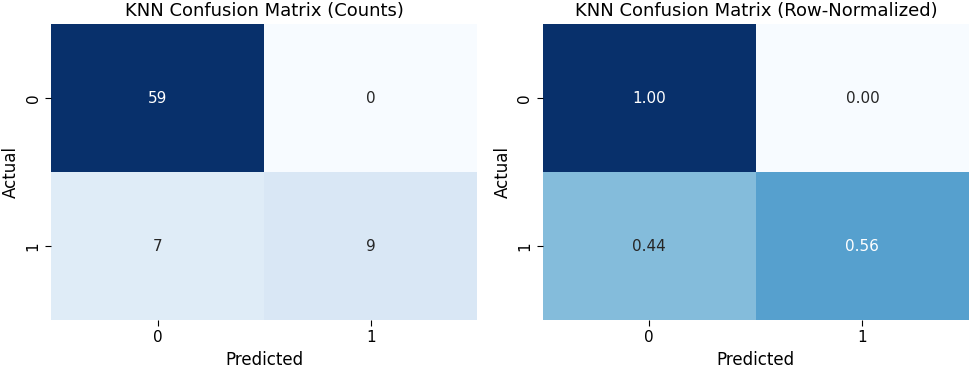


Top features ranked by mean(|SHAP|) using the BEST hyperparameters:


Feature  Mean(|SHAP|)
0             Melt Temp (C)      0.102109
1                 Superheat      0.083334
2                  Position      0.071514
3             Vacuum (mbar)      0.051138
4  Actual Slow Speed (in/s)      0.031694
5  Actual fast speed (in/s)      0.031344
6          Shot Sleeve Temp      0.030207

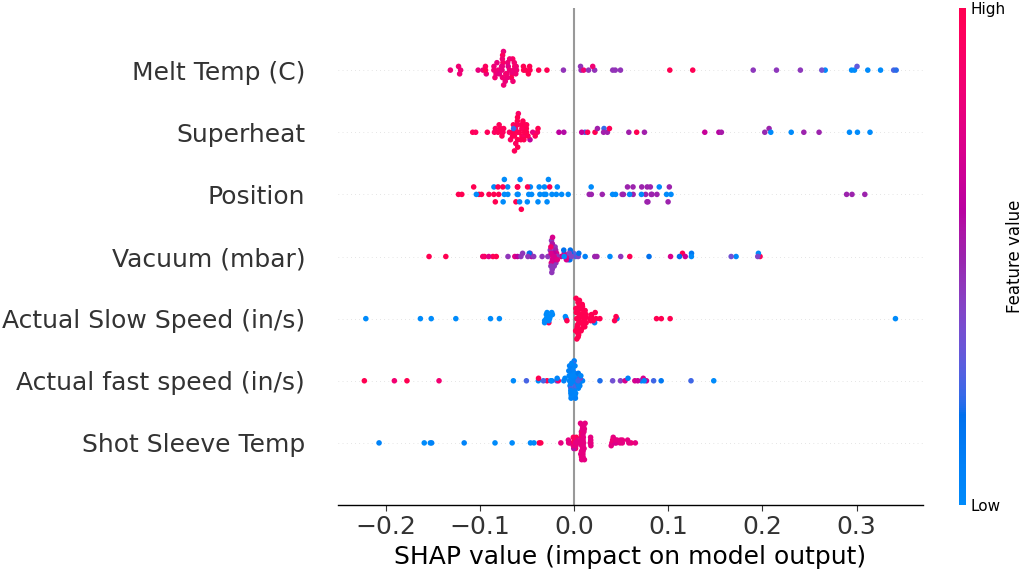

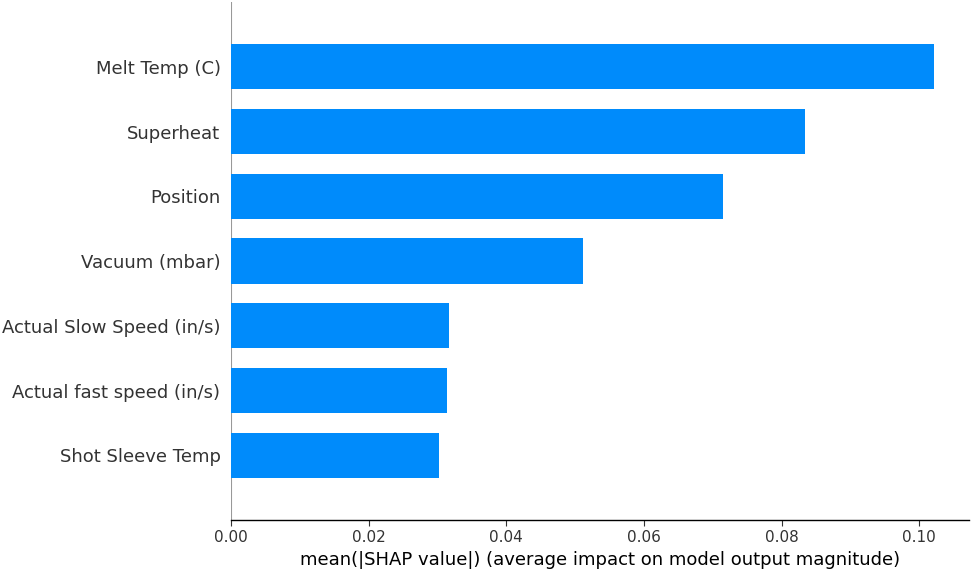

<Figure size 640x480 with 0 Axes>

In [34]:
# =============== KNN: Sweep (Accuracy Table) -> Best Params -> OOF Eval -> SHAP Feature Ranking ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import clone

# -------------------- Prepare X, y --------------------
if 'X' not in globals() or 'y' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
        y = full_df['%esc'].astype(int).copy()
    else:
        raise ValueError("X/y not found. Make sure you have full_df with a '%esc' column or define X, y earlier.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=111)

# -------------------- Base pipeline --------------------
base_pipe_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()),                 # scale inside CV (no leakage)
    ("clf", KNeighborsClassifier())
])

# -------------------- Hyperparameter sweep grid --------------------
K_list = [3, 5, 7, 9, 11]
weights_list = ["uniform", "distance"]
p_list = [1, 2]                                 # 1=Manhattan, 2=Euclidean

rows = []
run_no = 1

for k in K_list:
    for w in weights_list:
        for p in p_list:
            pipe = clone(base_pipe_knn).set_params(
                clf__n_neighbors=k,
                clf__weights=w,
                clf__p=p
            )

            scores = cross_validate(
                pipe, X, y, cv=cv,
                scoring="accuracy",
                n_jobs=-1,
                return_train_score=False
            )

            acc_mean = float(scores["test_score"].mean())
            acc_std  = float(scores["test_score"].std(ddof=1))
            fit_time_total = float(np.sum(scores["fit_time"]))

            rows.append({
                "No.": run_no,
                "Predictor": "KNN",
                "K (neighbors)": k,
                "Weights": w,
                "p (norm)": p,
                "Accuracy_CV": acc_mean,
                "Accuracy_STD": acc_std,
                "Training Time (s)": round(fit_time_total, 2),
            })
            run_no += 1

tbl = pd.DataFrame(rows)

# Publication-style display table (best-first)
tbl = tbl.sort_values(by=["Accuracy_CV", "K (neighbors)"], ascending=[False, True]).reset_index(drop=True)
tbl["Accuracy (%)"] = (tbl["Accuracy_CV"] * 100).map(lambda v: f"{v:.2f}%")

tbl_display = tbl[["No.", "Predictor", "K (neighbors)", "Weights", "p (norm)",
                   "Accuracy (%)", "Training Time (s)"]]

print("KNN 5-fold CV accuracy across hyperparameters:")
display(tbl_display)

# -------------------- Pick best hyperparameters --------------------
# Tie-break: (1) higher accuracy, (2) lower std, (3) smaller K
best_row = (
    tbl.sort_values(["Accuracy_CV", "Accuracy_STD", "K (neighbors)"],
                    ascending=[False, True, True])
       .iloc[0]
)

best_k = int(best_row["K (neighbors)"])
best_w = str(best_row["Weights"])
best_p = int(best_row["p (norm)"])

print(f"\nSelected BEST (by accuracy): K={best_k}, weights='{best_w}', p={best_p}")
print(f"CV Accuracy (mean) = {best_row['Accuracy_CV']:.4f} | CV std = {best_row['Accuracy_STD']:.4f}")

best_pipe_knn = clone(base_pipe_knn).set_params(
    clf__n_neighbors=best_k,
    clf__weights=best_w,
    clf__p=best_p
)

# -------------------- OOF evaluation --------------------
oof_pred_knn = cross_val_predict(best_pipe_knn, X, y, cv=cv, method="predict", n_jobs=-1)

print("\nClassification report (5-fold OOF, best KNN-by-accuracy):")
print(classification_report(y, oof_pred_knn, digits=3))

cm_knn  = confusion_matrix(y, oof_pred_knn)
cmn_knn = confusion_matrix(y, oof_pred_knn, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_knn,  annot=True, fmt="d",   cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("KNN Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(cmn_knn, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("KNN Confusion Matrix (Row-Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")
plt.tight_layout(); plt.show()

# -------------------- Fit best model on full data (for SHAP + ranking) --------------------
best_pipe_knn.fit(X, y)

background_raw = X.sample(min(200, len(X)), random_state=111)
explainer_knn = shap.Explainer(best_pipe_knn.predict_proba, background_raw)
sv_knn = explainer_knn(X)

clf_knn = best_pipe_knn.named_steps["clf"]
class_idx = 1 if (hasattr(clf_knn, "classes_") and 1 in clf_knn.classes_) else 0

# -------------------- Rank features by mean(|SHAP|) using BEST hyperparameters --------------------
mean_abs_shap = np.abs(sv_knn.values[:, :, class_idx]).mean(axis=0)
feat_rank = pd.DataFrame({
    "Feature": X.columns,
    "Mean(|SHAP|)": mean_abs_shap
}).sort_values("Mean(|SHAP|)", ascending=False).reset_index(drop=True)

print("\nTop features ranked by mean(|SHAP|) using the BEST hyperparameters:")
display(feat_rank.head(25))

# -------------------- SHAP plots --------------------
shap.summary_plot(
    sv_knn[:, :, class_idx],
    X,
    plot_size=(11, 6),
    show=False
)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.tight_layout(); plt.show()

shap.summary_plot(
    sv_knn[:, :, class_idx],
    X,
    plot_type="bar",
    plot_size=(10, 6)
)
plt.tight_layout(); plt.show()


Prediction map features (KNN): y-axis = 'Superheat', x-axis = 'Melt Temp (C)'


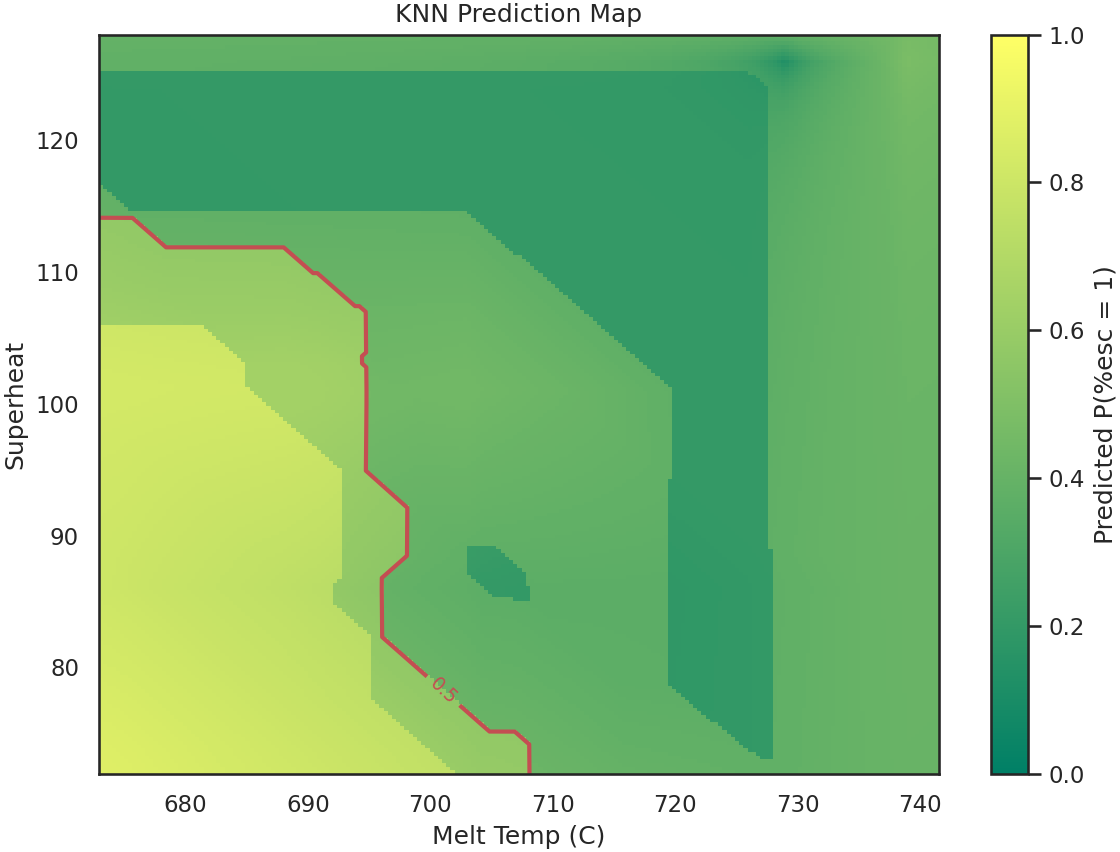

In [36]:
# =============== KNN Prediction Map (2-feature sweep) ===============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ---- Get the fitted KNN pipeline and feature names ----
if 'best_pipe_knn' in globals():
    knn_pipe = best_pipe_knn
elif 'gs_knn' in globals():
    knn_pipe = gs_knn.best_estimator_
else:
    raise ValueError("No trained KNN found. Run the KNN CV cell to create best_pipe_knn or gs_knn first.")

# X must be the same feature set used to train knn_pipe
if 'X' not in globals():
    if 'full_df' in globals() and '%esc' in full_df.columns:
        X = full_df.drop(columns=['%esc']).copy()
    else:
        raise ValueError("X not found. Rebuild X from full_df (drop '%esc') before running this cell.")

feature_names = X.columns.tolist()
knn_clf = knn_pipe.named_steps["clf"]
class_idx = 1 if (hasattr(knn_clf, "classes_") and 1 in knn_clf.classes_) else 0

# ---- Pick two features by SHAP (model-agnostic) ----
background = X.sample(min(200, len(X)), random_state=111)
explainer = shap.Explainer(knn_pipe.predict_proba, background)
sv = explainer(X)  # (n_samples, n_features, n_classes)

mean_abs_shap = np.abs(sv.values[:, :, class_idx]).mean(axis=0)  # (n_features,)
top2_idx = np.argsort(mean_abs_shap)[::-1][:2]
feat_i, feat_ii = feature_names[top2_idx[0]], feature_names[top2_idx[1]]  # y-axis, x-axis

# (Optional manual override)
feat_i  = "Superheat"
feat_ii = "Melt Temp (C)"

print(f"Prediction map features (KNN): y-axis = '{feat_i}', x-axis = '{feat_ii}'")

# ---- Define ranges using robust percentiles to avoid outliers ----
def _range_for(col: pd.Series, q_low=2, q_high=98):
    vals = col.dropna().values
    lo, hi = np.percentile(vals, [q_low, q_high])
    if lo == hi:
        v = float(lo); eps = 0.01 * (abs(v) + 1.0)
        lo, hi = v - eps, v + eps
    return lo, hi

lo_i,  hi_i  = _range_for(X[feat_i])
lo_ii, hi_ii = _range_for(X[feat_ii])

# ---- Build the grid ----
n_points = 201
grid_i  = np.linspace(lo_i,  hi_i,  n_points)   # y-axis sweep (feat_i)
grid_ii = np.linspace(lo_ii, hi_ii, n_points)   # x-axis sweep (feat_ii)
II, I = np.meshgrid(grid_ii, grid_i)

# ---- Create grid DataFrame; hold other features at median ----
base = X.median(numeric_only=True)
grid_df = pd.DataFrame(
    np.tile(base.values, (n_points * n_points, 1)),
    columns=feature_names
)
grid_df[feat_i]  = I.ravel()
grid_df[feat_ii] = II.ravel()

# ---- Predict P(class=1) on the grid via the pipeline (impute+scale+KNN) ----
probs = knn_pipe.predict_proba(grid_df)[:, class_idx]
Z = probs.reshape(n_points, n_points)

# ---- Plot the prediction map ----
plt.figure(figsize=(8, 6), dpi=150)
im = plt.imshow(
    Z,
    extent=[grid_ii[0], grid_ii[-1], grid_i[0], grid_i[-1]],
    origin='lower',
    aspect='auto',
    cmap='summer',  # similar to your example
    vmin=0.0,   # force lower limit
    vmax=1.0    # force upper limitS
)
plt.colorbar(im, label="Predicted P(%esc = 1)")

# Decision boundary at 0.5
cs = plt.contour(II, I, Z, levels=[0.5], colors='r', linewidths=2)
plt.clabel(cs, fmt={0.5: "0.5"}, inline=True, fontsize=9)

plt.xlabel(feat_ii)
plt.ylabel(feat_i)
plt.title("KNN Prediction Map")
plt.tight_layout()
plt.show()

# ---- (Optional) Save ----
# plt.savefig("knn_prediction_map.png", dpi=300, bbox_inches="tight")
# plt.savefig("knn_prediction_map.pdf", bbox_inches="tight")


/tmp/ipython-input-3568131495.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=accuracy, y=methods, palette=palette_list, ax=ax)


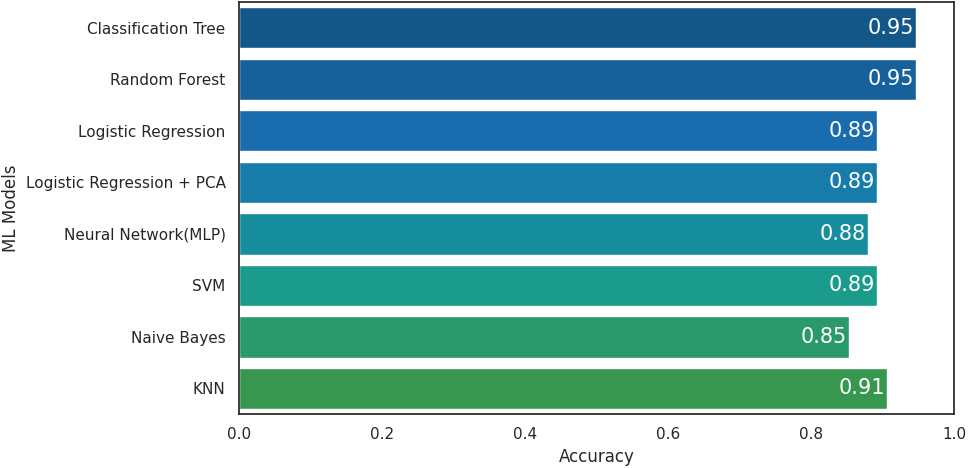

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors   # <-- missing import、

# 1) Define your custom colormap
colors = [
    (0.0,   "#005A9C"),   # at 0% of the scale
    (0.333, "#0072CE"),   # at 33.3%
    (0.666, "#00B2A9"),   # at 66.6%
    (1.0,   "#28A745")    # at 100%
]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)


## Ranking graph for the models
accuracy = [0.947,0.947,0.893,0.893,0.88,0.893,0.853,0.907]
methods  = ['Classification Tree','Random Forest','Logistic Regression',
            'Logistic Regression + PCA','Neural Network(MLP)','SVM',
            'Naive Bayes','KNN']

sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(10,5))

# 3) Build a palette by sampling your custom_cmap at evenly spaced points
N = len(methods)
palette_list = [ custom_cmap(t) for t in np.linspace(0, 1, N) ]


ax = sns.barplot(x=accuracy, y=methods, palette=palette_list, ax=ax)
plt.xlabel('Accuracy')
plt.ylabel('ML Models')
plt.xlim(0, 1)  # ensure enough room

# draw each bar's label *inside* the bar
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',
        label_type='edge',    # put label in the center of each bar
        padding=-35,
        color='white',          # or another color that contrasts
        fontsize=15
    )

plt.tight_layout()
plt.show()